### Dodatkowe kody

SMOTE - -przy braku zainstalowanego imblearnu

In [ ]:
"""Base class for sampling"""

# Authors: Guillaume Lemaitre <g.lemaitre58@gmail.com>
#          Christos Aridas
# License: MIT

from abc import ABCMeta, abstractmethod

import numpy as np

from sklearn.base import BaseEstimator
from sklearn.preprocessing import label_binarize
from sklearn.utils import check_X_y
from sklearn.utils.multiclass import check_classification_targets

#from .utils import check_sampling_strategy, check_target_type

"""Utilities for input validation"""

# Authors: Guillaume Lemaitre <g.lemaitre58@gmail.com>
# License: MIT

import warnings
from collections import OrderedDict
from numbers import Integral, Real

import numpy as np

from sklearn.base import clone
from sklearn.neighbors._base import KNeighborsMixin
from sklearn.neighbors import NearestNeighbors
from sklearn.utils.multiclass import type_of_target

#from ..exceptions import raise_isinstance_error

SAMPLING_KIND = (
    "over-sampling",
    "under-sampling",
    "clean-sampling",
    "ensemble",
    "bypass",
)
TARGET_KIND = ("binary", "multiclass", "multilabel-indicator")


def check_neighbors_object(nn_name, nn_object, additional_neighbor=0):
    """Check the objects is consistent to be a NN.

    Several methods in imblearn relies on NN. Until version 0.4, these
    objects can be passed at initialisation as an integer or a
    KNeighborsMixin. After only KNeighborsMixin will be accepted. This
    utility allows for type checking and raise if the type is wrong.

    Parameters
    ----------
    nn_name : str,
        The name associated to the object to raise an error if needed.

    nn_object : int or KNeighborsMixin,
        The object to be checked

    additional_neighbor : int, optional (default=0)
        Sometimes, some algorithm need an additional neighbors.

    Returns
    -------
    nn_object : KNeighborsMixin
        The k-NN object.
    """
    if isinstance(nn_object, Integral):
        return NearestNeighbors(n_neighbors=nn_object + additional_neighbor)
    elif isinstance(nn_object, KNeighborsMixin):
        return clone(nn_object)
    else:
        raise_isinstance_error(nn_name, [int, KNeighborsMixin], nn_object)


def _count_class_sample(y):
    unique, counts = np.unique(y, return_counts=True)
    return dict(zip(unique, counts))


def check_target_type(y, indicate_one_vs_all=False):
    """Check the target types to be conform to the current samplers.

    The current samplers should be compatible with ``'binary'``,
    ``'multilabel-indicator'`` and ``'multiclass'`` targets only.

    Parameters
    ----------
    y : ndarray,
        The array containing the target.

    indicate_one_vs_all : bool, optional
        Either to indicate if the targets are encoded in a one-vs-all fashion.

    Returns
    -------
    y : ndarray,
        The returned target.

    is_one_vs_all : bool, optional
        Indicate if the target was originally encoded in a one-vs-all fashion.
        Only returned if ``indicate_multilabel=True``.

    """
    type_y = type_of_target(y)
    if type_y == "multilabel-indicator":
        if np.any(y.sum(axis=1) > 1):
            raise ValueError(
                "Imbalanced-learn currently supports binary, multiclass and "
                "binarized encoded multiclasss targets. Multilabel and "
                "multioutput targets are not supported."
            )
        y = y.argmax(axis=1)

    return (y, type_y == "multilabel-indicator") if indicate_one_vs_all else y


def _sampling_strategy_all(y, sampling_type):
    """Returns sampling target by targeting all classes."""
    target_stats = _count_class_sample(y)
    if sampling_type == "over-sampling":
        n_sample_majority = max(target_stats.values())
        sampling_strategy = {
            key: n_sample_majority - value
            for (key, value) in target_stats.items()
        }
    elif (
        sampling_type == "under-sampling" or sampling_type == "clean-sampling"
    ):
        n_sample_minority = min(target_stats.values())
        sampling_strategy = {
            key: n_sample_minority for key in target_stats.keys()
        }
    else:
        raise NotImplementedError

    return sampling_strategy


def _sampling_strategy_majority(y, sampling_type):
    """Returns sampling target by targeting the majority class only."""
    if sampling_type == "over-sampling":
        raise ValueError(
            "'sampling_strategy'='majority' cannot be used with"
            " over-sampler."
        )
    elif (
        sampling_type == "under-sampling" or sampling_type == "clean-sampling"
    ):
        target_stats = _count_class_sample(y)
        class_majority = max(target_stats, key=target_stats.get)
        n_sample_minority = min(target_stats.values())
        sampling_strategy = {
            key: n_sample_minority
            for key in target_stats.keys()
            if key == class_majority
        }
    else:
        raise NotImplementedError

    return sampling_strategy


def _sampling_strategy_not_majority(y, sampling_type):
    """Returns sampling target by targeting all classes but not the
    majority."""
    target_stats = _count_class_sample(y)
    if sampling_type == "over-sampling":
        n_sample_majority = max(target_stats.values())
        class_majority = max(target_stats, key=target_stats.get)
        sampling_strategy = {
            key: n_sample_majority - value
            for (key, value) in target_stats.items()
            if key != class_majority
        }
    elif (
        sampling_type == "under-sampling" or sampling_type == "clean-sampling"
    ):
        n_sample_minority = min(target_stats.values())
        class_majority = max(target_stats, key=target_stats.get)
        sampling_strategy = {
            key: n_sample_minority
            for key in target_stats.keys()
            if key != class_majority
        }
    else:
        raise NotImplementedError

    return sampling_strategy


def _sampling_strategy_not_minority(y, sampling_type):
    """Returns sampling target by targeting all classes but not the
    minority."""
    target_stats = _count_class_sample(y)
    if sampling_type == "over-sampling":
        n_sample_majority = max(target_stats.values())
        class_minority = min(target_stats, key=target_stats.get)
        sampling_strategy = {
            key: n_sample_majority - value
            for (key, value) in target_stats.items()
            if key != class_minority
        }
    elif (
        sampling_type == "under-sampling" or sampling_type == "clean-sampling"
    ):
        n_sample_minority = min(target_stats.values())
        class_minority = min(target_stats, key=target_stats.get)
        sampling_strategy = {
            key: n_sample_minority
            for key in target_stats.keys()
            if key != class_minority
        }
    else:
        raise NotImplementedError

    return sampling_strategy


def _sampling_strategy_minority(y, sampling_type):
    """Returns sampling target by targeting the minority class only."""
    target_stats = _count_class_sample(y)
    if sampling_type == "over-sampling":
        n_sample_majority = max(target_stats.values())
        class_minority = min(target_stats, key=target_stats.get)
        sampling_strategy = {
            key: n_sample_majority - value
            for (key, value) in target_stats.items()
            if key == class_minority
        }
    elif (
        sampling_type == "under-sampling" or sampling_type == "clean-sampling"
    ):
        raise ValueError(
            "'sampling_strategy'='minority' cannot be used with"
            " under-sampler and clean-sampler."
        )
    else:
        raise NotImplementedError

    return sampling_strategy


def _sampling_strategy_auto(y, sampling_type):
    """Returns sampling target auto for over-sampling and not-minority for
    under-sampling."""
    if sampling_type == "over-sampling":
        return _sampling_strategy_not_majority(y, sampling_type)
    elif (
        sampling_type == "under-sampling" or sampling_type == "clean-sampling"
    ):
        return _sampling_strategy_not_minority(y, sampling_type)


def _sampling_strategy_dict(sampling_strategy, y, sampling_type):
    """Returns sampling target by converting the dictionary depending of the
    sampling."""
    target_stats = _count_class_sample(y)
    # check that all keys in sampling_strategy are also in y
    set_diff_sampling_strategy_target = set(sampling_strategy.keys()) - set(
        target_stats.keys()
    )
    if len(set_diff_sampling_strategy_target) > 0:
        raise ValueError(
            "The {} target class is/are not present in the"
            " data.".format(set_diff_sampling_strategy_target)
        )
    # check that there is no negative number
    if any(n_samples < 0 for n_samples in sampling_strategy.values()):
        raise ValueError(
            "The number of samples in a class cannot be negative."
            "'sampling_strategy' contains some negative value: {}".format(
                sampling_strategy
            )
        )
    sampling_strategy_ = {}
    if sampling_type == "over-sampling":
        n_samples_majority = max(target_stats.values())
        class_majority = max(target_stats, key=target_stats.get)
        for class_sample, n_samples in sampling_strategy.items():
            if n_samples < target_stats[class_sample]:
                raise ValueError(
                    "With over-sampling methods, the number"
                    " of samples in a class should be greater"
                    " or equal to the original number of samples."
                    " Originally, there is {} samples and {}"
                    " samples are asked.".format(
                        target_stats[class_sample], n_samples
                    )
                )
            if n_samples > n_samples_majority:
                warnings.warn(
                    "After over-sampling, the number of samples ({})"
                    " in class {} will be larger than the number of"
                    " samples in the majority class (class #{} ->"
                    " {})".format(
                        n_samples,
                        class_sample,
                        class_majority,
                        n_samples_majority,
                    )
                )
            sampling_strategy_[class_sample] = (
                n_samples - target_stats[class_sample]
            )
    elif sampling_type == "under-sampling":
        for class_sample, n_samples in sampling_strategy.items():
            if n_samples > target_stats[class_sample]:
                raise ValueError(
                    "With under-sampling methods, the number of"
                    " samples in a class should be less or equal"
                    " to the original number of samples."
                    " Originally, there is {} samples and {}"
                    " samples are asked.".format(
                        target_stats[class_sample], n_samples
                    )
                )
            sampling_strategy_[class_sample] = n_samples
    elif sampling_type == "clean-sampling":
        raise ValueError(
            "'sampling_strategy' as a dict for cleaning methods is "
            "not supported. Please give a list of the classes to be "
            "targeted by the sampling."
        )
    else:
        raise NotImplementedError

    return sampling_strategy_


def _sampling_strategy_list(sampling_strategy, y, sampling_type):
    """With cleaning methods, sampling_strategy can be a list to target the
 class of interest."""
    if sampling_type != "clean-sampling":
        raise ValueError(
            "'sampling_strategy' cannot be a list for samplers "
            "which are not cleaning methods."
        )

    target_stats = _count_class_sample(y)
    # check that all keys in sampling_strategy are also in y
    set_diff_sampling_strategy_target = set(sampling_strategy) - set(
        target_stats.keys()
    )
    if len(set_diff_sampling_strategy_target) > 0:
        raise ValueError(
            "The {} target class is/are not present in the"
            " data.".format(set_diff_sampling_strategy_target)
        )

    return {
        class_sample: min(target_stats.values())
        for class_sample in sampling_strategy
    }


def _sampling_strategy_float(sampling_strategy, y, sampling_type):
    """Take a proportion of the majority (over-sampling) or minority
    (under-sampling) class in binary classification."""
    type_y = type_of_target(y)
    if type_y != "binary":
        raise ValueError(
            '"sampling_strategy" can be a float only when the type '
            "of target is binary. For multi-class, use a dict."
        )
    target_stats = _count_class_sample(y)
    if sampling_type == "over-sampling":
        n_sample_majority = max(target_stats.values())
        class_majority = max(target_stats, key=target_stats.get)
        sampling_strategy_ = {
            key: int(n_sample_majority * sampling_strategy - value)
            for (key, value) in target_stats.items()
            if key != class_majority
        }
        if any([n_samples <= 0 for n_samples in sampling_strategy_.values()]):
            raise ValueError(
                "The specified ratio required to remove samples "
                "from the minority class while trying to "
                "generate new samples. Please increase the "
                "ratio."
            )
    elif sampling_type == "under-sampling":
        n_sample_minority = min(target_stats.values())
        class_minority = min(target_stats, key=target_stats.get)
        sampling_strategy_ = {
            key: int(n_sample_minority / sampling_strategy)
            for (key, value) in target_stats.items()
            if key != class_minority
        }
        if any(
            [
                n_samples > target_stats[target]
                for target, n_samples in sampling_strategy_.items()
            ]
        ):
            raise ValueError(
                "The specified ratio required to generate new "
                "sample in the majority class while trying to "
                "remove samples. Please increase the ratio."
            )
    else:
        raise ValueError(
            "'clean-sampling' methods do let the user "
            "specify the sampling ratio."
        )
    return sampling_strategy_


def check_sampling_strategy(sampling_strategy, y, sampling_type, **kwargs):
    """Sampling target validation for samplers.

    Checks that ``sampling_strategy`` is of consistent type and return a
    dictionary containing each targeted class with its corresponding
    number of sample. It is used in :class:`imblearn.base.BaseSampler`.

    Parameters
    ----------
    sampling_strategy : float, str, dict, list or callable,
        Sampling information to sample the data set.

        - When ``float``:

            For **under-sampling methods**, it corresponds to the ratio
            :math:`\\alpha_{us}` defined by :math:`N_{rM} = \\alpha_{us}
            \\times N_{m}` where :math:`N_{rM}` and :math:`N_{m}` are the
            number of samples in the majority class after resampling and the
            number of samples in the minority class, respectively;

            For **over-sampling methods**, it correspond to the ratio
            :math:`\\alpha_{os}` defined by :math:`N_{rm} = \\alpha_{os}
            \\times N_{m}` where :math:`N_{rm}` and :math:`N_{M}` are the
            number of samples in the minority class after resampling and the
            number of samples in the majority class, respectively.

            .. warning::
               ``float`` is only available for **binary** classification. An
               error is raised for multi-class classification and with cleaning
               samplers.

        - When ``str``, specify the class targeted by the resampling. For
          **under- and over-sampling methods**, the number of samples in the
          different classes will be equalized. For **cleaning methods**, the
          number of samples will not be equal. Possible choices are:

            ``'minority'``: resample only the minority class;

            ``'majority'``: resample only the majority class;

            ``'not minority'``: resample all classes but the minority class;

            ``'not majority'``: resample all classes but the majority class;

            ``'all'``: resample all classes;

            ``'auto'``: for under-sampling methods, equivalent to ``'not
            minority'`` and for over-sampling methods, equivalent to ``'not
            majority'``.

        - When ``dict``, the keys correspond to the targeted classes. The
          values correspond to the desired number of samples for each targeted
          class.

          .. warning::
             ``dict`` is available for both **under- and over-sampling
             methods**. An error is raised with **cleaning methods**. Use a
             ``list`` instead.

        - When ``list``, the list contains the targeted classes. It used only
          for **cleaning methods**.

          .. warning::
             ``list`` is available for **cleaning methods**. An error is raised
             with **under- and over-sampling methods**.

        - When callable, function taking ``y`` and returns a ``dict``. The keys
          correspond to the targeted classes. The values correspond to the
          desired number of samples for each class.

    y : ndarray, shape (n_samples,)
        The target array.

    sampling_type : str,
        The type of sampling. Can be either ``'over-sampling'``,
        ``'under-sampling'``, or ``'clean-sampling'``.

    kwargs : dict, optional
        Dictionary of additional keyword arguments to pass to
        ``sampling_strategy`` when this is a callable.

    Returns
    -------
    sampling_strategy_converted : dict,
        The converted and validated sampling target. Returns a dictionary with
        the key being the class target and the value being the desired
        number of samples.

    """
    if sampling_type not in SAMPLING_KIND:
        raise ValueError(
            "'sampling_type' should be one of {}. Got '{}'"
            " instead.".format(SAMPLING_KIND, sampling_type)
        )

    if np.unique(y).size <= 1:
        raise ValueError(
            "The target 'y' needs to have more than 1 class."
            " Got {} class instead".format(np.unique(y).size)
        )

    if sampling_type in ("ensemble", "bypass"):
        return sampling_strategy

    if isinstance(sampling_strategy, str):
        if sampling_strategy not in SAMPLING_TARGET_KIND.keys():
            raise ValueError(
                "When 'sampling_strategy' is a string, it needs"
                " to be one of {}. Got '{}' instead.".format(
                    SAMPLING_TARGET_KIND, sampling_strategy
                )
            )
        return OrderedDict(
            sorted(
                SAMPLING_TARGET_KIND[sampling_strategy](
                    y, sampling_type
                ).items()
            )
        )
    elif isinstance(sampling_strategy, dict):
        return OrderedDict(
            sorted(
                _sampling_strategy_dict(
                    sampling_strategy, y, sampling_type
                ).items()
            )
        )
    elif isinstance(sampling_strategy, list):
        return OrderedDict(
            sorted(
                _sampling_strategy_list(
                    sampling_strategy, y, sampling_type
                ).items()
            )
        )
    elif isinstance(sampling_strategy, Real):
        if sampling_strategy <= 0 or sampling_strategy > 1:
            raise ValueError(
                "When 'sampling_strategy' is a float, it should be "
                "in the range (0, 1]. Got {} instead.".format(
                    sampling_strategy
                )
            )
        return OrderedDict(
            sorted(
                _sampling_strategy_float(
                    sampling_strategy, y, sampling_type
                ).items()
            )
        )
    elif callable(sampling_strategy):
        sampling_strategy_ = sampling_strategy(y, **kwargs)
        return OrderedDict(
            sorted(
                _sampling_strategy_dict(
                    sampling_strategy_, y, sampling_type
                ).items()
            )
        )


SAMPLING_TARGET_KIND = {
    "minority": _sampling_strategy_minority,
    "majority": _sampling_strategy_majority,
    "not minority": _sampling_strategy_not_minority,
    "not majority": _sampling_strategy_not_majority,
    "all": _sampling_strategy_all,
    "auto": _sampling_strategy_auto,
}
class SamplerMixin(BaseEstimator, metaclass=ABCMeta):
    """Mixin class for samplers with abstract method.

    Warning: This class should not be used directly. Use the derive classes
    instead.
    """

    _estimator_type = "sampler"

    def fit(self, X, y):
        """Check inputs and statistics of the sampler.

        You should use ``fit_resample`` in all cases.

        Parameters
        ----------
        X : {array-like, dataframe, sparse matrix} of shape \
                (n_samples, n_features)
            Data array.

        y : array-like of shape (n_samples,)
            Target array.

        Returns
        -------
        self : object
            Return the instance itself.
        """
        X, y, _ = self._check_X_y(X, y)
        self.sampling_strategy_ = check_sampling_strategy(
            self.sampling_strategy, y, self._sampling_type
        )
        return self

    def fit_resample(self, X, y):
        """Resample the dataset.

        Parameters
        ----------
        X : {array-like, dataframe, sparse matrix} of shape \
                (n_samples, n_features)
            Matrix containing the data which have to be sampled.

        y : array-like of shape (n_samples,)
            Corresponding label for each sample in X.

        Returns
        -------
        X_resampled : {array-like, dataframe, sparse matrix} of shape \
                (n_samples_new, n_features)
            The array containing the resampled data.

        y_resampled : array-like of shape (n_samples_new,)
            The corresponding label of `X_resampled`.
        """
        check_classification_targets(y)
        X, y, binarize_y = self._check_X_y(X, y)

        self.sampling_strategy_ = check_sampling_strategy(
            self.sampling_strategy, y, self._sampling_type
        )

        output = self._fit_resample(X, y)

        if self._X_columns is not None or self._y_name is not None:
            import pandas as pd

        if self._X_columns is not None:
            X_ = pd.DataFrame(output[0], columns=self._X_columns)
            X_ = X_.astype(self._X_dtypes)
        else:
            X_ = output[0]

        y_ = (label_binarize(output[1], np.unique(y))
              if binarize_y else output[1])

        if self._y_name is not None:
            y_ = pd.Series(y_, dtype=self._y_dtype, name=self._y_name)

        return (X_, y_) if len(output) == 2 else (X_, y_, output[2])

    #  define an alias for back-compatibility
    fit_sample = fit_resample

    @abstractmethod
    def _fit_resample(self, X, y):
        """Base method defined in each sampler to defined the sampling
        strategy.

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            Matrix containing the data which have to be sampled.

        y : array-like of shape (n_samples,)
            Corresponding label for each sample in X.

        Returns
        -------
        X_resampled : {ndarray, sparse matrix} of shape \
                (n_samples_new, n_features)
            The array containing the resampled data.

        y_resampled : ndarray of shape (n_samples_new,)
            The corresponding label of `X_resampled`.

        """
        pass


class BaseSampler(SamplerMixin):
    """Base class for sampling algorithms.

    Warning: This class should not be used directly. Use the derive classes
    instead.
    """

    def __init__(self, sampling_strategy="auto"):
        self.sampling_strategy = sampling_strategy

    def _check_X_y(self, X, y, accept_sparse=None):
        if hasattr(X, "loc"):
            # store information to build dataframe
            self._X_columns = X.columns
            self._X_dtypes = X.dtypes
        else:
            self._X_columns = None
            self._X_dtypes = None

        if hasattr(y, "loc"):
            # store information to build a series
            self._y_name = y.name
            self._y_dtype = y.dtype
        else:
            self._y_name = None
            self._y_dtype = None

        if accept_sparse is None:
            accept_sparse = ["csr", "csc"]
        y, binarize_y = check_target_type(y, indicate_one_vs_all=True)
        X, y = check_X_y(X, y, accept_sparse=accept_sparse)
        return X, y, binarize_y


def _identity(X, y):
    return X, y


class FunctionSampler(BaseSampler):
    """Construct a sampler from calling an arbitrary callable.

    Read more in the :ref:`User Guide <function_sampler>`.

    Parameters
    ----------
    func : callable, default=None
        The callable to use for the transformation. This will be passed the
        same arguments as transform, with args and kwargs forwarded. If func is
        None, then func will be the identity function.

    accept_sparse : bool, default=True
        Whether sparse input are supported. By default, sparse inputs are
        supported.

    kw_args : dict, default=None
        The keyword argument expected by ``func``.

    validate : bool, default=True
        Whether or not to bypass the validation of ``X`` and ``y``. Turning-off
        validation allows to use the ``FunctionSampler`` with any type of
        data.

    See Also
    --------

    sklearn.preprocessing.FunctionTransfomer : Stateless transformer.

    Notes
    -----
    See
    :ref:`sphx_glr_auto_examples_plot_outlier_rejections.py`

    Examples
    --------
    >>> import numpy as np
    >>> from sklearn.datasets import make_classification
    >>> from imblearn import FunctionSampler
    >>> X, y = make_classification(n_classes=2, class_sep=2,
    ... weights=[0.1, 0.9], n_informative=3, n_redundant=1, flip_y=0,
    ... n_features=20, n_clusters_per_class=1, n_samples=1000, random_state=10)

    We can create to select only the first ten samples for instance.

    >>> def func(X, y):
    ...   return X[:10], y[:10]
    >>> sampler = FunctionSampler(func=func)
    >>> X_res, y_res = sampler.fit_resample(X, y)
    >>> np.all(X_res == X[:10])
    True
    >>> np.all(y_res == y[:10])
    True

    We can also create a specific function which take some arguments.

    >>> from collections import Counter
    >>> from imblearn.under_sampling import RandomUnderSampler
    >>> def func(X, y, sampling_strategy, random_state):
    ...   return RandomUnderSampler(
    ...       sampling_strategy=sampling_strategy,
    ...       random_state=random_state).fit_resample(X, y)
    >>> sampler = FunctionSampler(func=func,
    ...                           kw_args={'sampling_strategy': 'auto',
    ...                                    'random_state': 0})
    >>> X_res, y_res = sampler.fit_resample(X, y)
    >>> print('Resampled dataset shape {}'.format(
    ...     sorted(Counter(y_res).items())))
    Resampled dataset shape [(0, 100), (1, 100)]
    """

    _sampling_type = "bypass"

    def __init__(self, func=None, accept_sparse=True, kw_args=None,
                 validate=True):
        super().__init__()
        self.func = func
        self.accept_sparse = accept_sparse
        self.kw_args = kw_args
        self.validate = validate

    def fit_resample(self, X, y):
        """Resample the dataset.

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            Matrix containing the data which have to be sampled.

        y : array-like of shape (n_samples,)
            Corresponding label for each sample in X.

        Returns
        -------
        X_resampled : {array-like, sparse matrix} of shape \
                (n_samples_new, n_features)
            The array containing the resampled data.

        y_resampled : array-like of shape (n_samples_new,)
            The corresponding label of `X_resampled`.
        """
        # store the columns name to reconstruct a dataframe
        self._columns = X.columns if hasattr(X, "loc") else None
        if self.validate:
            check_classification_targets(y)
            X, y, binarize_y = self._check_X_y(
                X, y, accept_sparse=self.accept_sparse
            )

        self.sampling_strategy_ = check_sampling_strategy(
            self.sampling_strategy, y, self._sampling_type
        )

        output = self._fit_resample(X, y)

        if self.validate:
            if self._X_columns is not None or self._y_name is not None:
                import pandas as pd

            if self._X_columns is not None:
                X_ = pd.DataFrame(output[0], columns=self._X_columns)
                X_ = X_.astype(self._X_dtypes)
            else:
                X_ = output[0]

            y_ = (label_binarize(output[1], np.unique(y))
                  if binarize_y else output[1])

            if self._y_name is not None:
                y_ = pd.Series(y_, dtype=self._y_dtype, name=self._y_name)

            return (X_, y_) if len(output) == 2 else (X_, y_, output[2])
        return output

    def _fit_resample(self, X, y):
        func = _identity if self.func is None else self.func
        output = func(X, y, **(self.kw_args if self.kw_args else {}))
        return output

In [ ]:
def heatmap(values, xlabel, ylabel, xticklabels, yticklabels, cmap=None,
            vmin=None, vmax=None, ax=None, fmt="%0.2f"):
    if ax is None:
        ax = plt.gca()
    # plot the mean cross-validation scores
    img = ax.pcolor(values, cmap=cmap, vmin=vmin, vmax=vmax)
    img.update_scalarmappable()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticks(np.arange(len(xticklabels)) + .5)
    ax.set_yticks(np.arange(len(yticklabels)) + .5)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.set_aspect(1)

    for p, color, value in zip(img.get_paths(), img.get_facecolors(),
                               img.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.mean(color[:3]) > 0.5:
            c = 'k'
        else:
            c = 'w'
        ax.text(x, y, fmt % value, color=c, ha="center", va="center")
    return img


# Określanie Osobowości z tekstu

### Wczytanie danych, Ekstrakcja Cech oraz Wizualizacja

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv(r"C:\Users\Michał\Downloads\mbti-type\mbti_1.csv",sep = ",", engine = "python")
df

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...
...,...,...
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908||...
8671,ENFP,'So...if this thread already exists someplace ...
8672,INTP,'So many questions when i do these things. I ...
8673,INFP,'I am very conflicted right now when it comes ...


Wizualizacja udziału klas: Podejrzenie znaczącego efektu niebalansowania

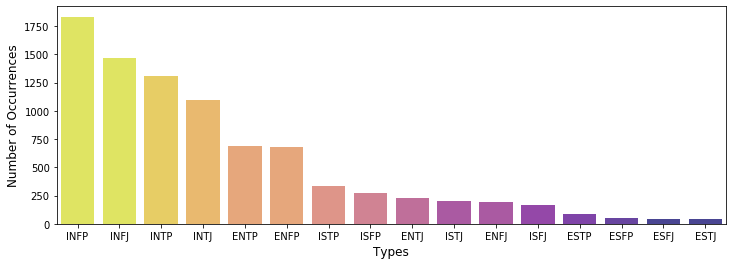

In [7]:

#Wizualizacja udziału Klas

from matplotlib import cm

cnt_srs = df['type'].value_counts()
viridis = cm.get_cmap('plasma', 12)
colors = viridis(np.flip(np.linspace(0, 1, 16)))
plt.figure(figsize=(12,4))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8,palette=colors)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Types', fontsize=12)
plt.show()

Z naszych postów ekstraktujemy wybrane Cechy: ilosc słow na osobę, ilość wielokropków, ilośc linków, ilość muzyki, ilość jpgów, ilość użycia 'I'

In [8]:
def words_per_post():

    df['words_per_post'] = 0
    for i in range(len(df.index)):
        df['words_per_post'].loc[i] = len(df["posts"].loc[i].split())/50
        #print(len(df["posts"].loc[i].split())/50)

def Average_frase_per_person(frase):
    df["{} per Post".format(frase)] = 0
    for i in range(len(df.index)):
        df["{} per Post".format(frase)].loc[i]  = df["posts"].loc[i].count(frase)/50
   
    
    


#### Ekstrakcja

In [9]:
#Cecha 1: Ile słów na post używa dana osoba?

words_per_post()
df

C:\Program Files (x86)\Anaconda\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,type,posts,words_per_post
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,11.12
1,ENTP,'I'm finding the lack of me in these posts ver...,23.40
2,INTP,'Good one _____ https://www.youtube.com/wat...,16.72
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",21.28
4,ENTJ,'You're fired.|||That's another silly misconce...,19.34
...,...,...,...
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908||...,15.92
8671,ENFP,'So...if this thread already exists someplace ...,26.18
8672,INTP,'So many questions when i do these things. I ...,18.96
8673,INFP,'I am very conflicted right now when it comes ...,34.10


In [10]:
#Cecha 2: Ile średnio wielokropków na post używa dana osoba?

Average_frase_per_person('...')
df

C:\Program Files (x86)\Anaconda\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,type,posts,words_per_post,... per Post
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,11.12,0.30
1,ENTP,'I'm finding the lack of me in these posts ver...,23.40,0.38
2,INTP,'Good one _____ https://www.youtube.com/wat...,16.72,0.26
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",21.28,0.52
4,ENTJ,'You're fired.|||That's another silly misconce...,19.34,0.42
...,...,...,...,...
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908||...,15.92,0.14
8671,ENFP,'So...if this thread already exists someplace ...,26.18,0.82
8672,INTP,'So many questions when i do these things. I ...,18.96,0.38
8673,INFP,'I am very conflicted right now when it comes ...,34.10,0.94


In [11]:

#Cecha 3: Ile średnio linków na post używa dana osoba?
Average_frase_per_person('http')
df


C:\Program Files (x86)\Anaconda\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,type,posts,words_per_post,... per Post,http per Post
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,11.12,0.30,0.48
1,ENTP,'I'm finding the lack of me in these posts ver...,23.40,0.38,0.20
2,INTP,'Good one _____ https://www.youtube.com/wat...,16.72,0.26,0.10
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",21.28,0.52,0.04
4,ENTJ,'You're fired.|||That's another silly misconce...,19.34,0.42,0.12
...,...,...,...,...,...
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908||...,15.92,0.14,0.14
8671,ENFP,'So...if this thread already exists someplace ...,26.18,0.82,0.04
8672,INTP,'So many questions when i do these things. I ...,18.96,0.38,0.04
8673,INFP,'I am very conflicted right now when it comes ...,34.10,0.94,0.00


In [12]:
#Cecha 4: Ile średnio frazy 'Muzyka' na post używa dana osoba?

Average_frase_per_person('music')
df

C:\Program Files (x86)\Anaconda\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,type,posts,words_per_post,... per Post,http per Post,music per Post
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,11.12,0.30,0.48,0.02
1,ENTP,'I'm finding the lack of me in these posts ver...,23.40,0.38,0.20,0.00
2,INTP,'Good one _____ https://www.youtube.com/wat...,16.72,0.26,0.10,0.00
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",21.28,0.52,0.04,0.02
4,ENTJ,'You're fired.|||That's another silly misconce...,19.34,0.42,0.12,0.02
...,...,...,...,...,...,...
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908||...,15.92,0.14,0.14,0.00
8671,ENFP,'So...if this thread already exists someplace ...,26.18,0.82,0.04,0.00
8672,INTP,'So many questions when i do these things. I ...,18.96,0.38,0.04,0.00
8673,INFP,'I am very conflicted right now when it comes ...,34.10,0.94,0.00,0.00


In [13]:
#Cecha 5: Ile średnio obrazków na post używa dana osoba?

Average_frase_per_person('jpg')
df

C:\Program Files (x86)\Anaconda\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,type,posts,words_per_post,... per Post,http per Post,music per Post,jpg per Post
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,11.12,0.30,0.48,0.02,0.12
1,ENTP,'I'm finding the lack of me in these posts ver...,23.40,0.38,0.20,0.00,0.02
2,INTP,'Good one _____ https://www.youtube.com/wat...,16.72,0.26,0.10,0.00,0.00
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",21.28,0.52,0.04,0.02,0.00
4,ENTJ,'You're fired.|||That's another silly misconce...,19.34,0.42,0.12,0.02,0.04
...,...,...,...,...,...,...,...
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908||...,15.92,0.14,0.14,0.00,0.02
8671,ENFP,'So...if this thread already exists someplace ...,26.18,0.82,0.04,0.00,0.00
8672,INTP,'So many questions when i do these things. I ...,18.96,0.38,0.04,0.00,0.00
8673,INFP,'I am very conflicted right now when it comes ...,34.10,0.94,0.00,0.00,0.00


In [14]:
#Cecha 6: Ile średnio SŁowa 'I' na post używa dana osoba?
#Wzięte z Analizy częstości występowania

Average_frase_per_person('I')
df

C:\Program Files (x86)\Anaconda\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,type,posts,words_per_post,... per Post,http per Post,music per Post,jpg per Post,I per Post
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,11.12,0.30,0.48,0.02,0.12,0.46
1,ENTP,'I'm finding the lack of me in these posts ver...,23.40,0.38,0.20,0.00,0.02,2.02
2,INTP,'Good one _____ https://www.youtube.com/wat...,16.72,0.26,0.10,0.00,0.00,0.98
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",21.28,0.52,0.04,0.02,0.00,1.74
4,ENTJ,'You're fired.|||That's another silly misconce...,19.34,0.42,0.12,0.02,0.04,0.92
...,...,...,...,...,...,...,...,...
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908||...,15.92,0.14,0.14,0.00,0.02,1.02
8671,ENFP,'So...if this thread already exists someplace ...,26.18,0.82,0.04,0.00,0.00,2.40
8672,INTP,'So many questions when i do these things. I ...,18.96,0.38,0.04,0.00,0.00,0.98
8673,INFP,'I am very conflicted right now when it comes ...,34.10,0.94,0.00,0.00,0.00,3.22


#### Wizualizacja

In [42]:
#Wizualizacja Razem --> pokazanie że średnie są niemalże identyczne ==> słaba rozpoznawalność

def wykres_osobowosci_razem(od_czego,do_czego='type'):
    from matplotlib import cm
  
    viridis = cm.get_cmap('plasma', 12)
    colors = viridis(np.linspace(0, 1, 16))

    typ_osobow = np.unique(df[do_czego])
    plt.figure(figsize = (10,10))
   # cmap = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w','b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
    for i in range(len(typ_osobow)):
        plt.axvline(x=np.mean(df[od_czego].loc[df[do_czego]==typ_osobow[i]]),color=colors[i])
        plt.hist(df[od_czego].loc[df[do_czego]==typ_osobow[i]],bins=25,color=colors[i])
        plt.title(od_czego)
        #print("{}: {}".format(typ_osobow[i],np.mean(df[od_czego].loc[df['type']==typ_osobow[i]])))
    plt.legend(typ_osobow)
    plt.show

#wizualizacja poszczególnych Cech dla wybranych typów osobowości

def wykres_osobowosci(od_czego,ticks=(0,5,10,15,20,25,30,35),tyks=[0,100,200,300,400,500,600,700,800]):
    from matplotlib import cm
    viridis = cm.get_cmap('plasma', 12)
    colors = viridis(np.linspace(0, 1, 16))
    
    typ_osobow = np.unique(df['type'])
    fig,axes = plt.subplots(4,4,figsize=(20,20))
    for i,ax in zip(range(len(typ_osobow)),axes.ravel()):
        ax.hist(df[od_czego].loc[df['type']==typ_osobow[i]],bins=25,color=colors[12])
        ax.axvline(x=np.mean(df[od_czego].loc[df['type']==typ_osobow[i]]),color=colors[4])
        ax.set_xticks(ticks)
        ax.set_yticks(tyks)
        ax.title.set_text(typ_osobow[i])
        print("{}: {}".format(typ_osobow[i],np.mean(df[od_czego].loc[df['type']==typ_osobow[i]])))
    plt.show

    



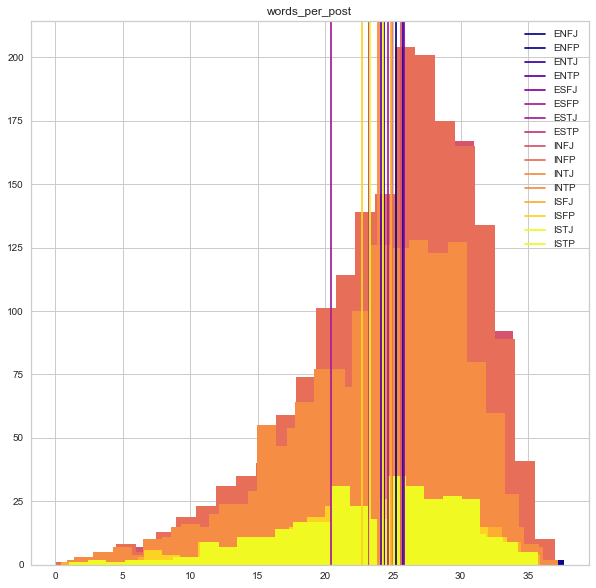

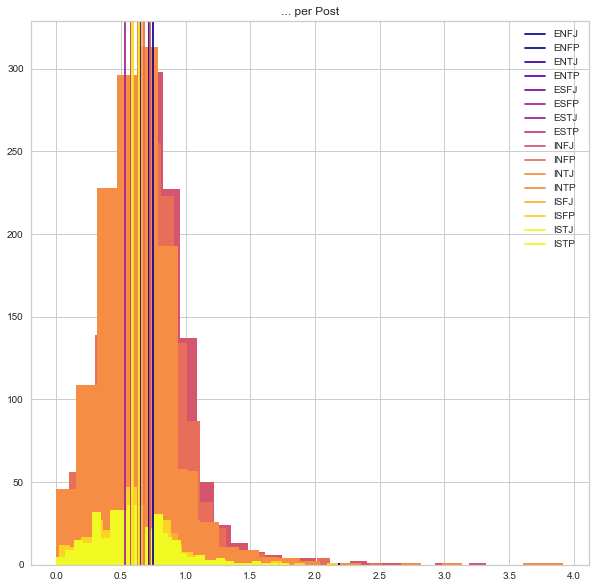

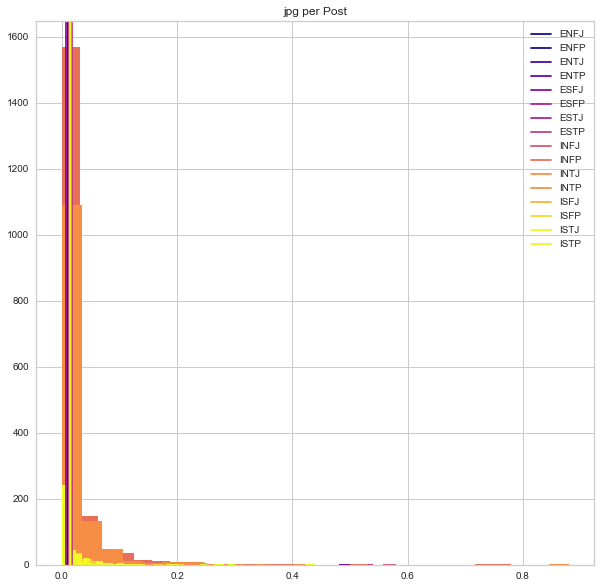

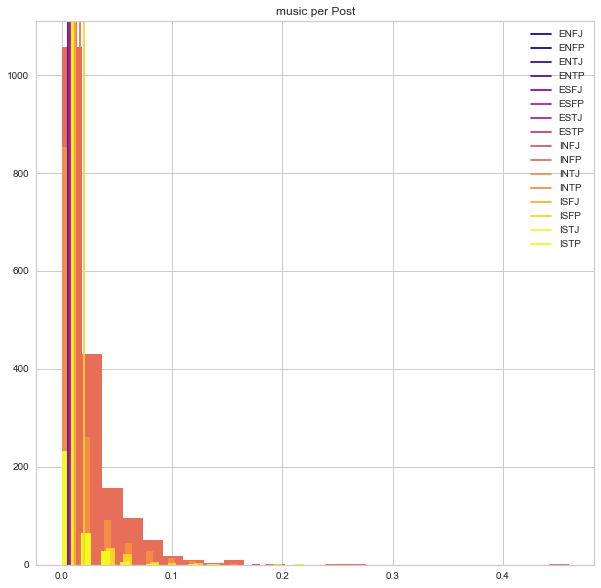

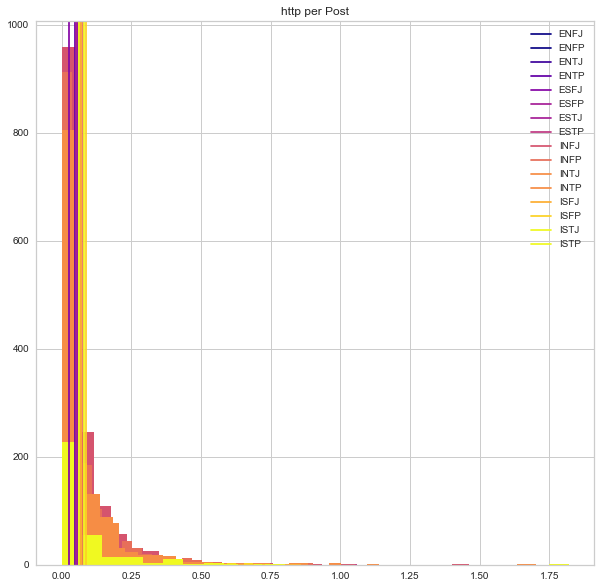

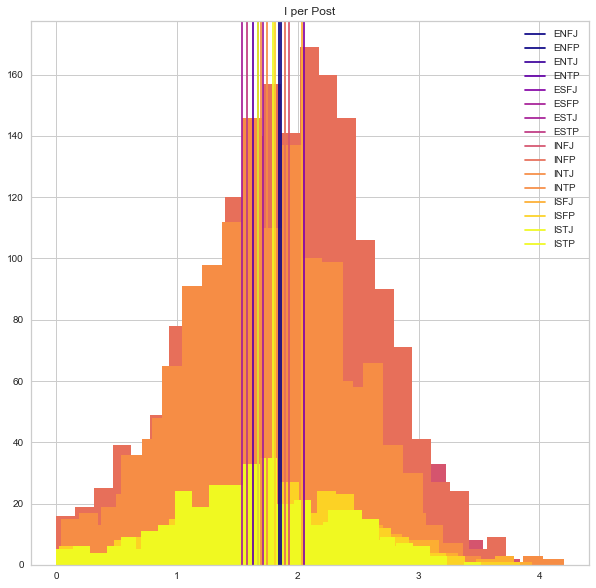

In [43]:
wykres_osobowosci_razem('words_per_post')
wykres_osobowosci_razem('... per Post')
wykres_osobowosci_razem('jpg per Post')
wykres_osobowosci_razem('music per Post')
wykres_osobowosci_razem('http per Post')
wykres_osobowosci_razem('I per Post')

z faktu, że większosc danych sie pokrywa, możemy wnioskowac podobną strukturę. Średnie również nie rożnią się znacząco pomiędzy typami osobowości

Pokażemy osobno każdą Cechę ,żeby to potwierdzić

ENFJ: 25.731789473684206
ENFP: 25.21558518518521
ENTJ: 24.361991341991345
ENTP: 24.12002919708029
ESFJ: 25.81
ESFP: 20.4425
ESTJ: 24.59076923076923
ESTP: 23.25191011235956
INFJ: 25.56888435374151
INFP: 24.891266375545865
INTJ: 23.891732355637053
INTP: 23.95547546012269
ISFJ: 24.82590361445782
ISFP: 22.728265682656826
ISTJ: 24.264487804878044
ISTP: 23.3113353115727


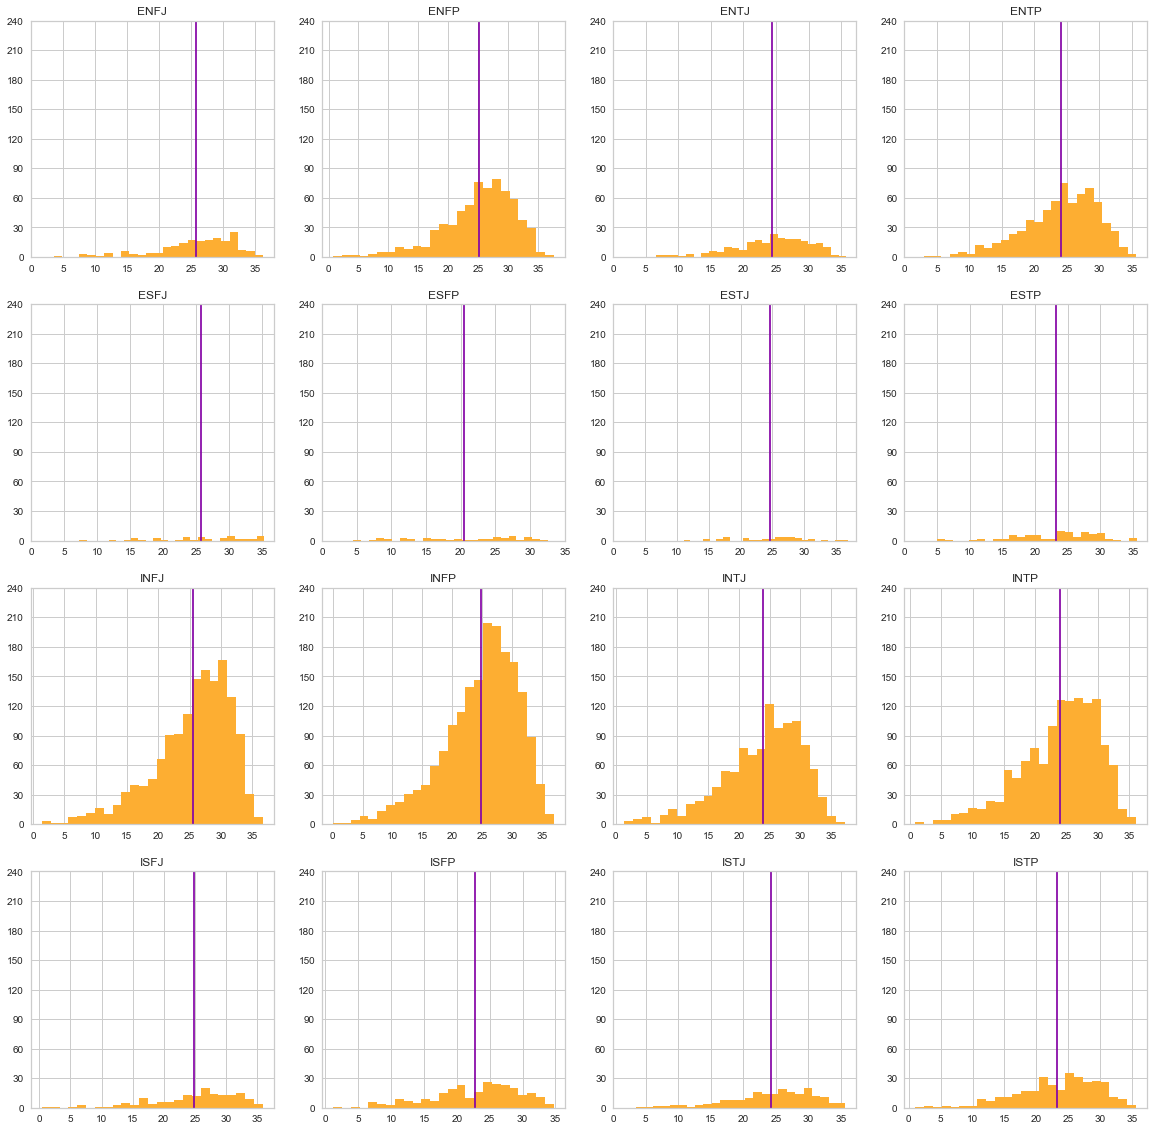

In [44]:
#Ilość słów na post

wykres_osobowosci('words_per_post',tyks=[0,30,60,90,120,150,180,210,240]
)

ENFJ: 0.05326315789473676
ENFP: 0.05045925925925915
ENTJ: 0.05316017316017309
ENTP: 0.048262773722627564
ESFJ: 0.027142857142857146
ESFP: 0.05541666666666667
ESTJ: 0.05282051282051283
ESTP: 0.06471910112359547
INFJ: 0.06587755102040828
INFP: 0.07542576419213985
INTJ: 0.06359303391384065
INTP: 0.07076687116564434
ISFJ: 0.07060240963855414
ISFP: 0.08833948339483383
ISTJ: 0.06117073170731704
ISTP: 0.08100890207715115


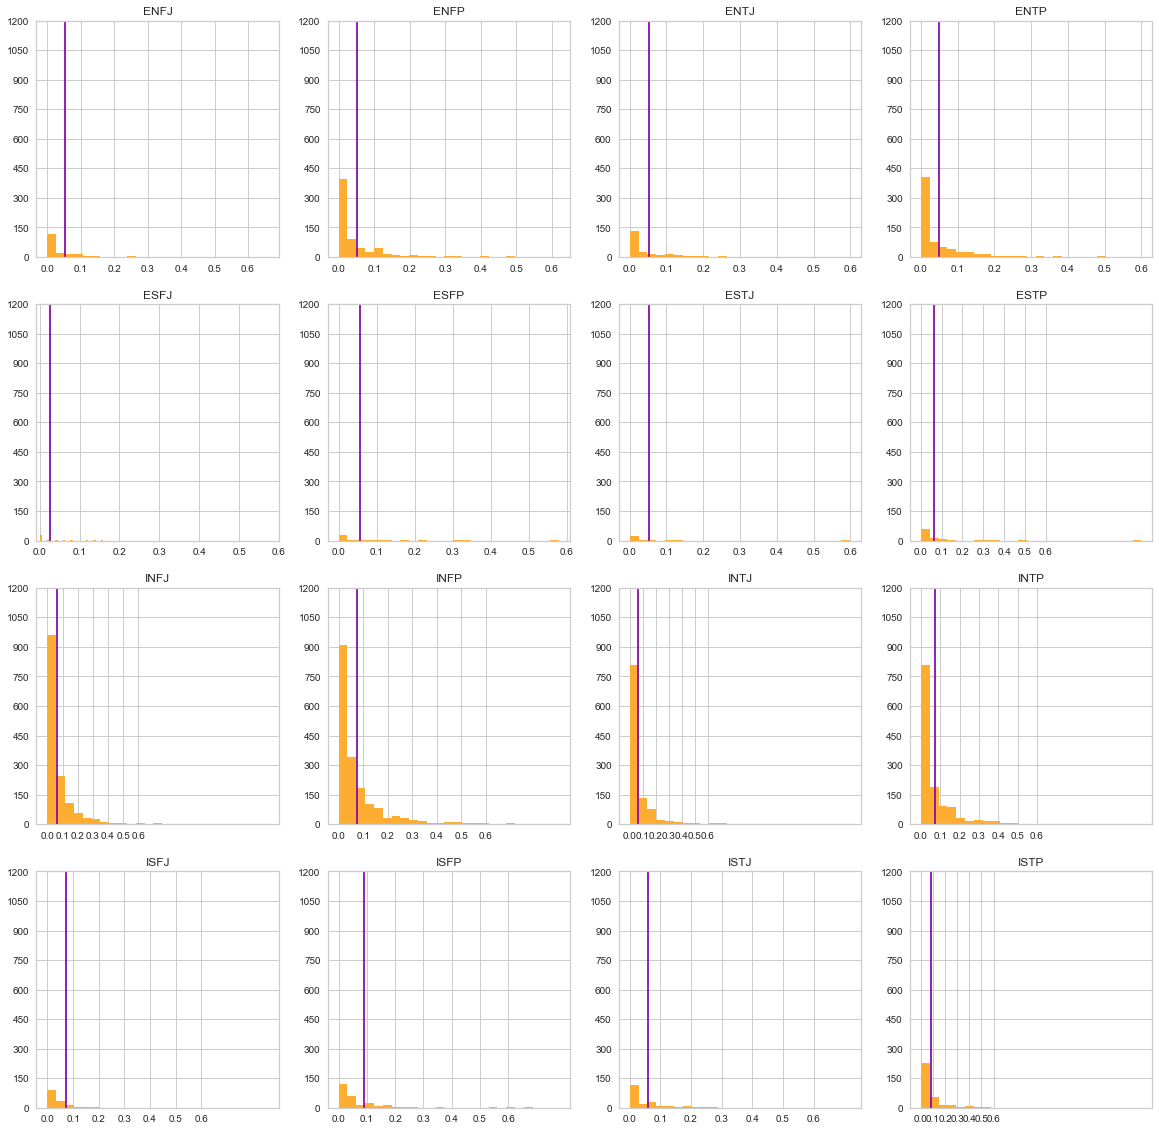

In [45]:
#ilość linków

wykres_osobowosci('http per Post',ticks=(0.0,0.1,0.2,0.3,0.4,0.5,0.6),tyks=[0,150,300,450,600,750,900,1050,1200])


ENFJ: 0.7444210526315788
ENFP: 0.7158814814814816
ENTJ: 0.646666666666667
ENTP: 0.6310364963503654
ESFJ: 0.6385714285714285
ESFP: 0.53375
ESTJ: 0.6307692307692309
ESTP: 0.5775280898876403
INFJ: 0.7214285714285714
INFP: 0.6765938864628811
INTJ: 0.6305407882676447
INTP: 0.6321779141104287
ISFJ: 0.66144578313253
ISFP: 0.5961623616236162
ISTJ: 0.6383414634146342
ISTP: 0.5869436201780414


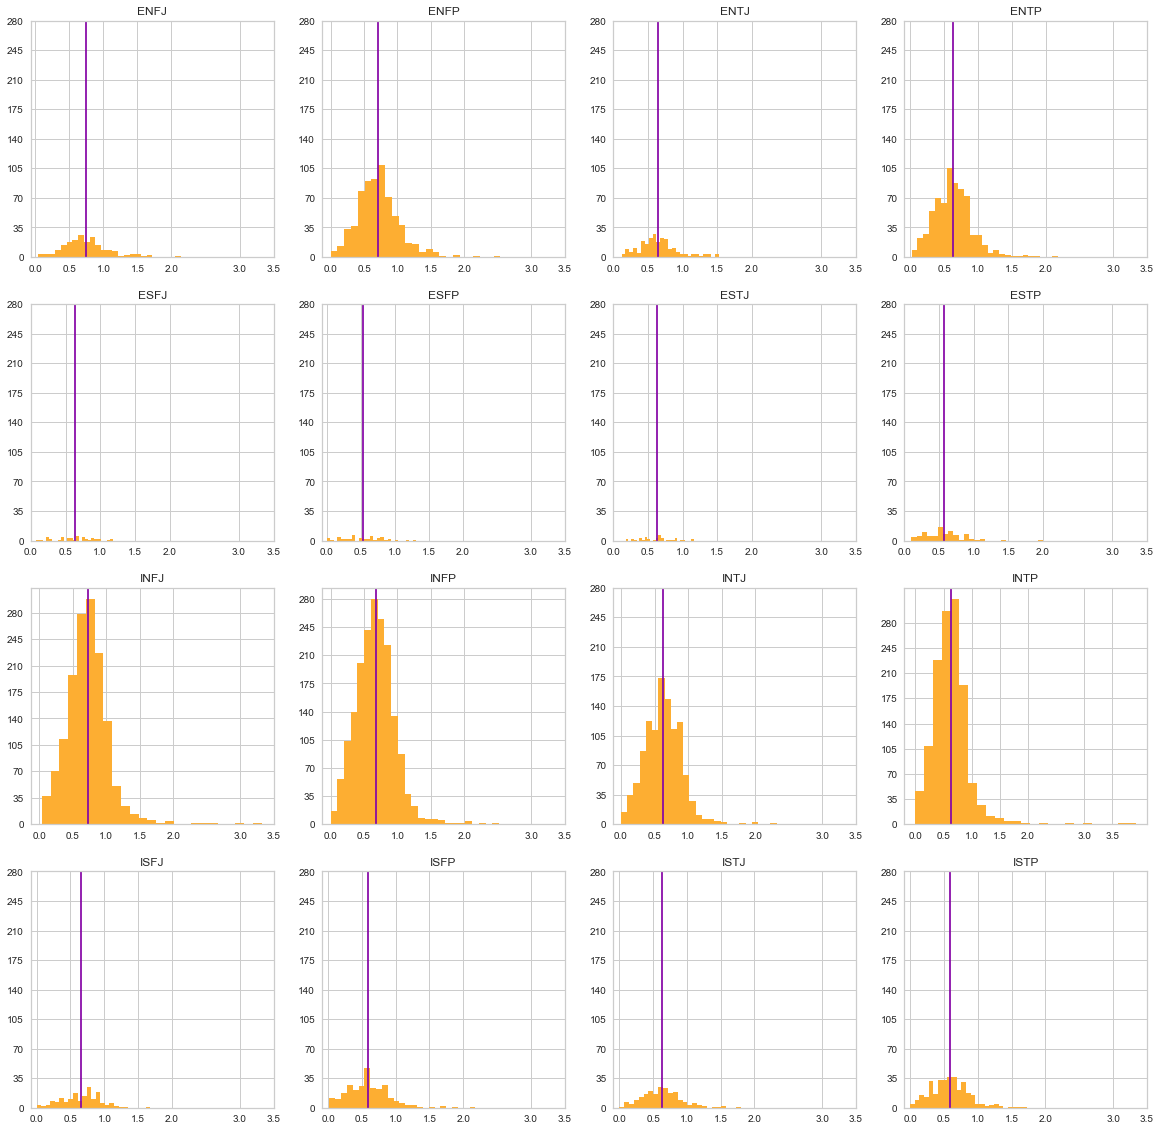

In [46]:
#, ilośc wielokropków

wykres_osobowosci('... per Post',ticks=(0.0,0.5,1.0,1.5,2.0,3.0,3.5),tyks=[0,35,70,105,140,175,210,245,280])


ENFJ: 0.012736842105263164
ENFP: 0.01274074074074069
ENTJ: 0.006147186147186151
ENTP: 0.008671532846715306
ESFJ: 0.007142857142857143
ESFP: 0.007083333333333334
ESTJ: 0.009230769230769232
ESTP: 0.008539325842696632
INFJ: 0.011605442176870663
INFP: 0.01669213973799109
INTJ: 0.009055912007332658
INTP: 0.01277607361963181
ISFJ: 0.011807228915662656
ISFP: 0.020295202952029502
ISTJ: 0.00965853658536586
ISTP: 0.010207715133531164


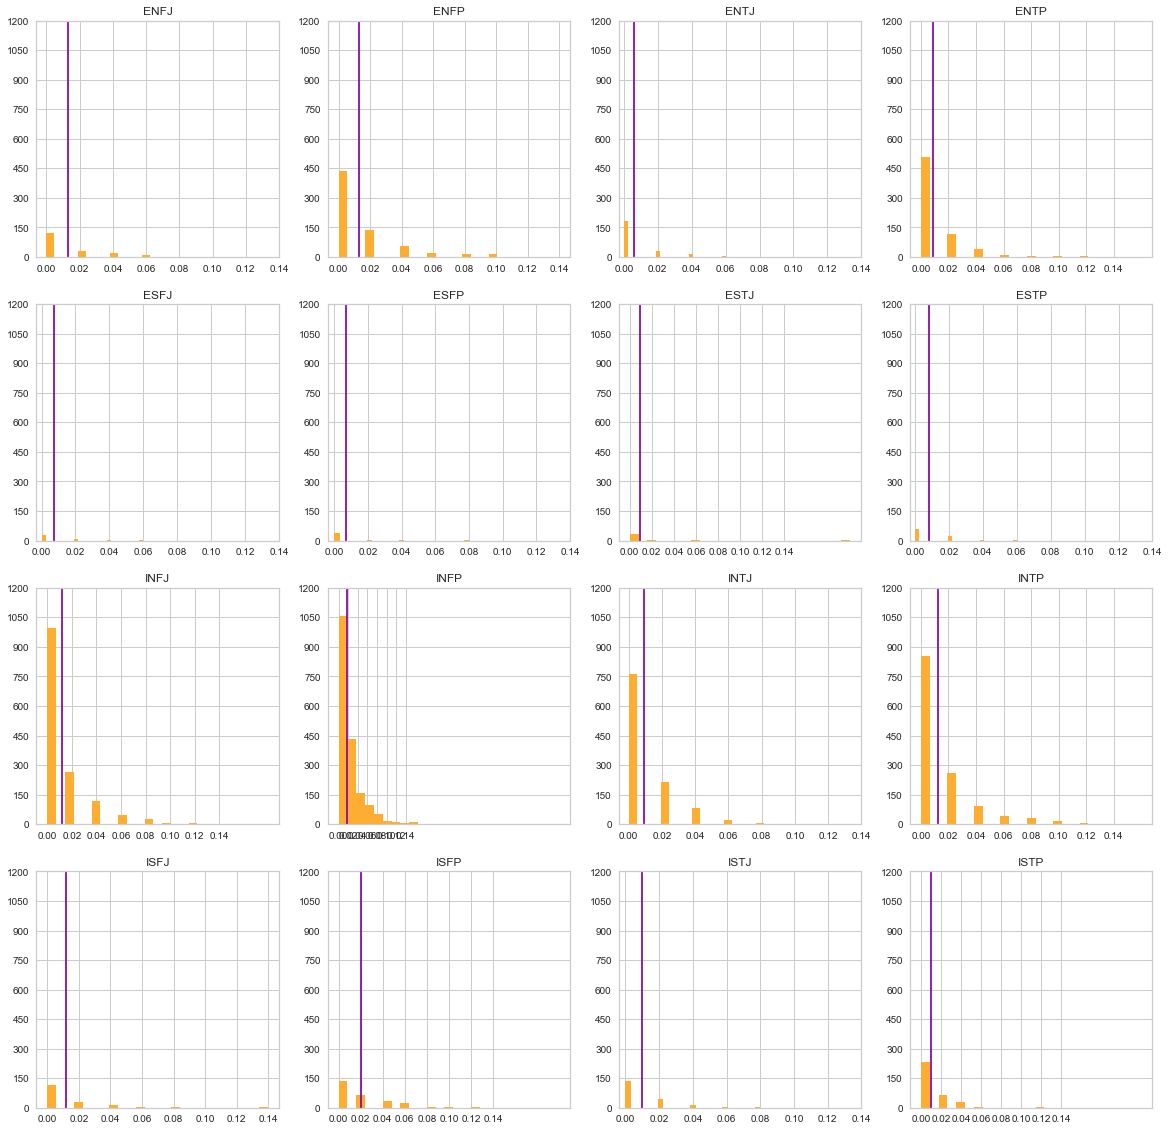

In [47]:
#ilość muzyki

wykres_osobowosci('music per Post',ticks=(0.0,0.02,0.04,0.06,0.08,0.10,0.12,0.14),tyks=[0,150,300,450,600,750,900,1050,1200])


ENFJ: 0.011578947368421057
ENFP: 0.01054814814814813
ENTJ: 0.012987012987012993
ENTP: 0.012729927007299227
ESFJ: 0.006666666666666667
ESFP: 0.012500000000000002
ESTJ: 0.01230769230769231
ESTP: 0.01752808988764045
INFJ: 0.012571428571428513
INFP: 0.015534934497816512
INTJ: 0.01470210815765347
INTP: 0.015720858895705434
ISFJ: 0.013975903614457838
ISFP: 0.014612546125461263
ISTJ: 0.013365853658536594
ISTP: 0.014005934718100887


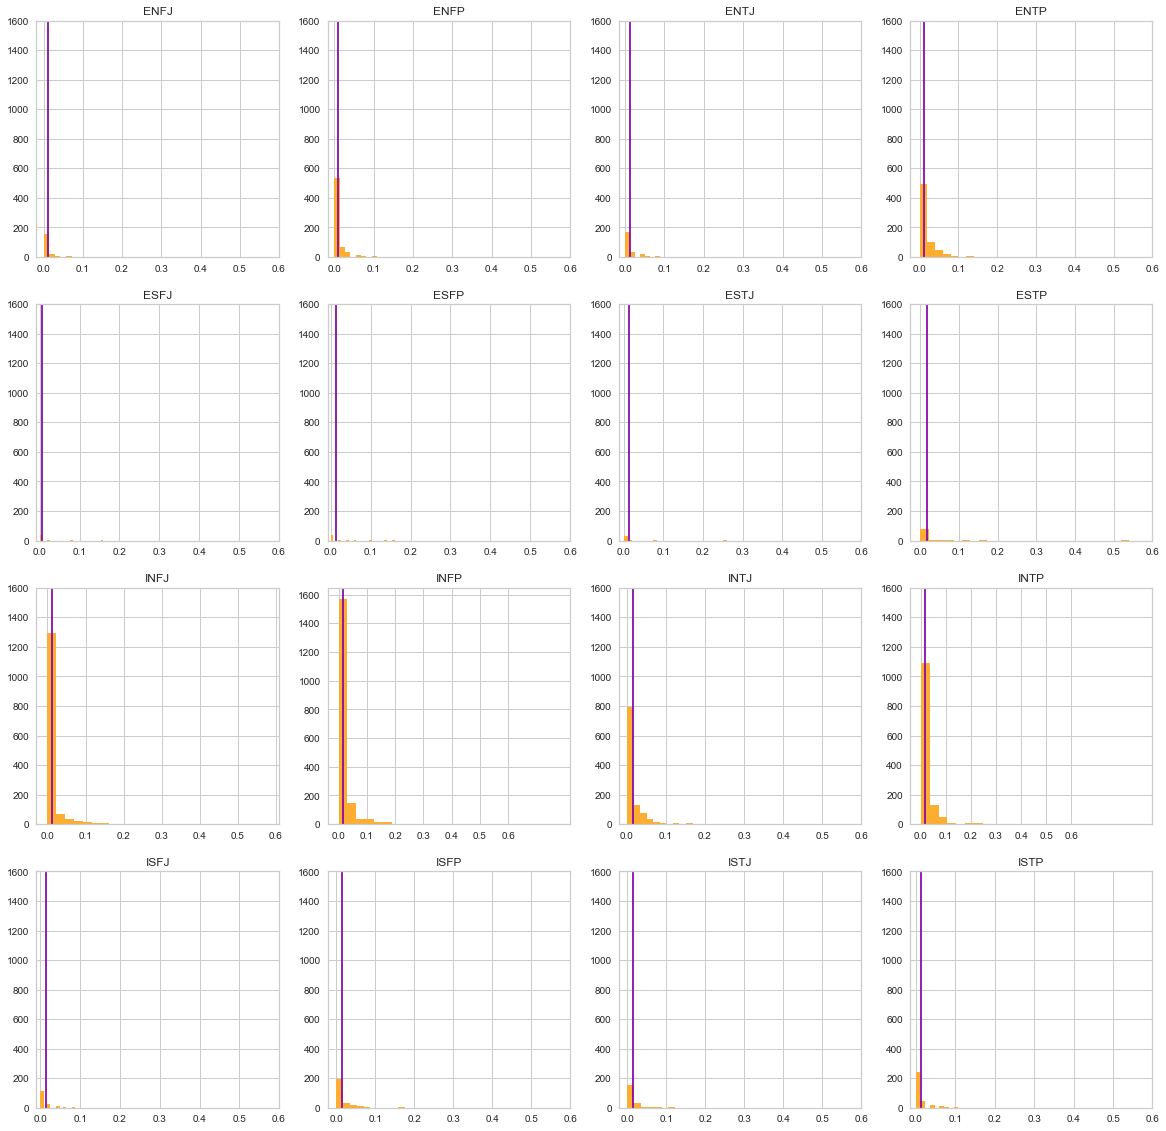

In [48]:
#, ilość jpgów

wykres_osobowosci('jpg per Post',ticks=(0.0,0.1,0.2,0.3,0.4,0.5,0.6),tyks=[0,200,400,600,800,1000,1200,1400,1600])


ENFJ: 1.8402105263157906
ENFP: 1.8632592592592594
ENTJ: 1.6726406926406912
ENTP: 1.629489051094891
ESFJ: 2.0476190476190474
ESFP: 1.5391666666666663
ESTJ: 1.7133333333333336
ESTP: 1.5795505617977532
INFJ: 1.9290884353741473
INFP: 1.8969759825327506
INTJ: 1.6979101741521536
INTP: 1.7457822085889572
ISFJ: 2.0307228915662647
ISFP: 1.8080442804428034
ISTJ: 1.7922926829268289
ISTP: 1.6734718100890196


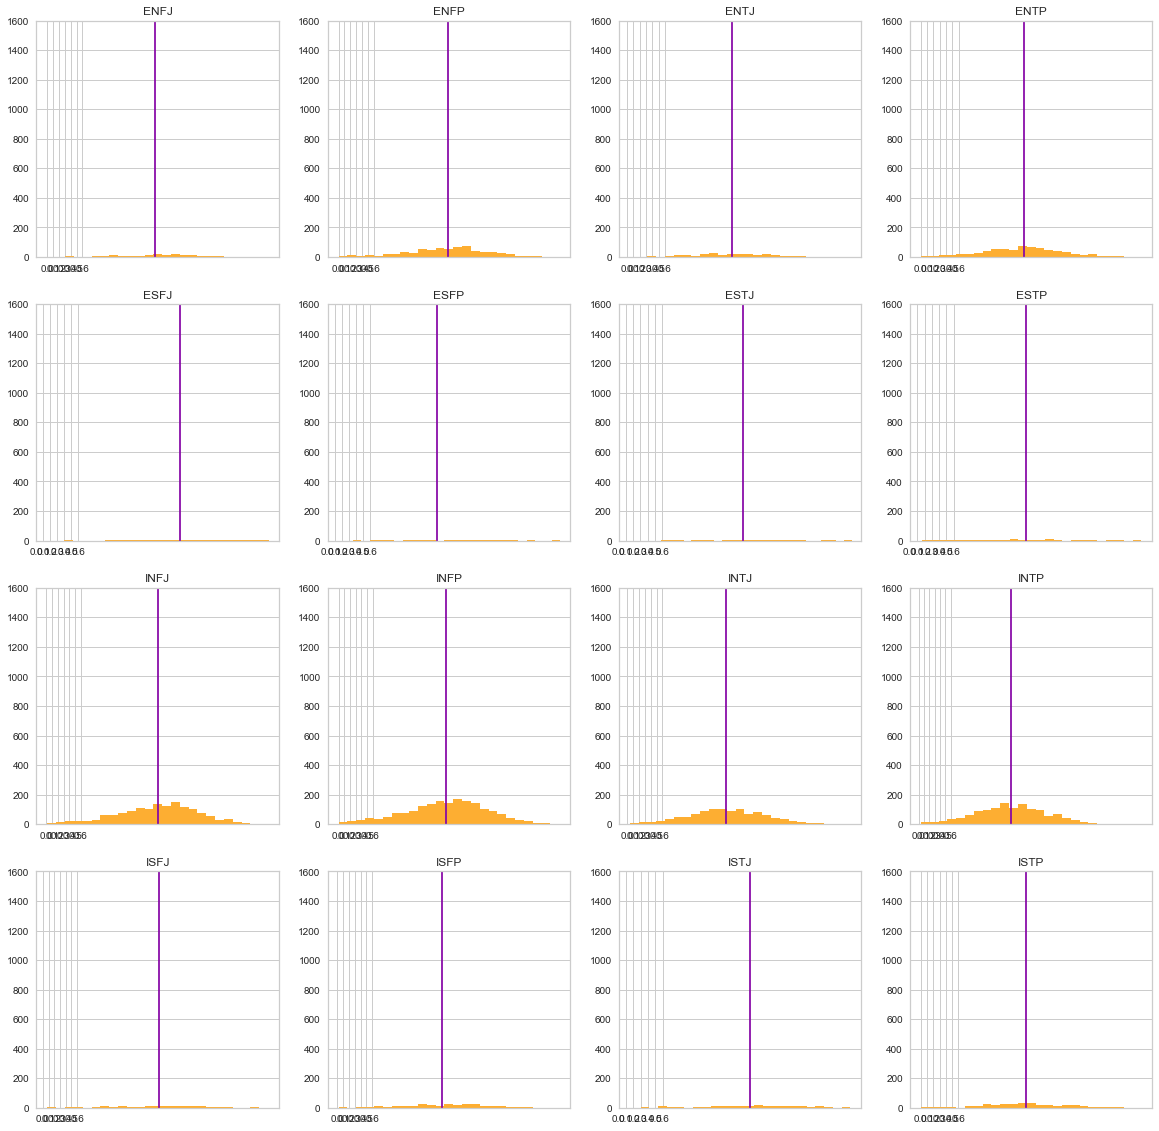

In [49]:
#, ilość użycia 'I'

wykres_osobowosci('I per Post',ticks=(0.0,0.1,0.2,0.3,0.4,0.5,0.6),tyks=[0,200,400,600,800,1000,1200,1400,1600])


#### Selekcja istotnych Cech

In [15]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2

XX = df.drop(['type','posts'], axis=1).values
yy = df['type'].values

print(XX.shape)
print(yy.shape)

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(XX,yy,test_size = 0.1, random_state=42)



bestfeatures = SelectKBest(score_func=chi2, k=6)
fit = bestfeatures.fit(X_train,y_train)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(df.drop(['type','posts'], axis=1).columns)

featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(6,'Score'))  #print best features

(8675, 6)
(8675,)
            Specs       Score
0  words_per_post  219.272107
5      I per Post   54.593654
1    ... per Post   22.173564
2   http per Post   13.328238
3  music per Post    6.382853
4    jpg per Post    1.907333


Okazuje się że jpg w ogóle nie mają znaczenia a użycie słowa music również nie róznicuje grup

In [18]:
df.drop(['type','posts'], axis=1).corr()

,words_per_post,... per Post,http per Post,music per Post,jpg per Post,I per Post
words_per_post,1.000000,0.694532,-0.420049,0.045314,-0.229499,0.709836
... per Post,0.694532,1.000000,-0.245076,0.026490,-0.120342,0.465793
http per Post,-0.420049,-0.245076,1.000000,0.089092,0.539560,-0.294472
music per Post,0.045314,0.026490,0.089092,1.000000,0.003052,0.064607
jpg per Post,-0.229499,-0.120342,0.539560,0.003052,1.000000,-0.173834
I per Post,0.709836,0.465793,-0.294472,0.064607,-0.173834,1.000000


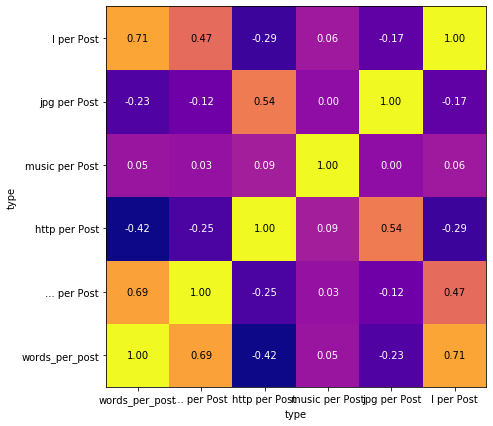

In [42]:
plt.figure(figsize = (7,7))
heatmap(df.drop(['type','posts'], axis=1).corr(), xlabel = 'type', ylabel ='type', xticklabels=['words_per_post','... per Post','http per Post','music per Post','jpg per Post','I per Post'], yticklabels= ['words_per_post','... per Post','http per Post','music per Post','jpg per Post','I per Post'], cmap='plasma',
            vmin=None, vmax=None, ax=None, fmt="%0.2f")

Wynika z tego że najbardziej istotne będą cechy: words per post, ... per post oraz I per post

**Dalsza Analiza pokazał jednak znikomy wpływ selekcji cech na wydajność modelu**

### rozpoznanie osobowości MBTI --> pokazanie koniecznośc Resamplingu


In [35]:
XX = df.drop(['type','posts'], axis=1).values
yy = df['type'].values

print(XX.shape)
print(yy.shape)

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(XX,yy,test_size = 0.1, random_state=42)


(8675, 6)
(8675,)
(868, 6)


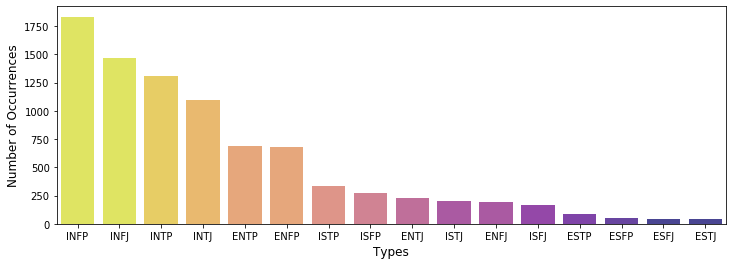

In [23]:

#Wizualizacja udziału Klas

from matplotlib import cm

cnt_srs = df['type'].value_counts()
viridis = cm.get_cmap('plasma', 12)
colors = viridis(np.flip(np.linspace(0, 1, 16)))
plt.figure(figsize=(12,4))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8,palette=colors)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Types', fontsize=12)
plt.show()

In [41]:
#Przykładowy model --> jeden ze zwróconych przez Grid

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

logreg3 = SVC(kernel ='rbf', gamma= 0.1, C=0.1,probability = True)
logreg3.fit(X_train[:,[0,1,5]],y_train)


from sklearn import metrics

print(metrics.accuracy_score(y_test, logreg3.predict(X_test[:,[0,1,5]])))
print(metrics.f1_score(y_test, logreg3.predict(X_test[:,[0,1,5]]),average='micro'))

0.20046082949308755
0.20046082949308755


Bez Selekcji;

    0.20046082949308755
    0.20046082949308755

In [46]:
print("R^2: {}".format(metrics.precision_score(y_test, logreg3.predict(X_test[:,[0,1,5]]),average='macro') ))
print("recall_score: {}".format( metrics.recall_score(y_test, logreg3.predict(X_test[:,[0,1,5]]),average='macro') ))
print("f1_score: {}".format( metrics.f1_score(y_test, logreg3.predict(X_test[:,[0,1,5]]),average='macro') ))
print("accuracy_score: {}".format( metrics.accuracy_score(y_test, logreg3.predict(X_test[:,[0,1,5]])) ))

C:\Program Files (x86)\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


R^2: 0.012528801843317972
recall_score: 0.0625
f1_score: 0.02087332053742802
accuracy_score: 0.20046082949308755


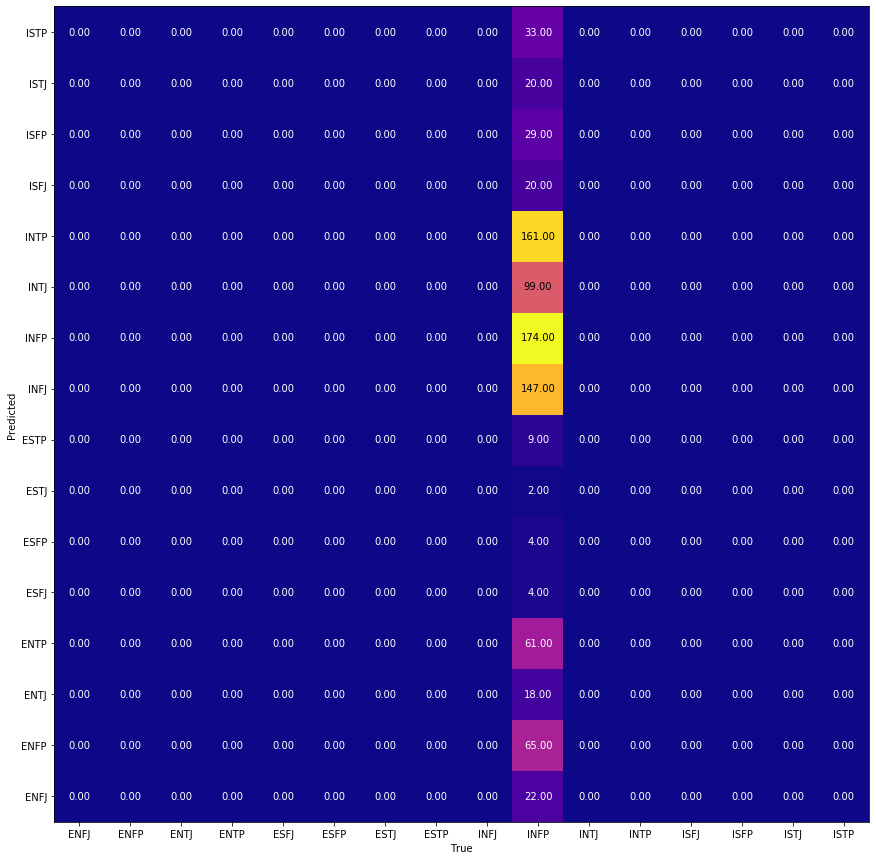

In [39]:
#print(metrics.confusion_matrix(y_test, logreg3.predict(X_test[:,[0,1,2,3,5]])))
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array =metrics.confusion_matrix(y_test, logreg3.predict(X_test))

personality_types = np.unique(y_test)

df_cm = pd.DataFrame(array, index = [i for i in personality_types],
                  columns = [i for i in personality_types])

plt.figure(figsize = (15,15))
heatmap(array, xlabel='True', xticklabels=personality_types, ylabel='Predicted', yticklabels=personality_types, cmap="plasma")
plt.show()

Jak Widać przydzielono tylko i wyłącznie do jednej klasy

### Resampling 

In [43]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE

XX = df.drop(['type','posts'], axis=1).values
yy = df['type'].values

print(XX.shape)
print(yy.shape)

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(XX,yy,test_size = 0.1, random_state=42)

nm1 = NearMiss(version=1)
sm = SMOTE()
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
#X_test_res, y_test_res = sm.fit_sample(X_test, y_test)

#print(y_train_res)
print(y_test.shape)

C:\Program Files (x86)\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


(8675, 6)
(8675,)
(868,)


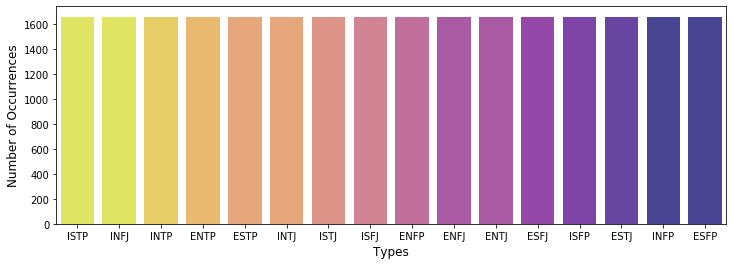

In [44]:
#Wizualizacja Zresamplowanych Klas

df_res = pd.DataFrame(X_train_res)
df_res.columns = ['words_per_post','... per Post','http per Post','music per Post','jpg per Post','I per Post']
df_res["type"] = y_train_res


cnt_srs = df_res["type"].value_counts()
viridis = cm.get_cmap('plasma', 12)
colors = viridis(np.flip(np.linspace(0, 1, 16)))
plt.figure(figsize=(12,4))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8,palette=colors)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Types', fontsize=12)
plt.show()

In [54]:
#Feature Selection

import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2


#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=6)
fit = bestfeatures.fit(X_train_res,y_train_res)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(df.drop(['type','posts'], axis=1).columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(6,'Score'))  #print 10 best features

            Specs        Score
0  words_per_post  1766.115205
5      I per Post   298.005149
1    ... per Post   105.801881
2   http per Post    79.466595
3  music per Post    25.600825
4    jpg per Post    10.796224


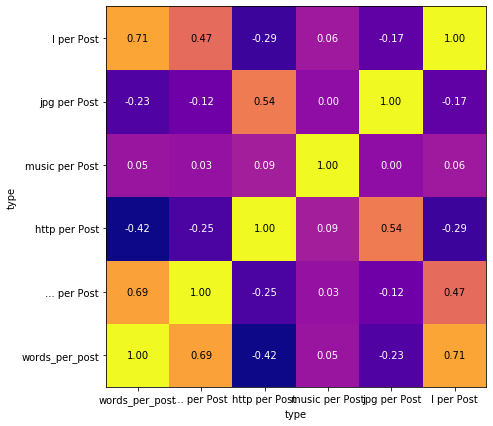

In [51]:
plt.figure(figsize = (7,7))
heatmap(df.drop(['type','posts'], axis=1).corr(), xlabel = 'type', ylabel ='type', xticklabels=['words_per_post','... per Post','http per Post','music per Post','jpg per Post','I per Post'], yticklabels= ['words_per_post','... per Post','http per Post','music per Post','jpg per Post','I per Post'], cmap='plasma',
            vmin=None, vmax=None, ax=None, fmt="%0.2f")

3 bajważniejsze Cechy nie zmeniły się

In [45]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics


XX = df.drop(['type','posts'], axis=1).values
yy = df['type'].values

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(XX,yy,test_size = 0.1, random_state=42)

sm = SMOTE()
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

In [50]:
#Best Clssificator:
from sklearn.ensemble import ExtraTreesClassifier
Classif_res_Type = ExtraTreesClassifier(max_leaf_nodes = 64, n_estimators = 400)
Classif_res_Type.fit(X_train_res, y_train_res)

from sklearn import metrics

print("R^2: {}".format(metrics.precision_score(y_test, Classif_res_Type.predict(X_test),average='macro') ))
print("recall_score: {}".format( metrics.recall_score(y_test, Classif_res_Type.predict(X_test),average='macro') ))
print("f1_score: {}".format( metrics.f1_score(y_test, Classif_res_Type.predict(X_test),average='macro') ))
print("accuracy_score: {}".format( metrics.accuracy_score(y_test, Classif_res_Type.predict(X_test)) ))

R^2: 0.06343662450384041
recall_score: 0.0940658819800082
f1_score: 0.055772236475589904
accuracy_score: 0.08064516129032258


Selekcja Cech:

    R^2: 0.06337332946630916
    recall_score: 0.057190302764957616
    f1_score: 0.03632682063032406
    accuracy_score: 0.038018433179723504

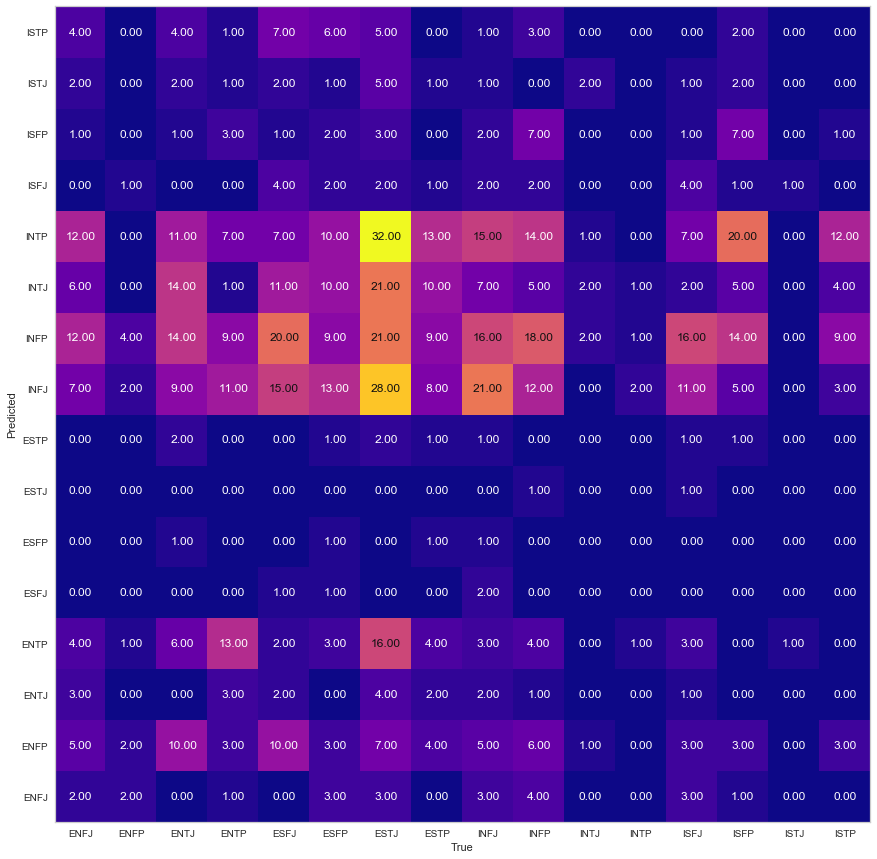

In [59]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array =metrics.confusion_matrix(y_test, Classif_res_Type.predict(X_test[:,[0,1,5]]))

personality_types = np.unique(y_test)

df_cm = pd.DataFrame(array, index = [i for i in personality_types],
                  columns = [i for i in personality_types])

plt.figure(figsize = (15,15))
heatmap(array, xlabel='True', xticklabels=personality_types, ylabel='Predicted', yticklabels=personality_types, cmap="plasma")
plt.show() 

Klasyfikacja Typów osobowości osiąga żałosne rezultaty: Sprawdźmy czy jeśli nie wybierzemy Cech manualnie coś się zmieni!

### Automatyczna Selekcja Cech

In [53]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from bs4 import BeautifulSoup
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import GridSearchCV


In [54]:

#Czyścimy zbiór Danych z  niepotrzebnych linków itp.

def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    return text
df['clean_posts'] = df['posts'].apply(cleanText)


In [55]:
XX = df['clean_posts'].values
yy = df['type'].values

print(XX.shape)
print(yy.shape)

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(XX,yy,test_size = 0.1, random_state=42)

tfidf = TfidfVectorizer(ngram_range=(1, 1), stop_words='english')
tsvd = TruncatedSVD(n_components=10)


(8675,)
(8675,)


In [56]:
#Przeprowadzamy Text Mining oraz Skalowanie danych i redukcje wymiarów

TfidVect  = tfidf.fit_transform(X_train)
svd_model = tsvd
data_revitalised_train = svd_model.fit_transform(TfidVect)



C:\Program Files (x86)\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


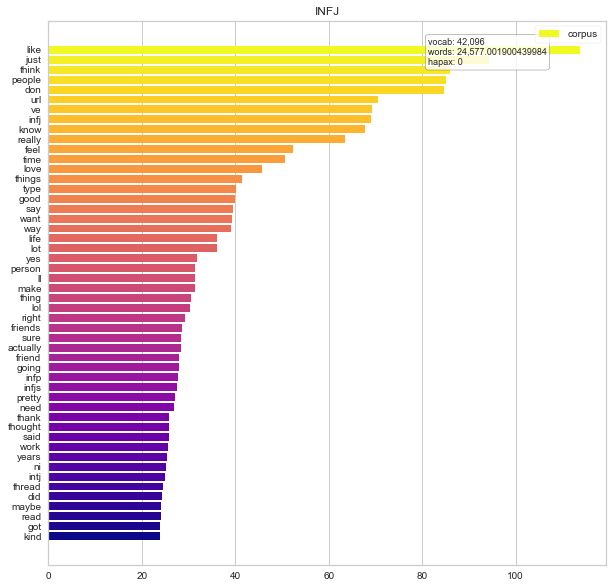

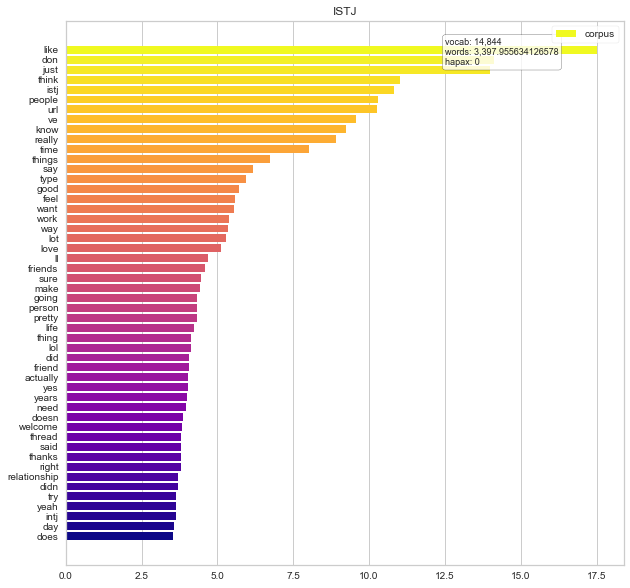

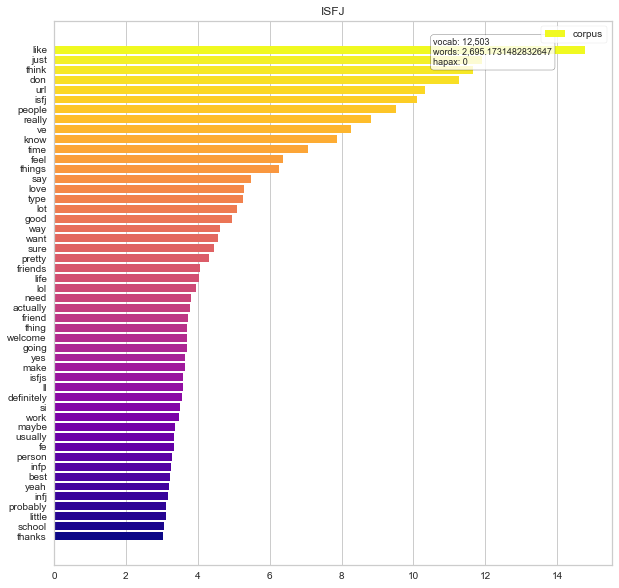

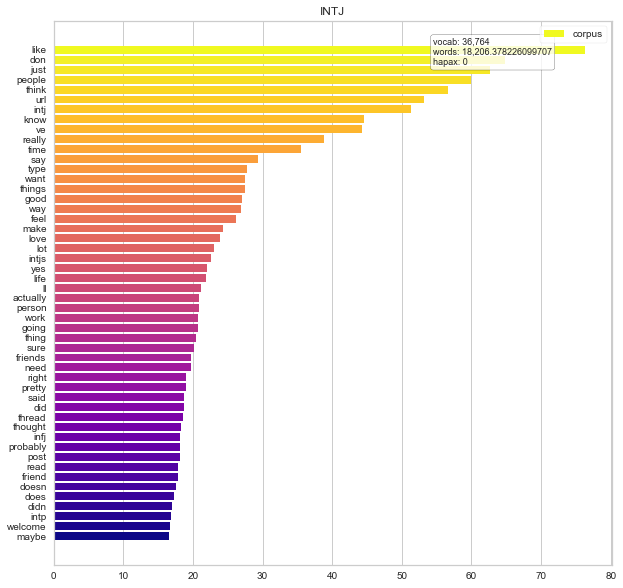

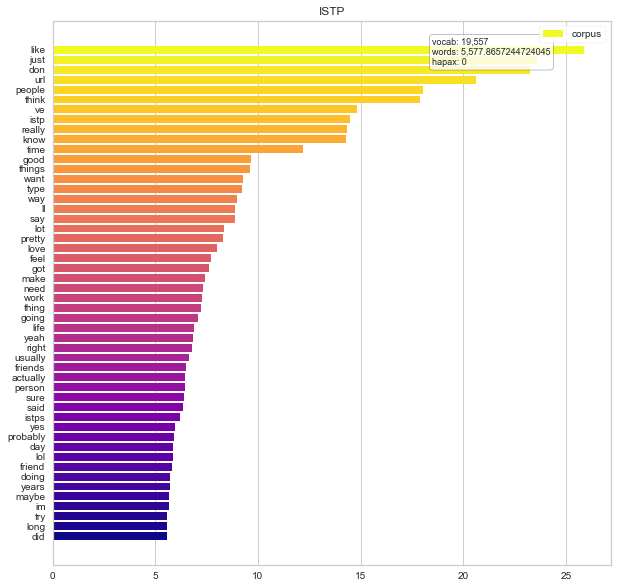

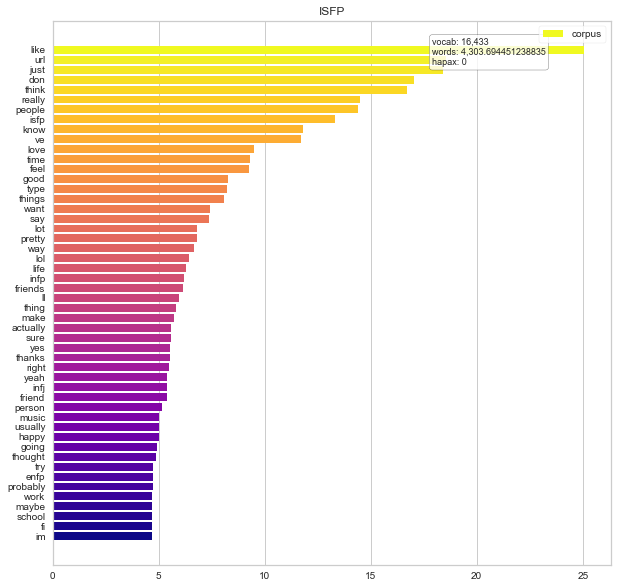

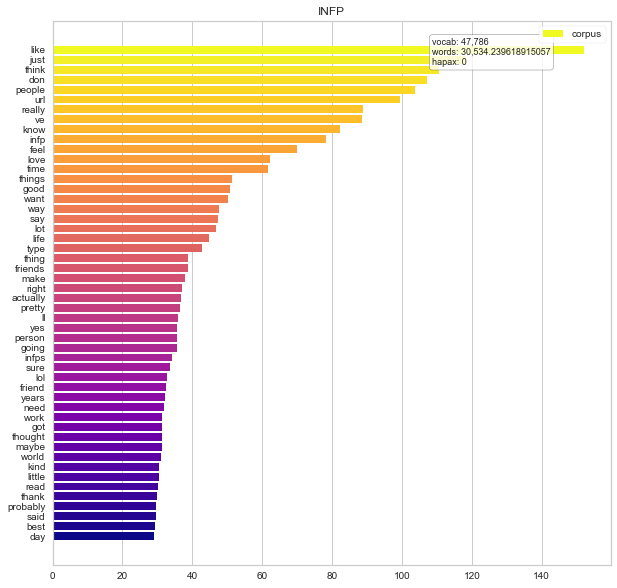

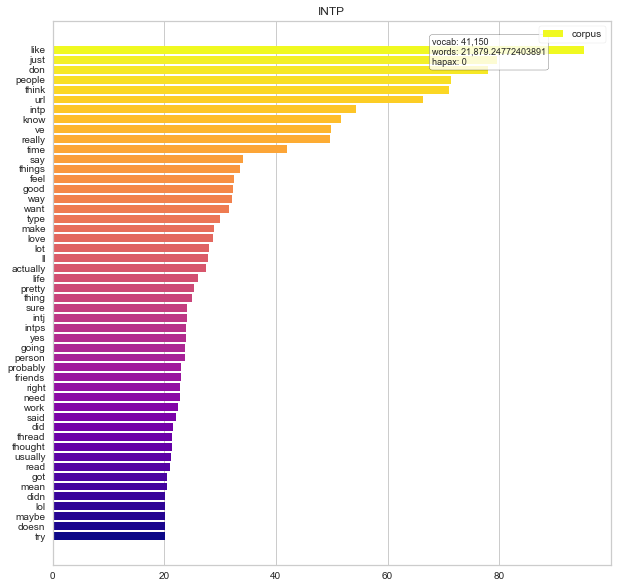

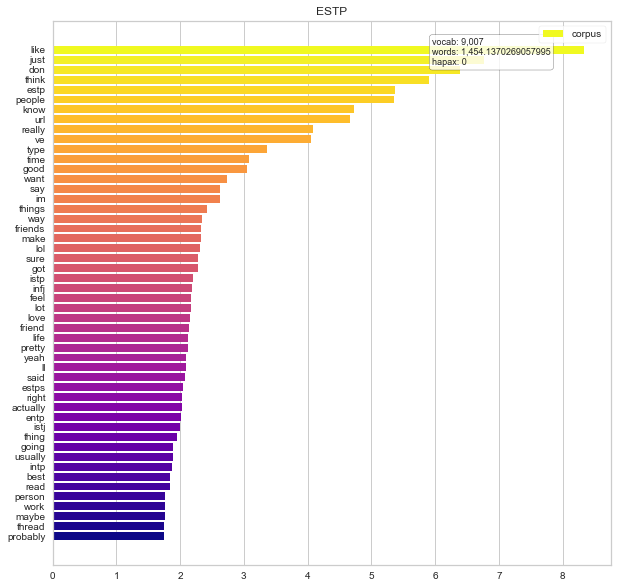

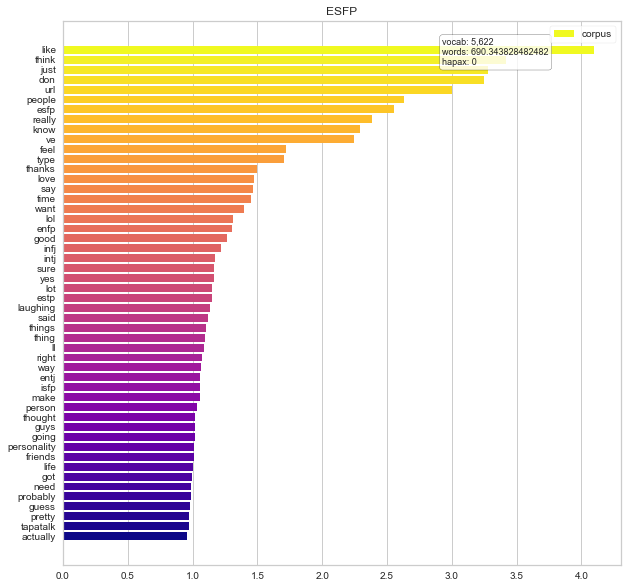

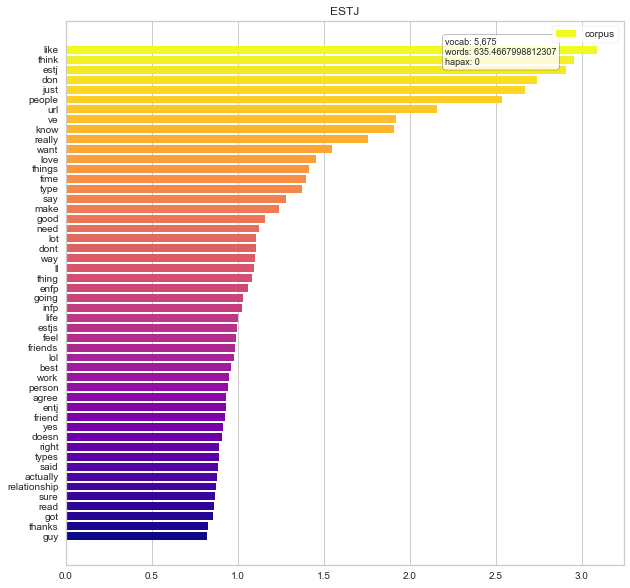

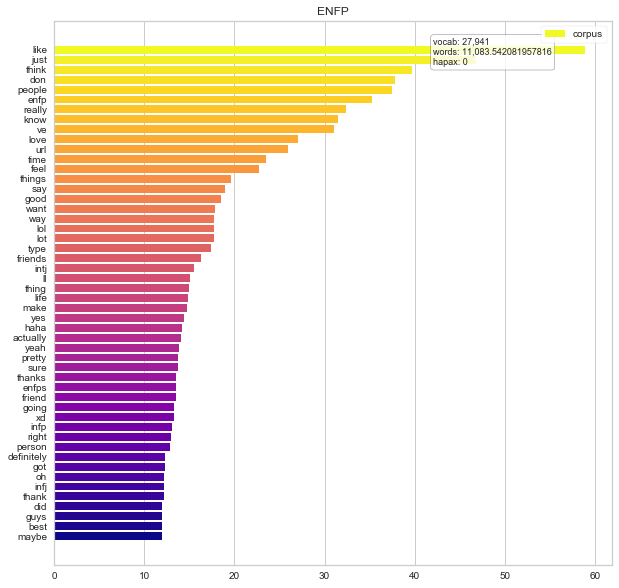

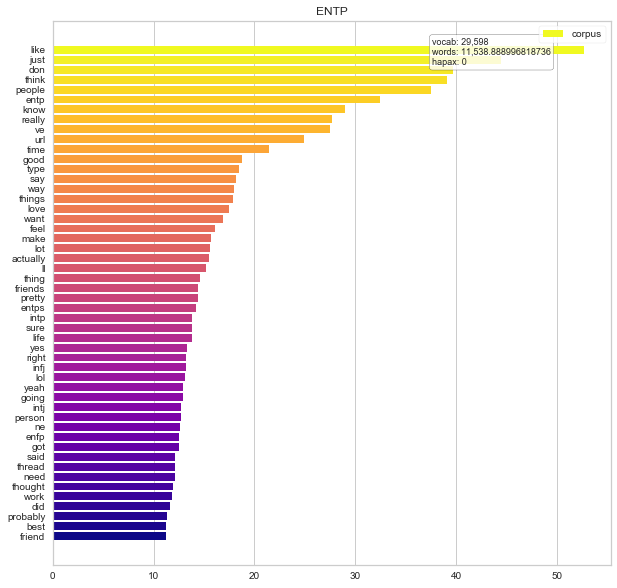

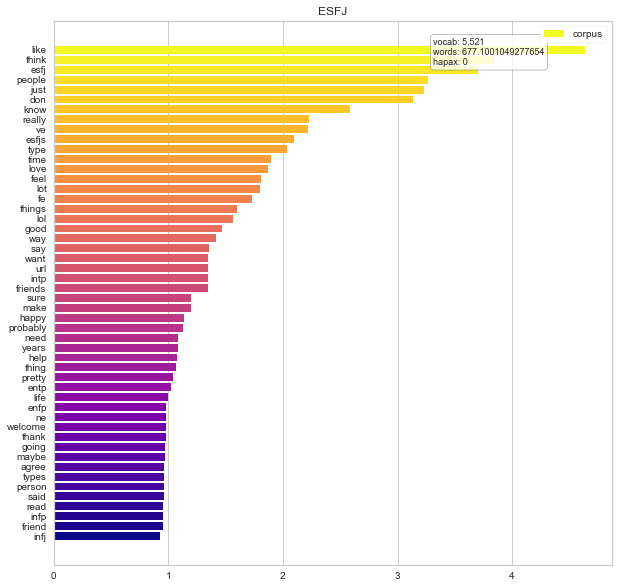

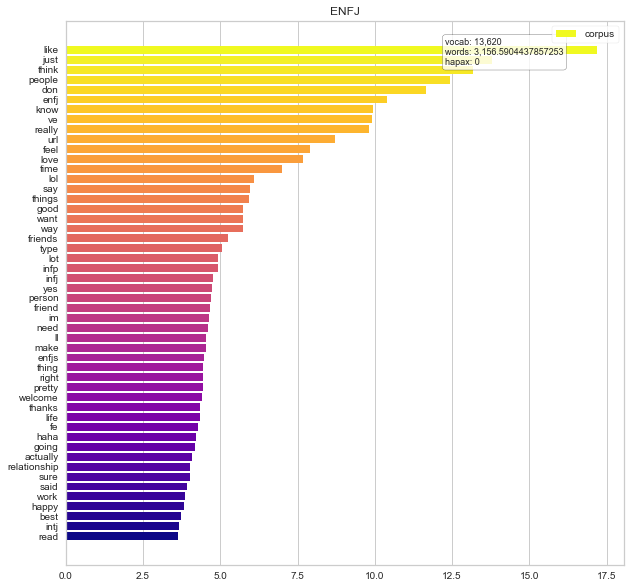

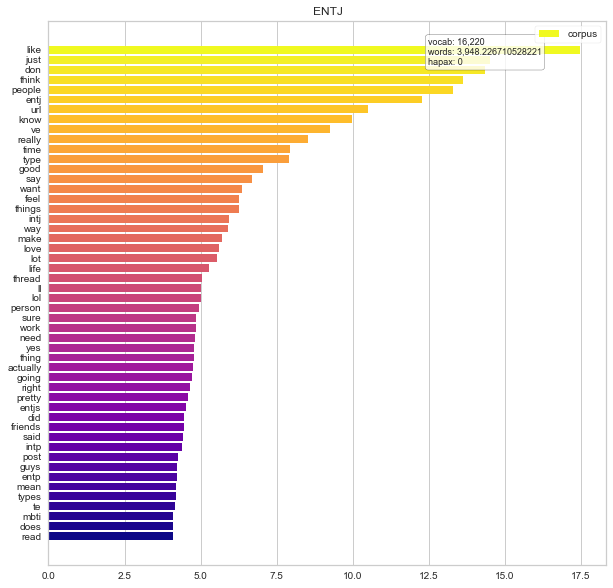

In [57]:
from sklearn.feature_extraction.text import CountVectorizer
from yellowbrick.text import FreqDistVisualizer

def Most_frequent_words_in_Group(types):
    XXX = df['clean_posts'].loc[df["type"] == types].values
    
    from matplotlib import cm

    cnt_srs = df['type'].value_counts()
    viridis = cm.get_cmap('plasma', 50)
    colors = viridis(np.flip(np.linspace(0, 1, 50)))
    
    TfidVect  = tfidf.fit_transform(XXX)
    svd_model = tsvd
    data_revitalised = svd_model.fit_transform(TfidVect)
    plt.figure(figsize = (10,10))
    visualizer = FreqDistVisualizer(features=tfidf.get_feature_names(), orient='h',title =types, color = colors)
    visualizer.fit(TfidVect)
    #visualizer.title(types)
    visualizer.show()
    
    
    
Most_frequent_words_in_Group('INFJ')
Most_frequent_words_in_Group('ISTJ')
Most_frequent_words_in_Group('ISFJ')
Most_frequent_words_in_Group('INTJ')
Most_frequent_words_in_Group('ISTP')
Most_frequent_words_in_Group('ISFP')
Most_frequent_words_in_Group('INFP')
Most_frequent_words_in_Group('INTP')
Most_frequent_words_in_Group('ESTP')
Most_frequent_words_in_Group('ESFP')
Most_frequent_words_in_Group('ESTJ')
Most_frequent_words_in_Group('ENFP')
Most_frequent_words_in_Group('ENTP')
Most_frequent_words_in_Group('ESFJ')
Most_frequent_words_in_Group('ENFJ')
Most_frequent_words_in_Group('ENTJ')




Analiza tfiDF wskazuje na podobne częstosci wystepywania tych samych słów  w poszczególnych Typach

In [59]:
XX = df['clean_posts'].values
yy = df['type'].values

print(XX.shape)
print(yy.shape)

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(XX,yy,test_size = 0.1, random_state=42)

tfidf = TfidfVectorizer(ngram_range=(1, 1), stop_words='english')
tsvd = TruncatedSVD(n_components=10)

#Przeprowadzamy Text Mining oraz Skalowanie danych i redukcje wymiarów

TfidVect  = tfidf.fit_transform(X_train)
svd_model = tsvd
data_revitalised_train = svd_model.fit_transform(TfidVect)

TfidVect_test  = tfidf.fit_transform(X_test)
svd_model_test = tsvd
data_revitalised_test = svd_model_test.fit_transform(TfidVect_test)

sm = SMOTE()
X_train_res, y_train_res = sm.fit_sample(data_revitalised_train, y_train)


(8675,)
(8675,)


In [67]:
#Best Clssificators:

Classif_res_Automatic_IE = ExtraTreesClassifier(max_leaf_nodes = 128, n_estimators = 1000)
Classif_res_Automatic_IE.fit(X_train_res, y_train_res)

from sklearn import metrics

print("R^2: {}".format(metrics.precision_score(y_test, Classif_res_Automatic_IE.predict(data_revitalised_test),average='macro') ))
print("recall_score: {}".format( metrics.recall_score(y_test, Classif_res_Automatic_IE.predict(data_revitalised_test),average='macro') ))
print("f1_score: {}".format( metrics.f1_score(y_test, Classif_res_Automatic_IE.predict(data_revitalised_test),average='macro') ))
print("accuracy_score: {}".format( metrics.accuracy_score(y_test, Classif_res_Automatic_IE.predict(data_revitalised_test)) ))

R^2: 0.06259669264384313
recall_score: 0.05892457884289471
f1_score: 0.04603408618083722
accuracy_score: 0.07142857142857142


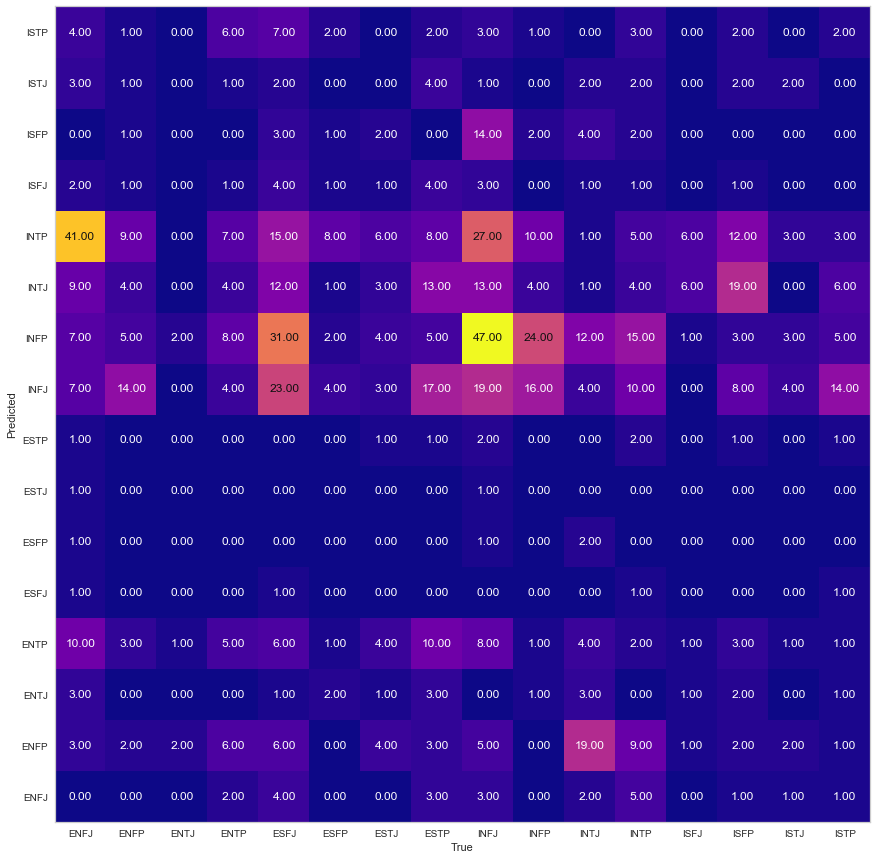

In [69]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array =metrics.confusion_matrix(y_test, Classif_res_Automatic_IE.predict(data_revitalised_test))

personality_types = np.unique(y_test)

df_cm = pd.DataFrame(array, index = [i for i in personality_types],
                  columns = [i for i in personality_types])

plt.figure(figsize = (15,15))
heatmap(array, xlabel='True', xticklabels=personality_types, ylabel='Predicted', yticklabels=personality_types, cmap="plasma")
plt.show() 

Jak widać nie zdaje to Egzaminu:

## Poszczególne Cechy --> Klasyfikacja z Resamplingiem!

In [70]:
map1 = {"I": 0, "E": 1}
map2 = {"N": 0, "S": 1}
map3 = {"T": 0, "F": 1}
map4 = {"J": 0, "P": 1}
df['I-E'] = df['type'].astype(str).str[0]
df['I-E'] = df['I-E'].map(map1)
df['N-S'] = df['type'].astype(str).str[1]
df['N-S'] = df['N-S'].map(map2)
df['T-F'] = df['type'].astype(str).str[2]
df['T-F'] = df['T-F'].map(map3)
df['J-P'] = df['type'].astype(str).str[3]
df['J-P'] = df['J-P'].map(map4)
df.head(10)

,type,posts,words_per_post,... per Post,http per Post,music per Post,jpg per Post,I per Post,clean_posts,I-E,N-S,T-F,J-P
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,11.12,0.30,0.48,0.02,0.12,0.46,'<URL> <URL> enfp and intj moments <URL> spo...,0,0,1,0
1,ENTP,'I'm finding the lack of me in these posts ver...,23.40,0.38,0.20,0.00,0.02,2.02,'I'm finding the lack of me in these posts ver...,1,0,0,1
2,INTP,'Good one _____ https://www.youtube.com/wat...,16.72,0.26,0.10,0.00,0.00,0.98,"'Good one _____ <URL> Of course, to which I...",0,0,0,1
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",21.28,0.52,0.04,0.02,0.00,1.74,"'Dear INTP, I enjoyed our conversation the o...",0,0,0,0
4,ENTJ,'You're fired.|||That's another silly misconce...,19.34,0.42,0.12,0.02,0.04,0.92,'You're fired. That's another silly misconcept...,1,0,0,0
5,INTJ,'18/37 @.@|||Science is not perfect. No scien...,29.82,0.78,0.02,0.00,0.00,1.88,'18/37 @.@ Science is not perfect. No scienti...,0,0,0,0
6,INFJ,"'No, I can't draw on my own nails (haha). Thos...",26.58,0.74,0.04,0.02,0.00,1.88,"'No, I can't draw on my own nails (haha). Thos...",0,0,1,0
7,INTJ,'I tend to build up a collection of things on ...,24.46,0.56,0.02,0.04,0.00,0.32,'I tend to build up a collection of things on ...,0,0,0,0
8,INFJ,"I'm not sure, that's a good question. The dist...",14.76,0.34,0.46,0.02,0.02,0.98,"I'm not sure, that's a good question. The dist...",0,0,1,0
9,INTP,'https://www.youtube.com/watch?v=w8-egj0y8Qs||...,24.66,0.48,0.14,0.02,0.00,0.20,'<URL> I'm in this position where I have to ac...,0,0,0,1


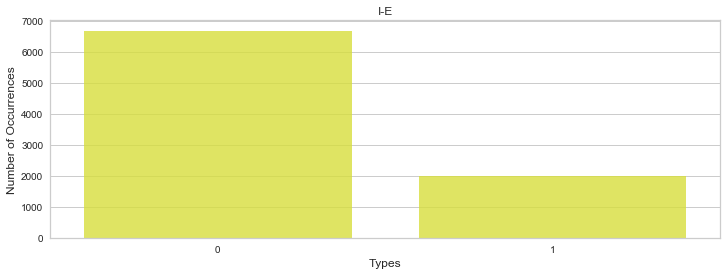

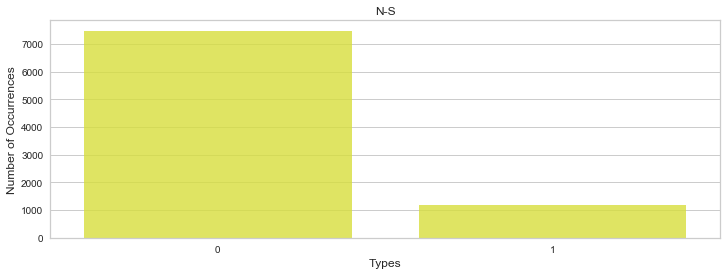

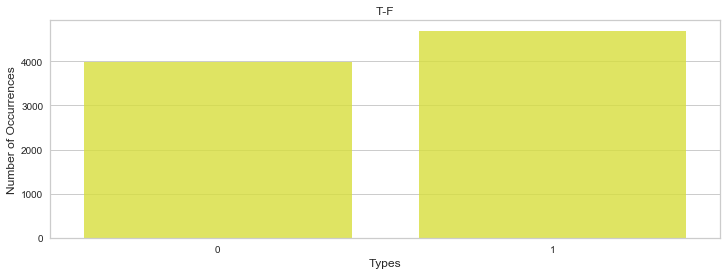

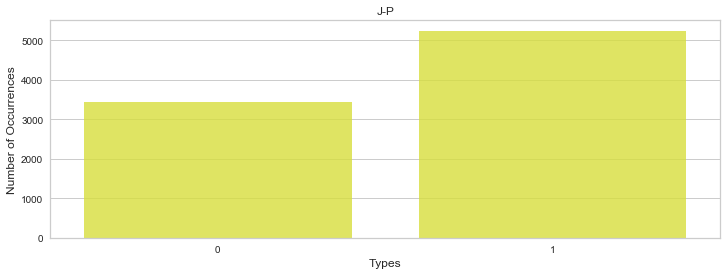

In [71]:
from matplotlib import cm

cnt_srs = df['I-E'].value_counts()
viridis = cm.get_cmap('plasma', 12)
colors = viridis(np.flip(np.linspace(0, 1, 16)))
plt.figure(figsize=(12,4))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8,palette=colors)
plt.title('I-E')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Types', fontsize=12)
plt.show()

from matplotlib import cm

cnt_srs = df['N-S'].value_counts()
viridis = cm.get_cmap('plasma', 12)
colors = viridis(np.flip(np.linspace(0, 1, 16)))
plt.figure(figsize=(12,4))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8,palette=colors)
plt.title('N-S')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Types', fontsize=12)
plt.show()

from matplotlib import cm

cnt_srs = df['T-F'].value_counts()
viridis = cm.get_cmap('plasma', 12)
colors = viridis(np.flip(np.linspace(0, 1, 16)))
plt.figure(figsize=(12,4))
plt.title('T-F')
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8,palette=colors)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Types', fontsize=12)
plt.show()

from matplotlib import cm

cnt_srs = df['J-P'].value_counts()
viridis = cm.get_cmap('plasma', 12)
colors = viridis(np.flip(np.linspace(0, 1, 16)))
plt.figure(figsize=(12,4))
plt.title('J-P')
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8,palette=colors)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Types', fontsize=12)
plt.show()

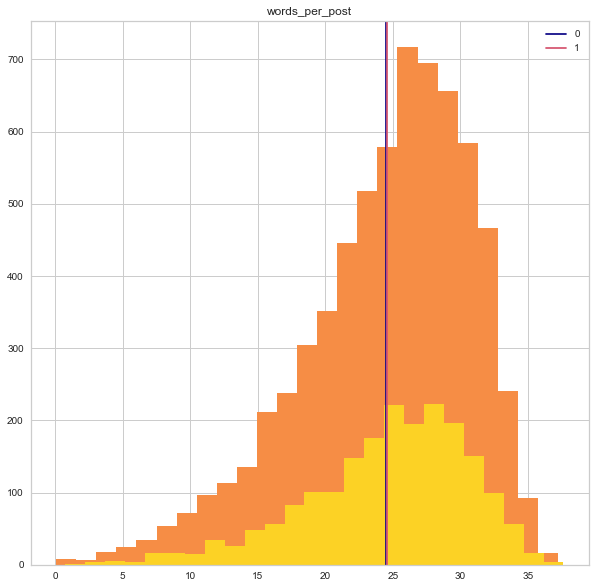

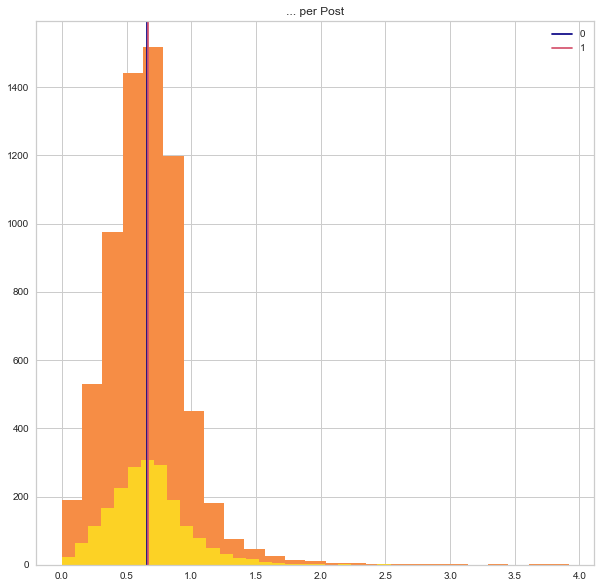

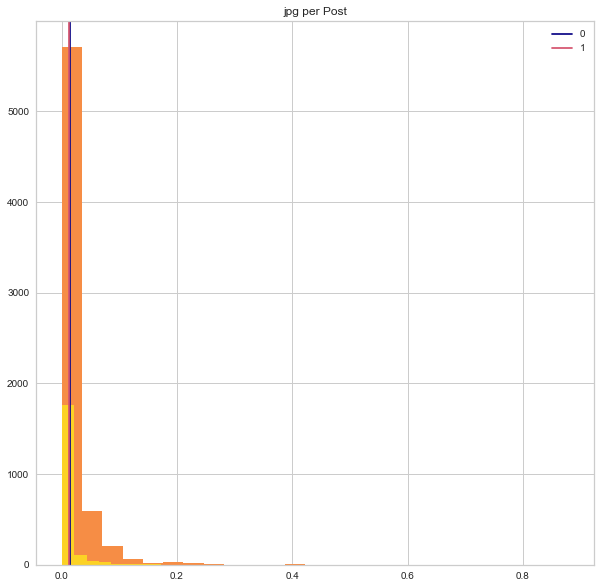

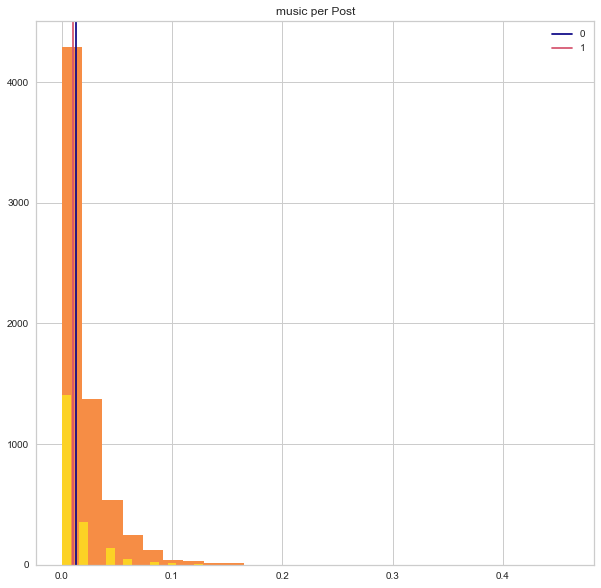

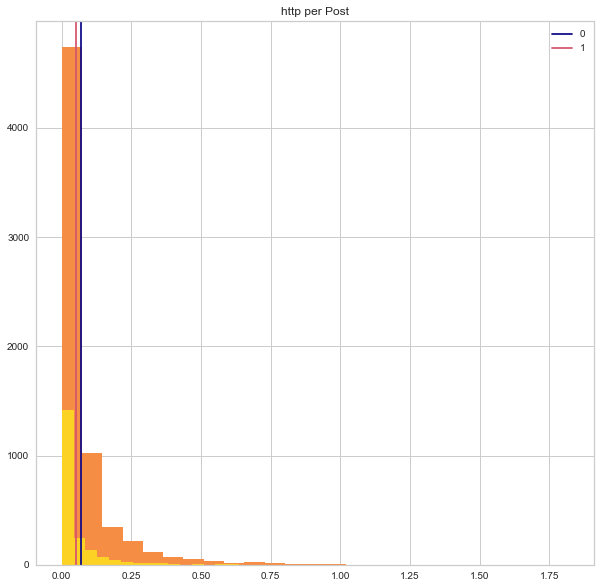

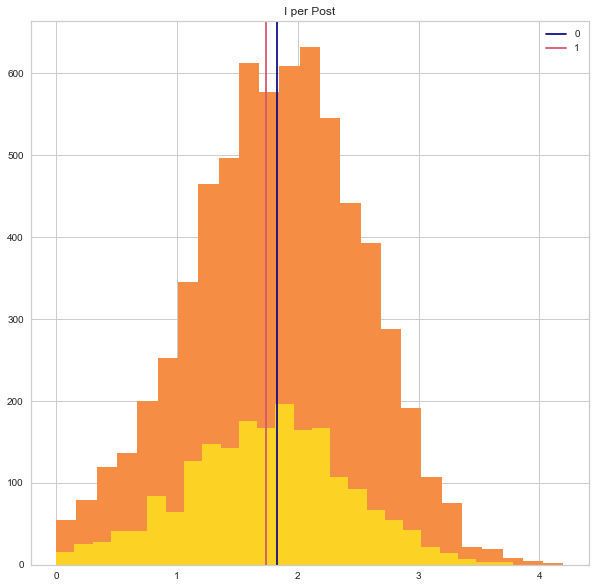

In [72]:
#Wizualizacja Razem --> pokazanie że średnie są niemalże identyczne ==> słaba rozpoznawalność

def wykres_osobowosci_razem_2(od_czego,do_czego='type'):
    from matplotlib import cm
  
    viridis = cm.get_cmap('plasma', 12)
    colors = viridis(np.linspace(0, 1, 12))
    colors2 = colors[[8,10],:]
    typ_osobow = np.unique(df[do_czego])
    plt.figure(figsize = (10,10))
   # cmap = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w','b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
    for i in range(len(typ_osobow)):
        if typ_osobow[i] ==0:
            plt.axvline(x=np.mean(df[od_czego].loc[df[do_czego]==typ_osobow[i]]),color=colors[0])
        else:
            plt.axvline(x=np.mean(df[od_czego].loc[df[do_czego]==typ_osobow[i]]),color=colors[6])
    
        plt.hist(df[od_czego].loc[df[do_czego]==typ_osobow[i]],bins=25,color=colors2[i])
        plt.title(od_czego)
        #print("{}: {}".format(typ_osobow[i],np.mean(df[od_czego].loc[df['type']==typ_osobow[i]])))
    plt.legend(typ_osobow)
    plt.show



wykres_osobowosci_razem_2('words_per_post',do_czego='I-E')
wykres_osobowosci_razem_2('... per Post',do_czego='I-E')
wykres_osobowosci_razem_2('jpg per Post',do_czego='I-E')
wykres_osobowosci_razem_2('music per Post',do_czego='I-E')
wykres_osobowosci_razem_2('http per Post',do_czego='I-E')
wykres_osobowosci_razem_2('I per Post',do_czego='I-E')

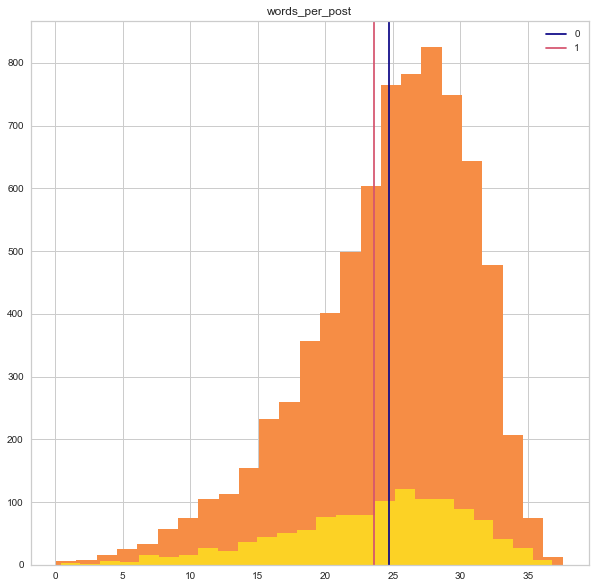

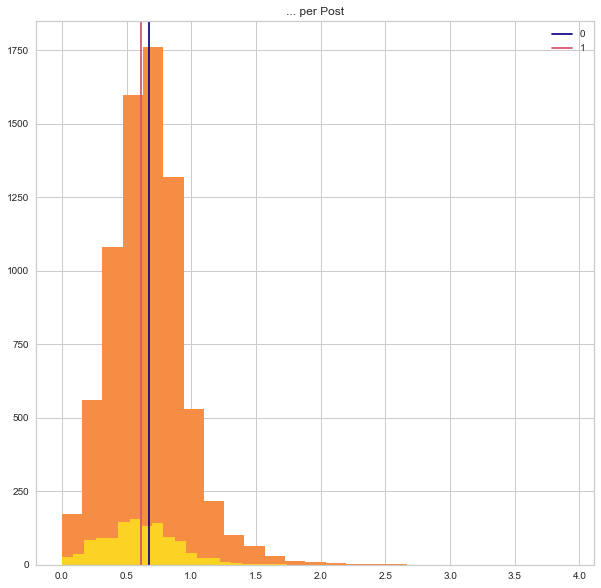

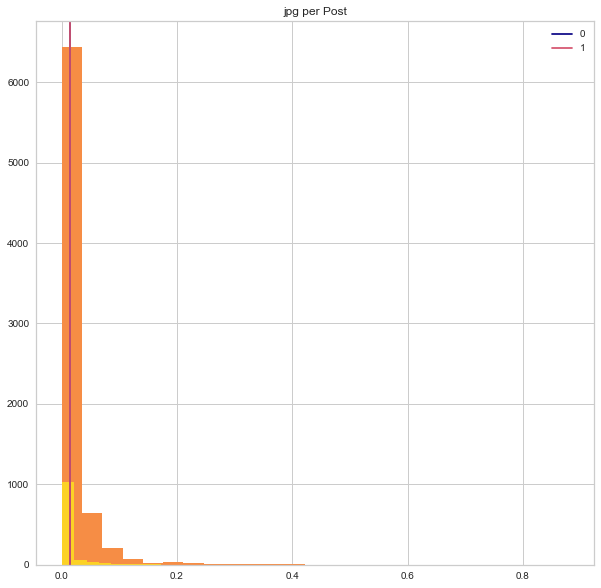

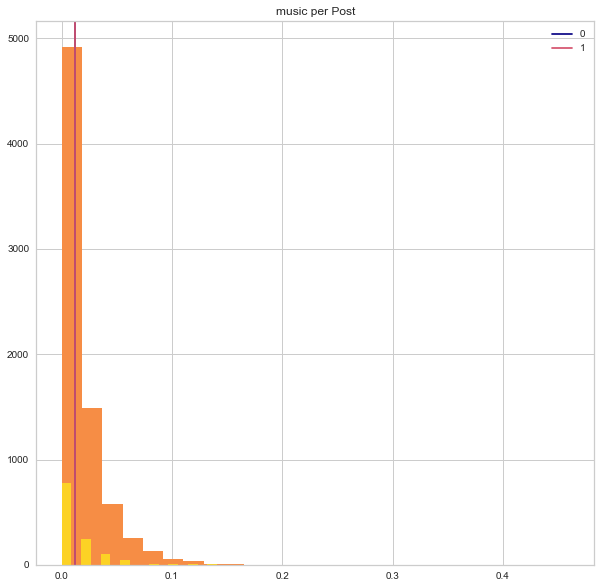

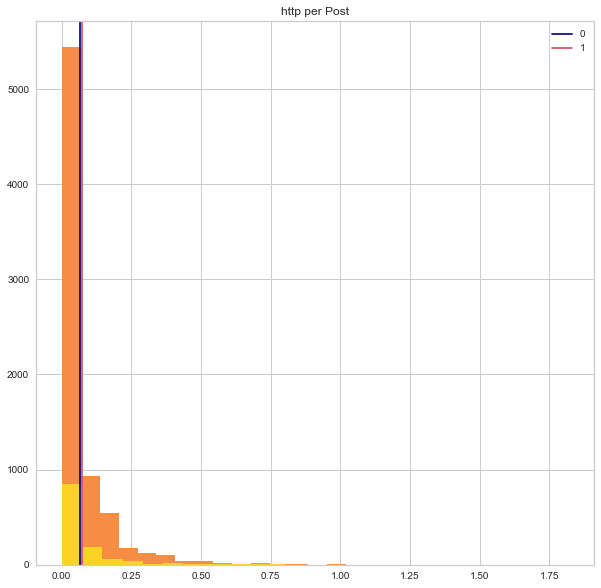

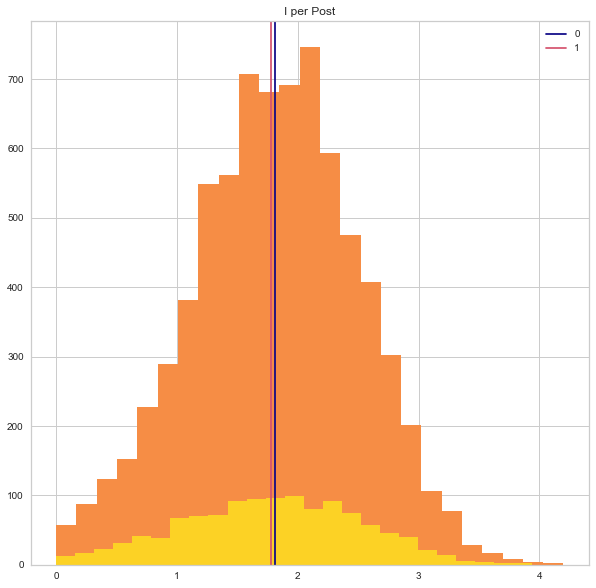

In [73]:
wykres_osobowosci_razem_2('words_per_post',do_czego='N-S')
wykres_osobowosci_razem_2('... per Post',do_czego='N-S')
wykres_osobowosci_razem_2('jpg per Post',do_czego='N-S')
wykres_osobowosci_razem_2('music per Post',do_czego='N-S')
wykres_osobowosci_razem_2('http per Post',do_czego='N-S')
wykres_osobowosci_razem_2('I per Post',do_czego='N-S')

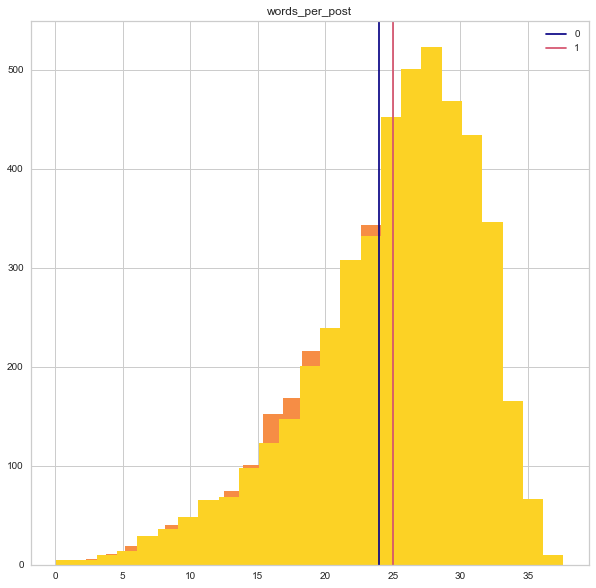

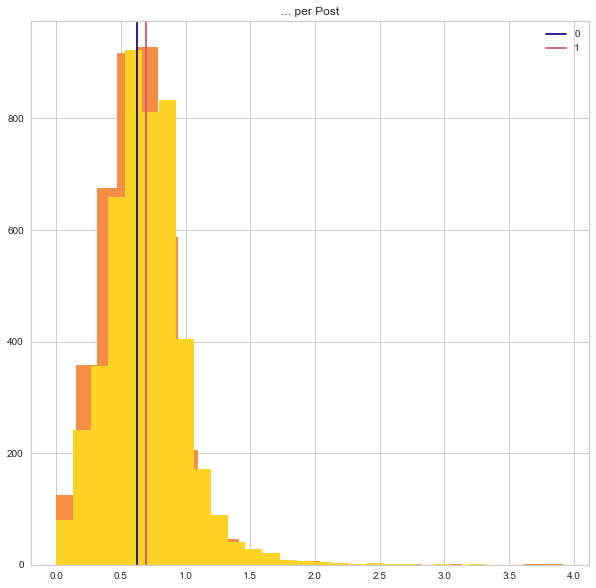

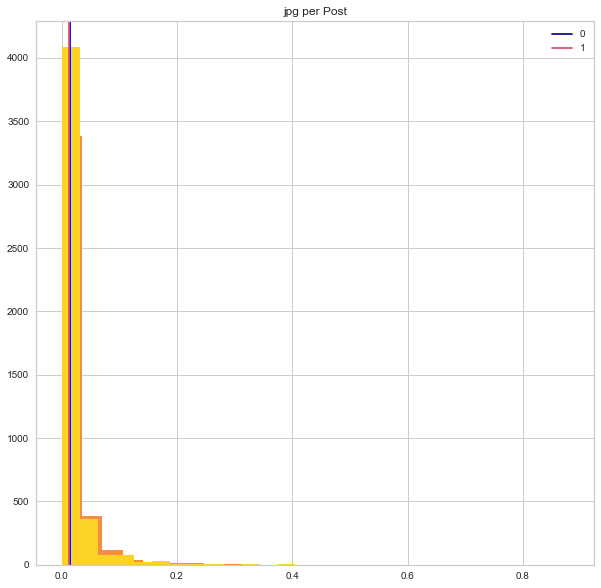

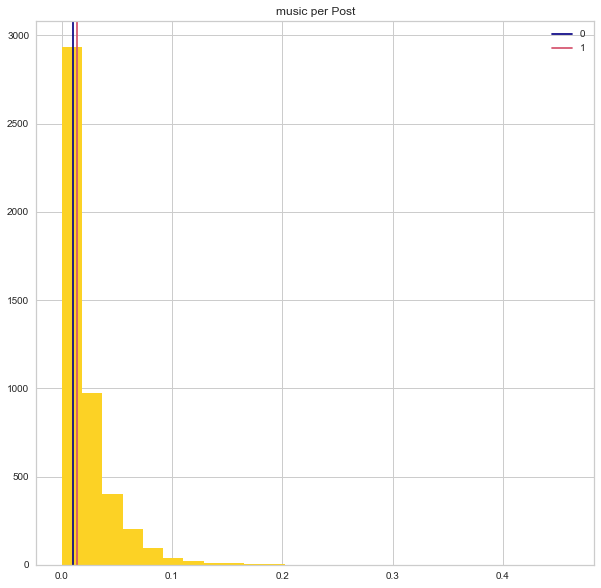

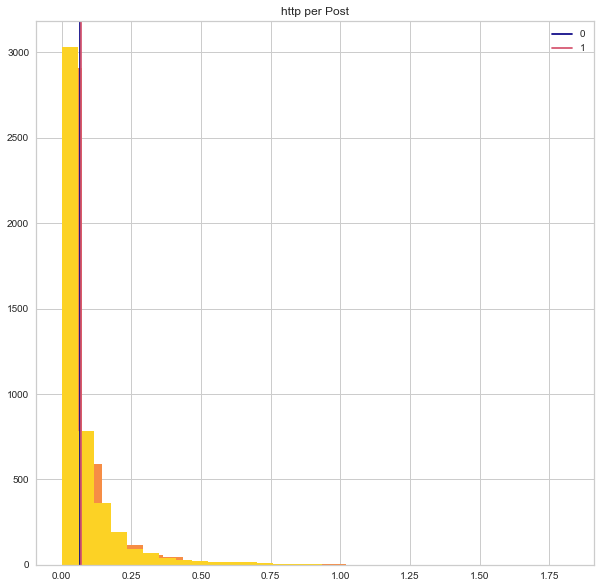

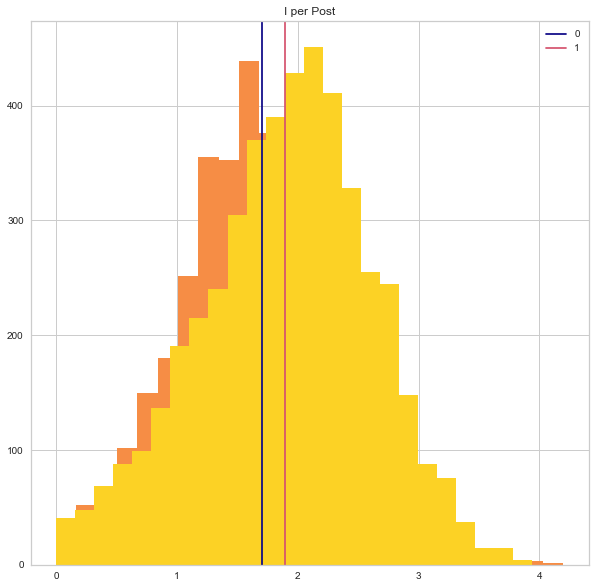

In [74]:
wykres_osobowosci_razem_2('words_per_post',do_czego='T-F')
wykres_osobowosci_razem_2('... per Post',do_czego='T-F')
wykres_osobowosci_razem_2('jpg per Post',do_czego='T-F')
wykres_osobowosci_razem_2('music per Post',do_czego='T-F')
wykres_osobowosci_razem_2('http per Post',do_czego='T-F')
wykres_osobowosci_razem_2('I per Post',do_czego='T-F')

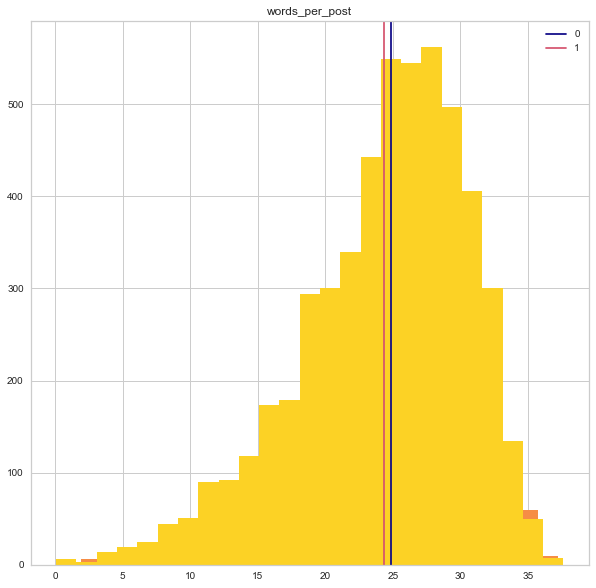

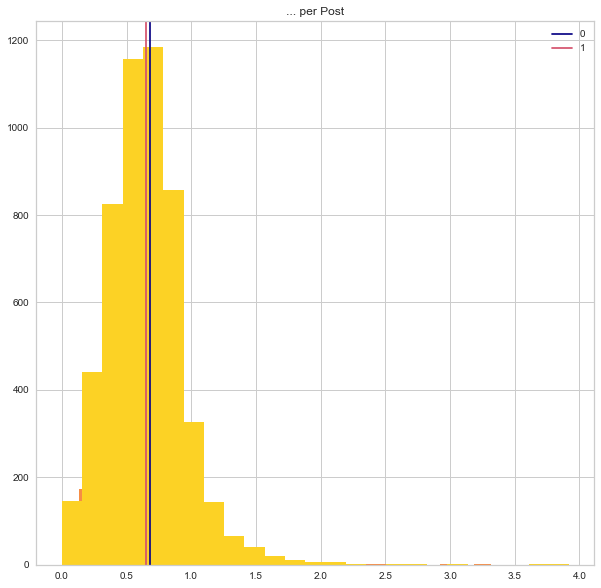

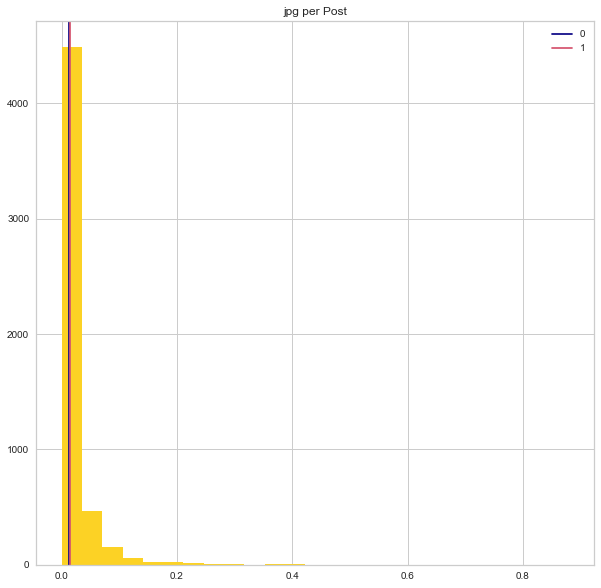

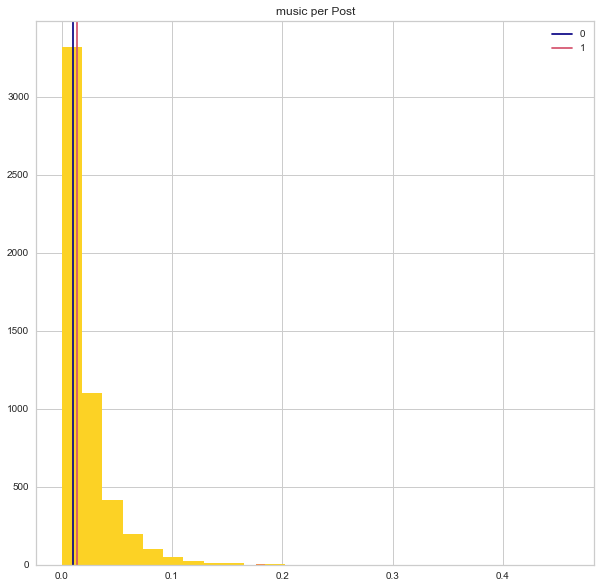

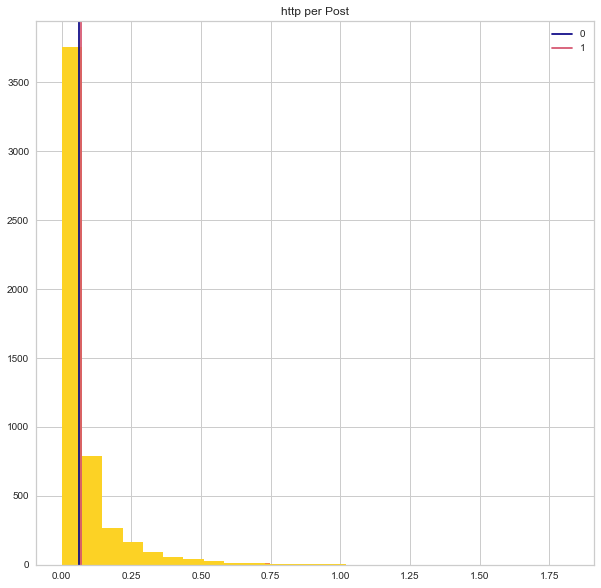

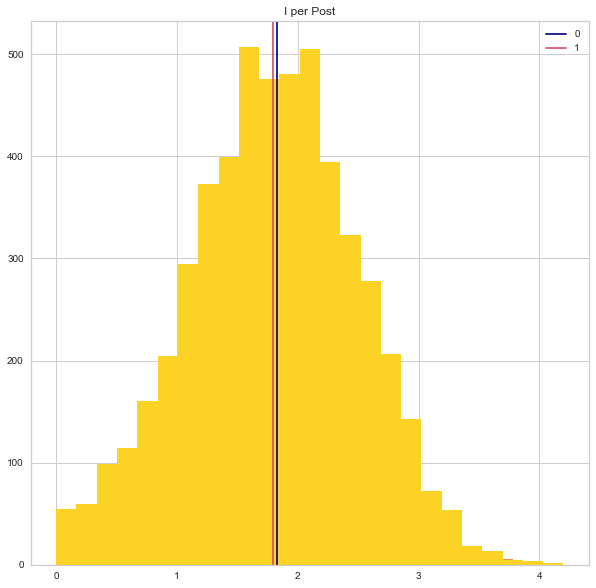

In [75]:
wykres_osobowosci_razem_2('words_per_post',do_czego='J-P')
wykres_osobowosci_razem_2('... per Post',do_czego='J-P')
wykres_osobowosci_razem_2('jpg per Post',do_czego='J-P')
wykres_osobowosci_razem_2('music per Post',do_czego='J-P')
wykres_osobowosci_razem_2('http per Post',do_czego='J-P')
wykres_osobowosci_razem_2('I per Post',do_czego='J-P')

[0 1]
0: 24.50591372079095
1: 24.588854427213555
[0 1]
0: 24.679096014977333
1: 23.56250626566416
[0 1]
0: 23.94178849535291
1: 25.019671921602065
[0 1]
0: 24.841927781013478
1: 24.317385995039103


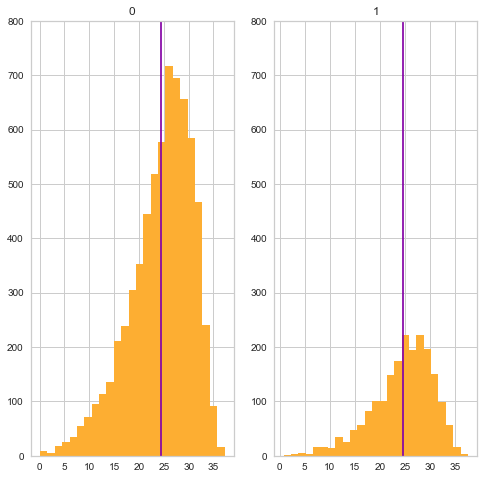

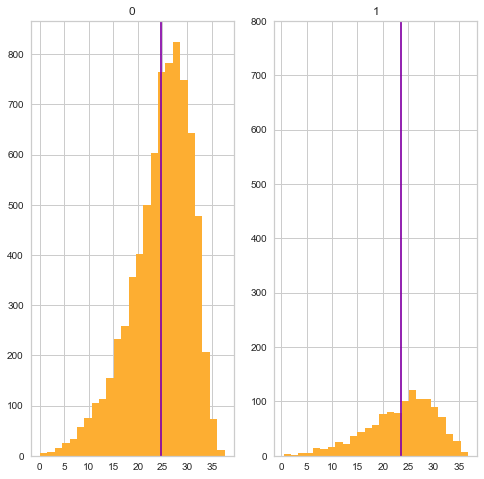

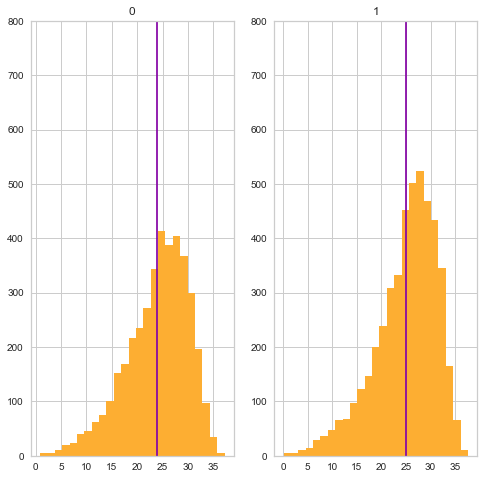

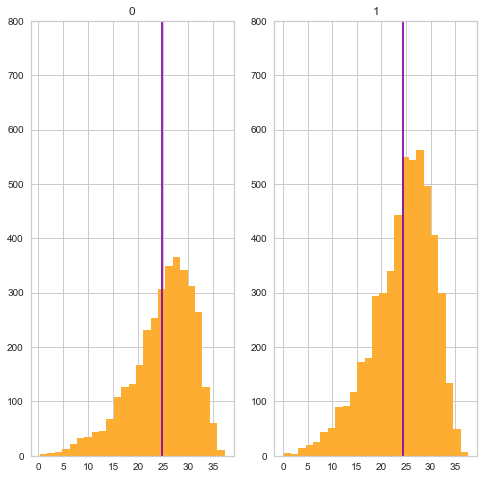

In [76]:
def wykres_osobowosci_rozdzielon(od_czego,do_czego,ticks=(0,5,10,15,20,25,30,35),yticks = [0,100,200,300,400,500,600,700,800]):
    from matplotlib import cm
    viridis = cm.get_cmap('plasma', 12)
    colors = viridis(np.linspace(0, 1, 16))
    typ_osobow = np.unique(df[do_czego])
    print(typ_osobow)
    fig,axes = plt.subplots(1,2,figsize=(8,8))
    for i,ax in zip(range(len(typ_osobow)),axes.ravel()):
        ax.hist(df[od_czego].loc[df[do_czego]==typ_osobow[i]],bins=25,color=colors[12])
        ax.axvline(x=np.mean(df[od_czego].loc[df[do_czego]==typ_osobow[i]]),color=colors[4])
        ax.set_xticks(ticks)
        ax.set_yticks(yticks)

        ax.title.set_text(typ_osobow[i])
        print("{}: {}".format(typ_osobow[i],np.mean(df[od_czego].loc[df[do_czego]==typ_osobow[i]])))
    plt.show

warunki_osobow = ['I-E','N-S','T-F','J-P']        
for j in warunki_osobow:
    wykres_osobowosci_rozdzielon('words_per_post',j)

[0 1]
0: 0.07072798082684274
1: 0.0505952976488245
[0 1]
0: 0.06501738432736055
1: 0.07278195488721813
[0 1]
0: 0.06396885204722495
1: 0.06788666382616158
[0 1]
0: 0.0629237041351199
1: 0.06816256439610789


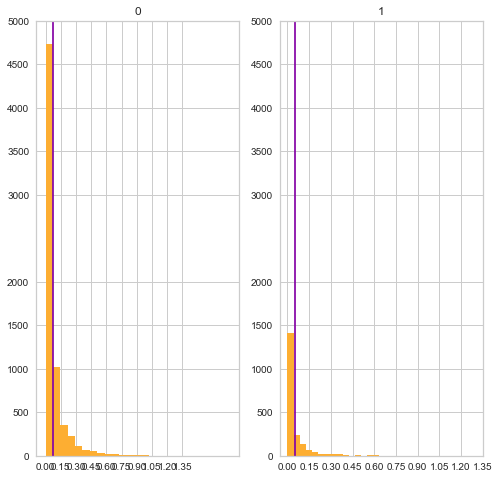

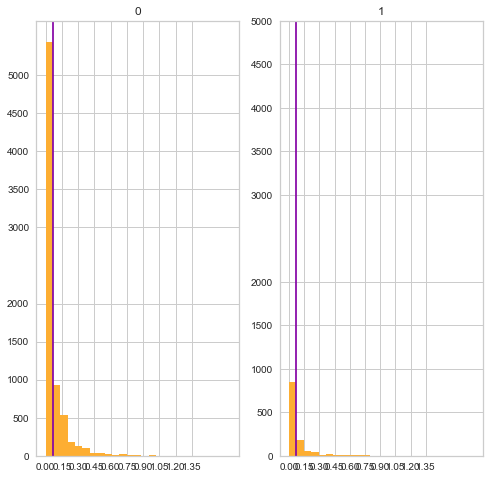

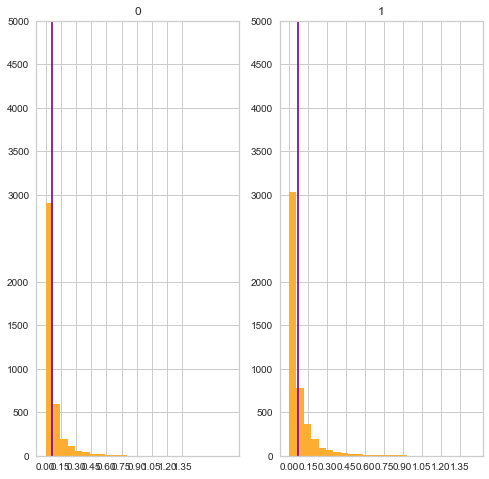

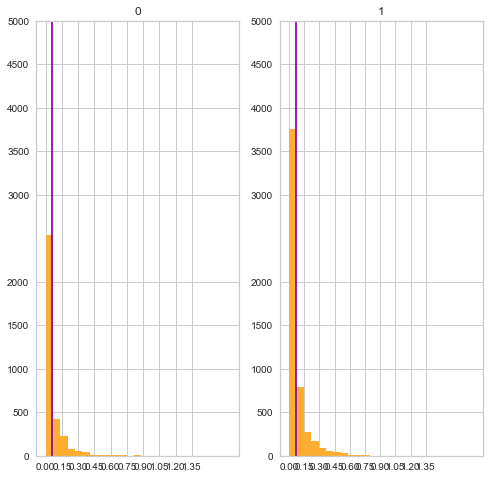

In [84]:
warunki_osobow = ['I-E','N-S','T-F','J-P']        
for j in warunki_osobow:
    wykres_osobowosci_rozdzielon('http per Post',j,ticks = [0,0.15,0.3,0.45,0.6,0.75,0.9,1.05,1.2,1.35],yticks = (0,500,1000,1500,2000,3000,3500,4000,4500,5000))

[0 1]
0: 0.6609227082085082
1: 0.6677038519259654
[0 1]
0: 0.6711152714629581
1: 0.6085714285714282
[0 1]
0: 0.6276262245666917
1: 0.6920494247976133
[0 1]
0: 0.678893418753641
1: 0.6517344018317107


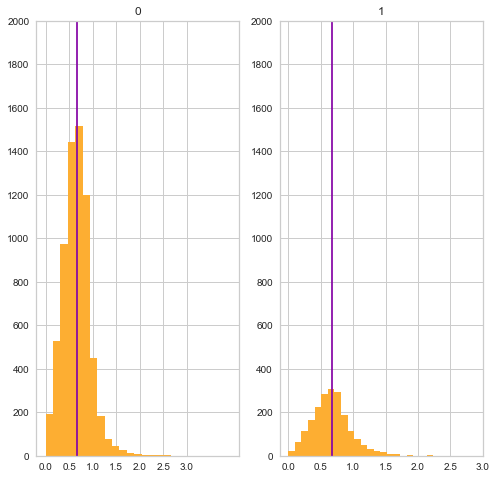

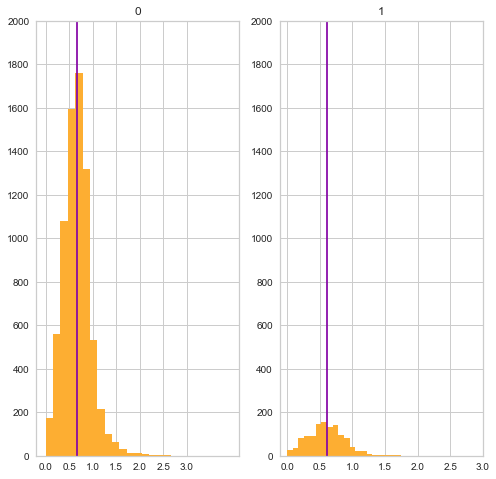

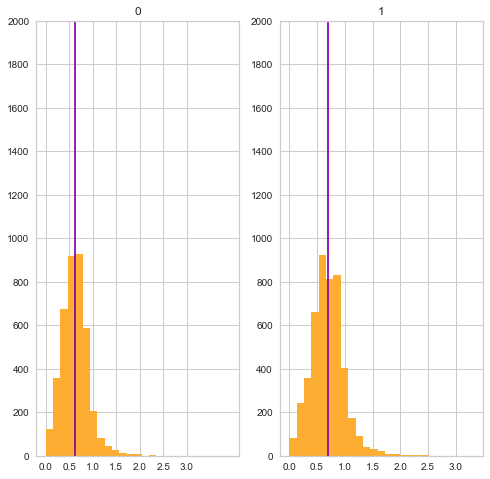

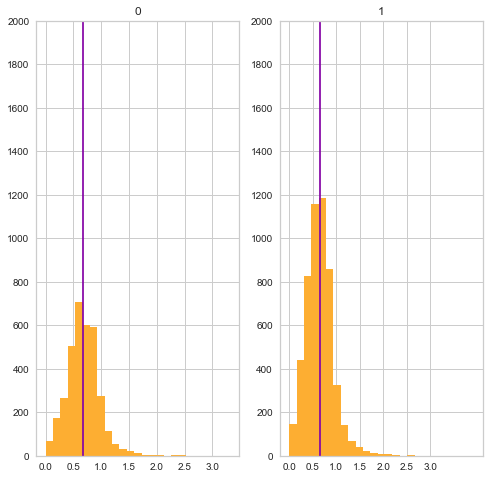

In [85]:
warunki_osobow = ['I-E','N-S','T-F','J-P']        
for j in warunki_osobow:
    wykres_osobowosci_rozdzielon('... per Post',j,ticks=(0.0,0.5,1.0,1.5,2.0,2.5,3.0), yticks = [0,200,400,600,800,1000,1200,1400,1600,1800,2000])

[0 1]
0: 0.013040742959856327
1: 0.010075037518759277
[0 1]
0: 0.012377641080502889
1: 0.012230576441102665
[0 1]
0: 0.010158251695553878
1: 0.0142224115892631
[0 1]
0: 0.010302853814793162
1: 0.013703491700057394


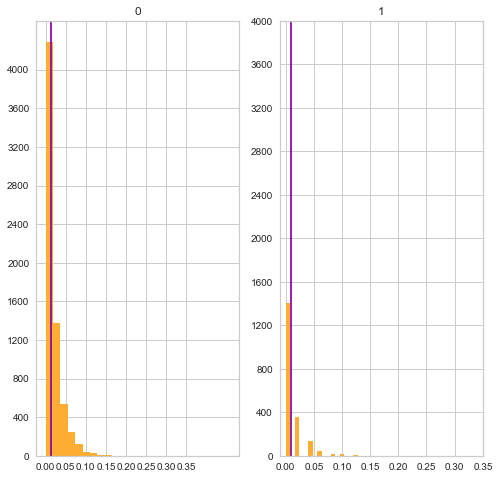

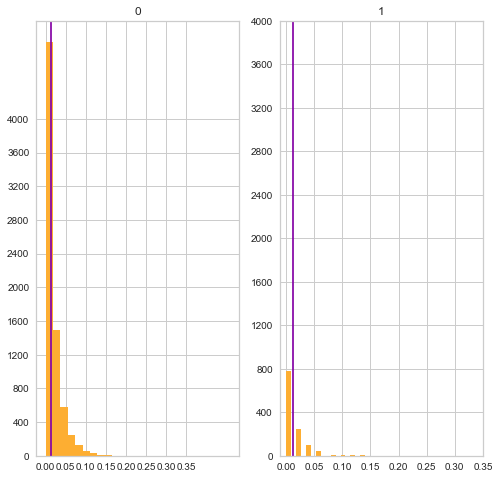

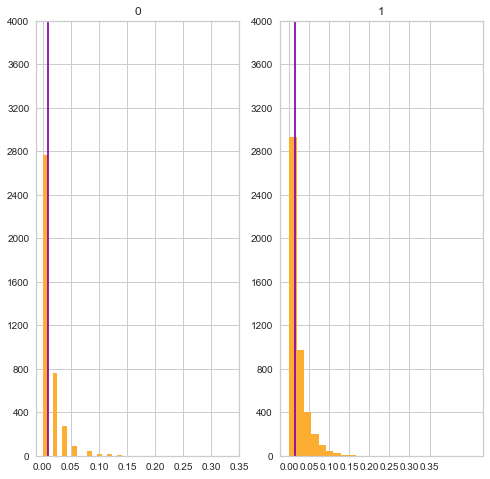

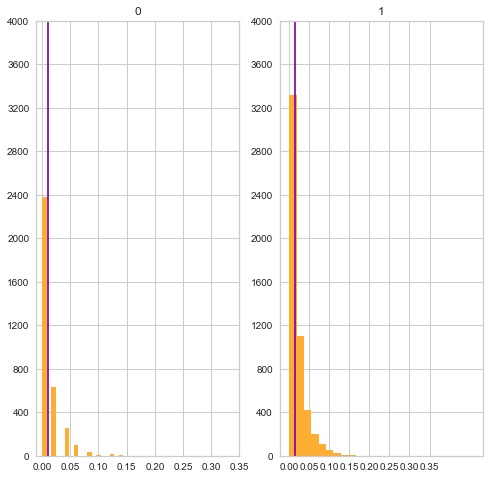

In [79]:
warunki_osobow = ['I-E','N-S','T-F','J-P']        
for j in warunki_osobow:
    wykres_osobowosci_rozdzielon('music per Post',j,ticks=(0.0,0.05,0.1,0.15,0.2,0.25,0.3,0.35),yticks = [0,400,800,1200,1600,2000,2400,2800,3200,3600,4000])

[0 1]
0: 0.014562612342720268
1: 0.011985992996498166
[0 1]
0: 0.013976999197646492
1: 0.013918128654970692
[0 1]
0: 0.014508917357447977
1: 0.013510864933958358
[0 1]
0: 0.013261502620850348
1: 0.014432360236596168


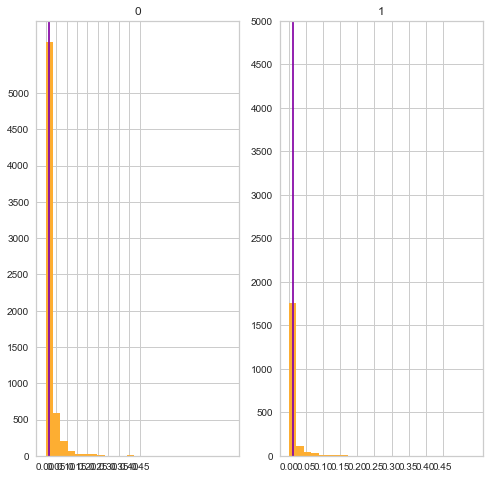

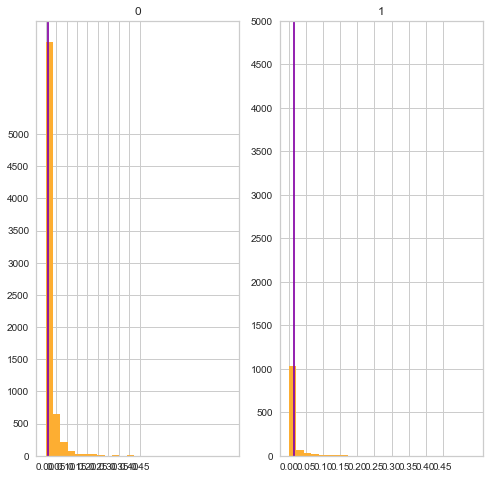

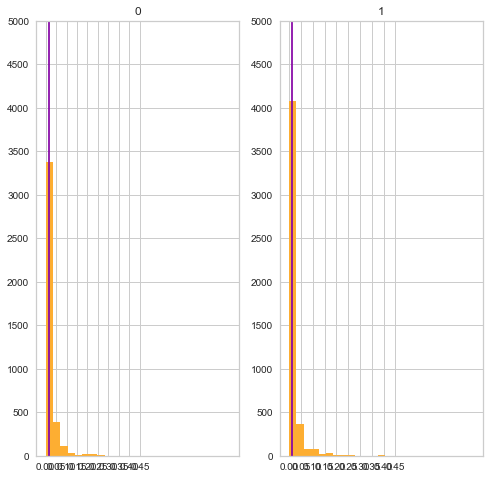

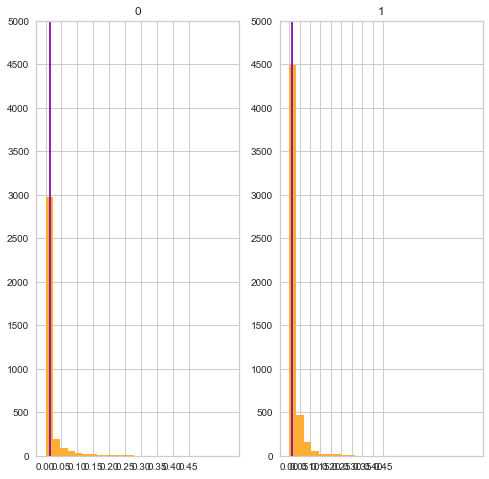

In [88]:
warunki_osobow = ['I-E','N-S','T-F','J-P']        
for j in warunki_osobow:
    wykres_osobowosci_rozdzielon('jpg per Post',j,ticks=(0.0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45),yticks = [0,500,1000,1500,2000,2500,3000,3500,4000,4500,5000])

[0 1]
0: 1.8272019173157534
1: 1.7394697348674293
[0 1]
0: 1.811963091735753
1: 1.7758897243107783
[0 1]
0: 1.700648078372273
1: 1.8971708564124379
[0 1]
0: 1.8292195690157196
1: 1.7924174775806108


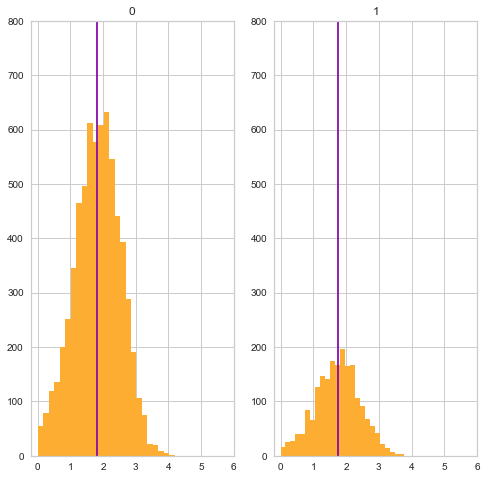

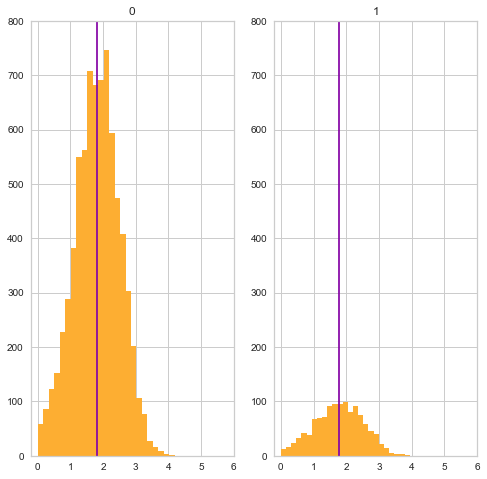

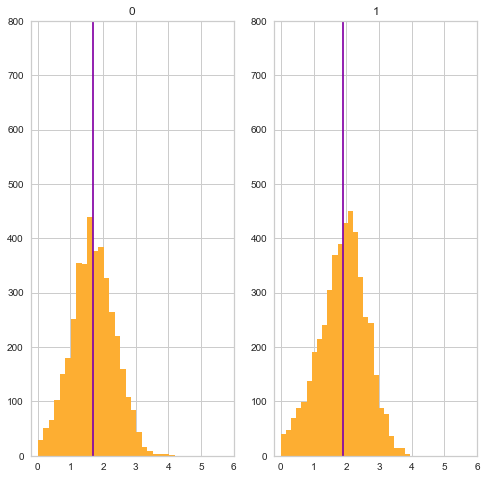

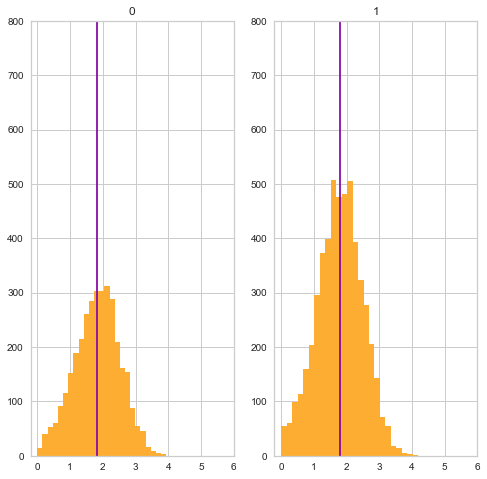

In [81]:
warunki_osobow = ['I-E','N-S','T-F','J-P']        
for j in warunki_osobow:
    wykres_osobowosci_rozdzielon('I per Post',j,ticks=(0.0,1,2,3,4,5,6))

Zobaczmy jeszcze jak wygląda ilość słów w poszczególnych grupach

I-E


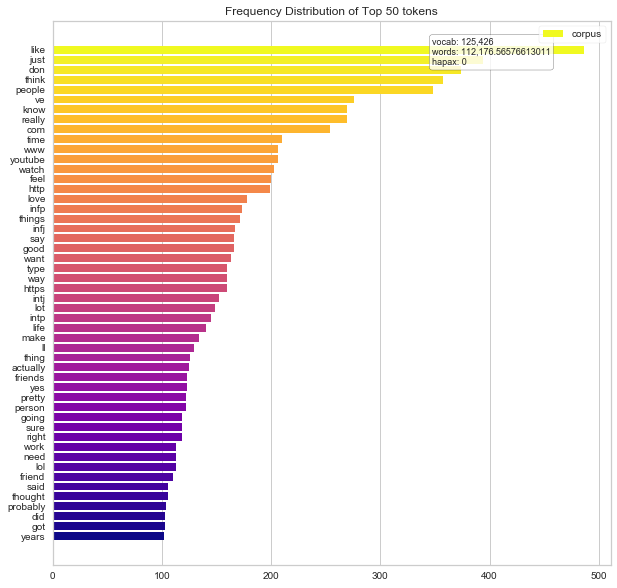

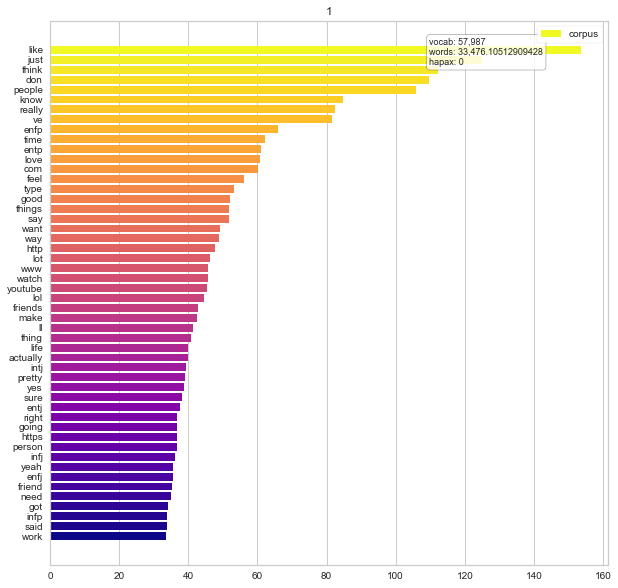

N-S


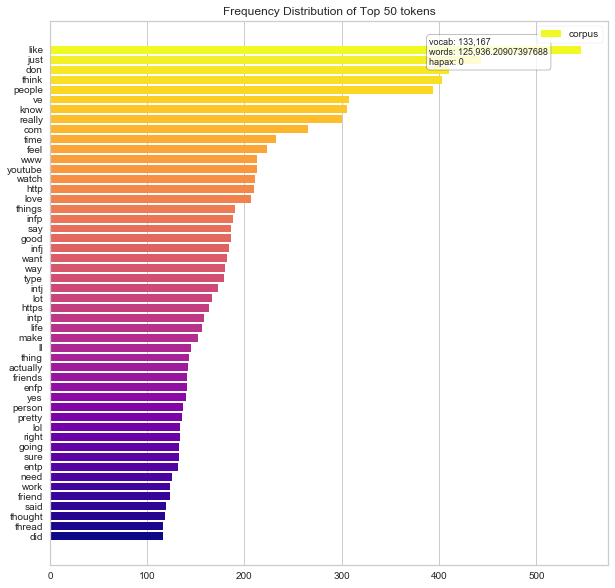

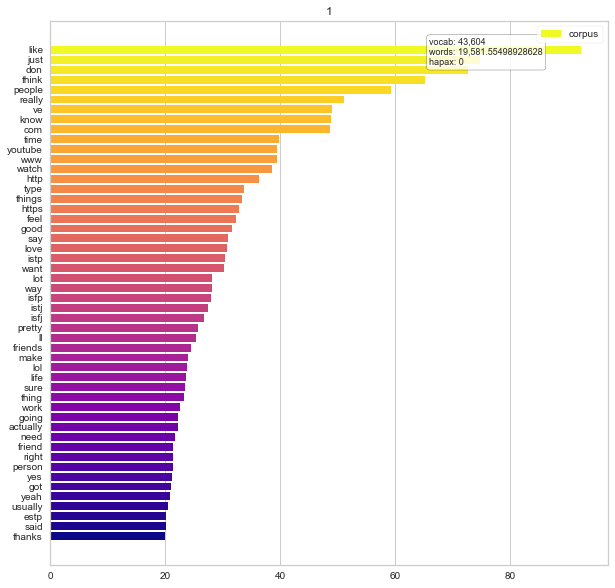

T-F


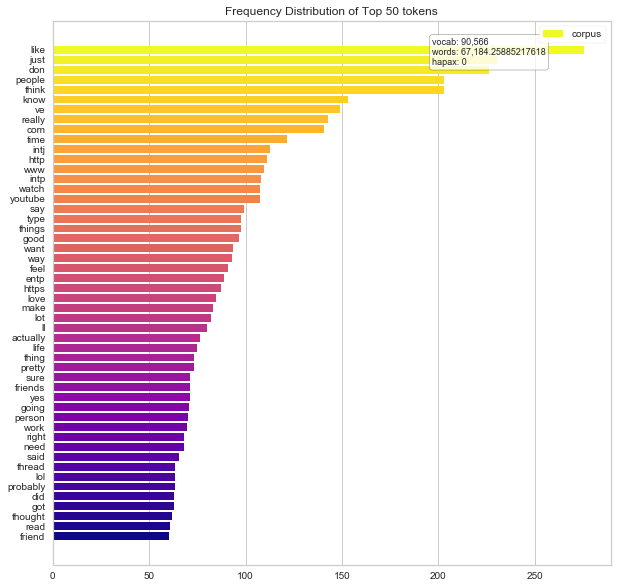

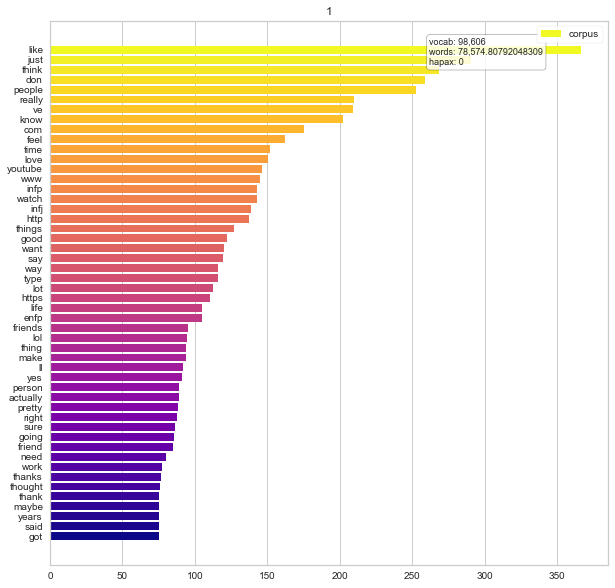

J-P


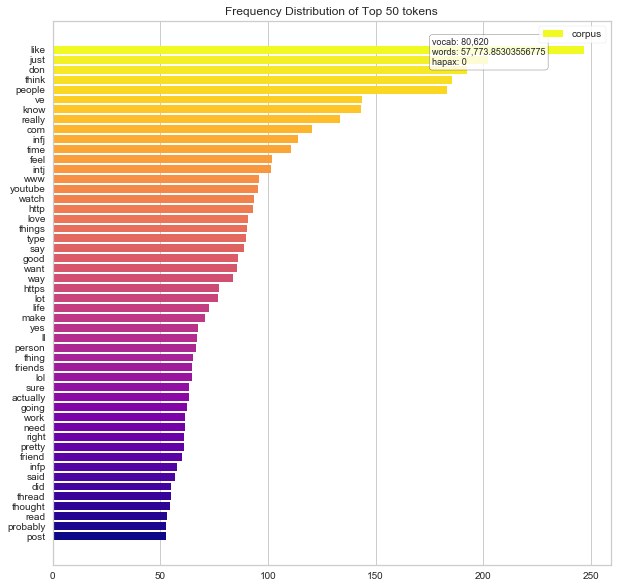

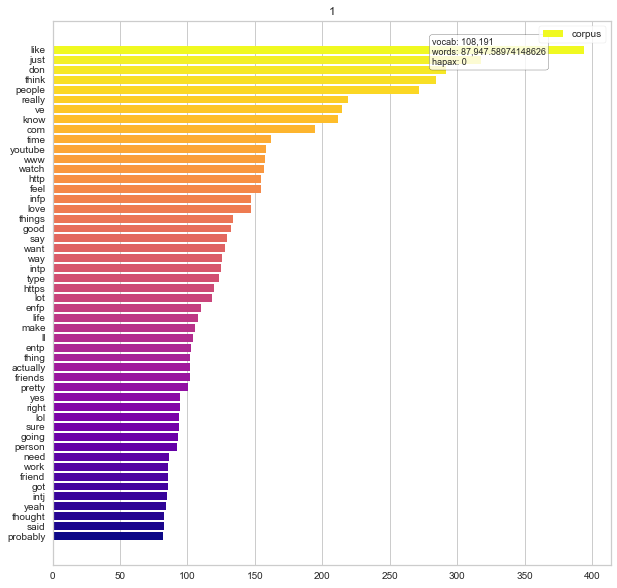

In [82]:
from sklearn.feature_extraction.text import CountVectorizer
from yellowbrick.text import FreqDistVisualizer

def Most_frequent_words_in_Group(types,pyte='type'):
    XXX = df['posts'].loc[df[pyte] == types].values

    from matplotlib import cm

    cnt_srs = df['type'].value_counts()
    viridis = cm.get_cmap('plasma', 50)
    colors = viridis(np.flip(np.linspace(0, 1, 50)))
    
    
    TfidVect  = tfidf.fit_transform(XXX)
    svd_model = tsvd
    data_revitalised = svd_model.fit_transform(TfidVect)
    plt.figure(figsize = (10,10))
    visualizer = FreqDistVisualizer(features=tfidf.get_feature_names(), orient='h',title =types, color = colors)
    visualizer.fit(TfidVect)
    #visualizer.title(types)
    visualizer.show()
    
    
print('I-E')    
Most_frequent_words_in_Group(0,pyte = 'I-E')
Most_frequent_words_in_Group(1,'I-E')
print('N-S')  
Most_frequent_words_in_Group(0,'N-S')
Most_frequent_words_in_Group(1,'N-S')
print('T-F')  
Most_frequent_words_in_Group(0,'T-F')
Most_frequent_words_in_Group(1,'T-F')
print('J-P')  
Most_frequent_words_in_Group(0,'J-P')
Most_frequent_words_in_Group(1,'J-P')

**PCA - okazało się zbędne**

### Klasyfikacja I-E 

In [73]:
#Czyścimy zbiór Danych z  niepotrzebnych linków itp.

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics

from bs4 import BeautifulSoup
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    return text
df['clean_posts'] = df['posts'].apply(cleanText)




In [93]:
XX = df['clean_posts'].values
yy = df['I-E'].values

print(XX.shape)
print(yy.shape)

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(XX,yy,test_size = 0.1, random_state=42)

#Przeprowadzamy Text Mining oraz Skalowanie danych i redukcje wymiarów

tfidf = TfidfVectorizer(ngram_range=(1, 1), stop_words='english')
tsvd = TruncatedSVD(n_components=10)

TfidVect  = tfidf.fit_transform(X_train)
svd_model = tsvd
data_revitalised = svd_model.fit_transform(TfidVect)

TfidVect_test  = tfidf.fit_transform(X_test)
svd_model_test = tsvd
data_revitalised_test = svd_model_test.fit_transform(TfidVect_test)


from imblearn.over_sampling import SMOTE

sm = SMOTE()
X_train_res_aut, y_train_res_aut = sm.fit_sample(data_revitalised, y_train)


(8675,)
(8675,)


In [94]:
svmIE = SVC(kernel = 'rbf', C = 1, gamma = 100,probability = True)
svmIE.fit(X_train_res_aut,y_train_res_aut)




SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=100, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

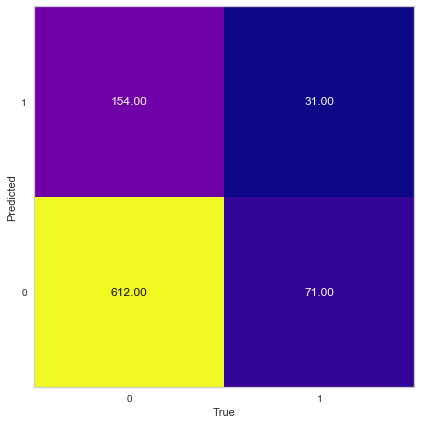

In [95]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array =metrics.confusion_matrix(y_test, svmIE.predict(data_revitalised_test))

personality_types = np.unique(y_test)

df_cm = pd.DataFrame(array, index = [i for i in personality_types],
                  columns = [i for i in personality_types])

plt.figure(figsize = (7,7))
heatmap(array, xlabel='True', xticklabels=personality_types, ylabel='Predicted', yticklabels=personality_types, cmap="plasma")
plt.show()

In [96]:
print("R^2: {}".format(metrics.precision_score(y_test, svmIE.predict(data_revitalised_test),average='macro') ))
print("precision: {}".format(metrics.recall_score(y_test, svmIE.predict(data_revitalised_test),average='macro') ))
print("recall_score: {}".format( metrics.recall_score(y_test, svmIE.predict(data_revitalised_test),average='macro') ))
print("f1_score: {}".format( metrics.f1_score(y_test, svmIE.predict(data_revitalised_test),average='macro') ))
print("accuracy_score: {}".format( metrics.accuracy_score(y_test, svmIE.predict(data_revitalised_test)) ))

R^2: 0.5514385911022373
precision: 0.5318072098452772
recall_score: 0.5318072098452772
f1_score: 0.530374185729435
accuracy_score: 0.7407834101382489


Average precision-recall score: 0.29


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.29')

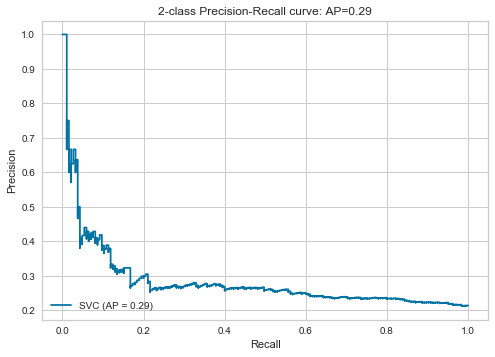

In [97]:
y_score = svmIE.decision_function(data_revitalised_test)
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

disp = plot_precision_recall_curve(svmIE, data_revitalised_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

In [98]:
RNDIE = ExtraTreesClassifier(max_leaf_nodes = 64, n_estimators =1000)
RNDIE.fit(X_train_res_aut,y_train_res_aut)


ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=64, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=1000,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

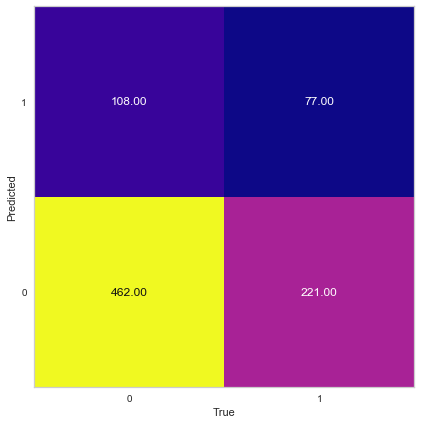

In [99]:

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array =metrics.confusion_matrix(y_test, RNDIE.predict(data_revitalised_test))

personality_types = np.unique(y_test)

df_cm = pd.DataFrame(array, index = [i for i in personality_types],
                  columns = [i for i in personality_types])

plt.figure(figsize = (7,7))
heatmap(array, xlabel='True', xticklabels=personality_types, ylabel='Predicted', yticklabels=personality_types, cmap="plasma")
plt.show()

In [100]:
print("R^2: {}".format(metrics.precision_score(y_test, RNDIE.predict(data_revitalised_test),average='macro') ))
print("precision: {}".format(metrics.recall_score(y_test, RNDIE.predict(data_revitalised_test),average='macro') ))
print("recall_score: {}".format( metrics.recall_score(y_test, RNDIE.predict(data_revitalised_test),average='macro') ))
print("f1_score: {}".format( metrics.f1_score(y_test, RNDIE.predict(data_revitalised_test),average='macro') ))
print("accuracy_score: {}".format( metrics.accuracy_score(y_test, RNDIE.predict(data_revitalised_test)) ))

R^2: 0.53445778876722
precision: 0.5463218709192355
recall_score: 0.5463218709192355
f1_score: 0.5281353736539551
accuracy_score: 0.6209677419354839


In [101]:
voting_clf_IE = VotingClassifier(
    estimators=[('lr', svmIE), ('svc', RNDIE)], voting='soft')
voting_clf_IE.fit(X_train_res_aut, y_train_res_aut)

VotingClassifier(estimators=[('lr',
                              SVC(C=1, break_ties=False, cache_size=200,
                                  class_weight=None, coef0=0.0,
                                  decision_function_shape='ovr', degree=3,
                                  gamma=100, kernel='rbf', max_iter=-1,
                                  probability=True, random_state=None,
                                  shrinking=True, tol=0.001, verbose=False)),
                             ('svc',
                              ExtraTreesClassifier(bootstrap=False,
                                                   ccp_alpha=0.0,
                                                   class_weight=None,
                                                   criterion='gini',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=64,
            

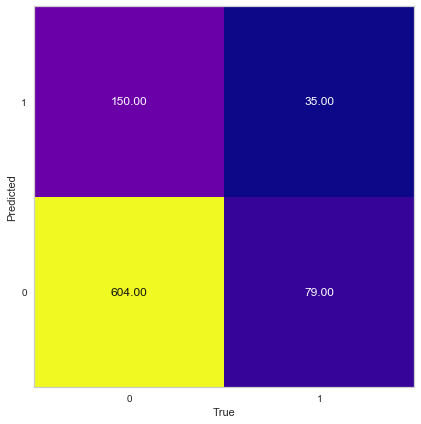

In [102]:

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array =metrics.confusion_matrix(y_test, voting_clf_IE.predict(data_revitalised_test))

personality_types = np.unique(y_test)

df_cm = pd.DataFrame(array, index = [i for i in personality_types],
                  columns = [i for i in personality_types])

plt.figure(figsize = (7,7))
heatmap(array, xlabel='True', xticklabels=personality_types, ylabel='Predicted', yticklabels=personality_types, cmap="plasma")
plt.show()

In [103]:
print("R^2: {}".format(metrics.precision_score(y_test, voting_clf_IE.predict(data_revitalised_test),average='macro') ))
print("precision: {}".format(metrics.recall_score(y_test, voting_clf_IE.predict(data_revitalised_test),average='macro') ))
print("recall_score: {}".format( metrics.recall_score(y_test, voting_clf_IE.predict(data_revitalised_test),average='macro') ))
print("f1_score: {}".format( metrics.f1_score(y_test, voting_clf_IE.predict(data_revitalised_test),average='macro') ))
print("accuracy_score: {}".format( metrics.accuracy_score(y_test, voting_clf_IE.predict(data_revitalised_test)) ))

R^2: 0.5540392759086044
precision: 0.5367615052827351
recall_score: 0.5367615052827351
f1_score: 0.5373769675303668
accuracy_score: 0.7361751152073732


In [ ]:
#Best Clssificators:

Classif_res_IE = "Some Classificator Here"
Classif_res_IE.fit(X_train_res, y_train_res)

from sklearn import metrics

print("R^2: {}".format(metrics.precision_score(y_test, Classif_res_IE.predict(X_test),average='micro') ))
print("recall_score: {}".format( metrics.recall_score(y_test, Classif_res_IE.predict(X_test),average='micro') ))
print("f1_score: {}".format( metrics.f1_score(y_test, Classif_res_IE.predict(X_test),average='micro') ))
print("accuracy_score: {}".format( metrics.accuracy_score(y_test, Classif_res_IE.predict(X_test)) ))

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array =metrics.confusion_matrix(y_test, Classif_res_IE.predict(X_test))

personality_types = np.unique(y_test)

df_cm = pd.DataFrame(array, index = [i for i in personality_types],
                  columns = [i for i in personality_types])

plt.figure(figsize = (15,15))
heatmap(array, xlabel='True', xticklabels=personality_types, ylabel='Predicted', yticklabels=personality_types, cmap="plasma")
plt.show() 

### Klasyfikacja N-S z Resamplingiem

In [104]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2


XX = df.drop(['type','posts','I-E','N-S','T-F','J-P','clean_posts'], axis=1).values
yy = df['N-S'].values

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(XX,yy,test_size = 0.1, random_state=42)

sm = SMOTE()
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

In [116]:
svmNS2 = SVC(kernel = 'rbf', C =10, gamma = 100,probability = True)
svmNS2.fit(X_train_res,y_train_res)


SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=100, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

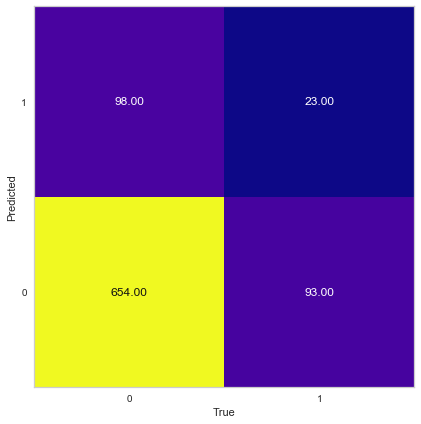

In [117]:

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array =metrics.confusion_matrix(y_test, svmNS2.predict(X_test))

personality_types = np.unique(y_test)

df_cm = pd.DataFrame(array, index = [i for i in personality_types],
                  columns = [i for i in personality_types])

plt.figure(figsize = (7,7))
heatmap(array, xlabel='True', xticklabels=personality_types, ylabel='Predicted', yticklabels=personality_types, cmap="plasma")
plt.show()

In [118]:
print("R^2: {}".format(metrics.precision_score(y_test, svmNS2.predict(X_test),average='macro') ))
print("precision: {}".format(metrics.recall_score(y_test, svmNS2.predict(X_test),average='macro') ))
print("recall_score: {}".format( metrics.recall_score(y_test, svmNS2.predict(X_test),average='macro') ))
print("f1_score: {}".format( metrics.f1_score(y_test, svmNS2.predict(X_test),average='macro') ))
print("accuracy_score: {}".format( metrics.accuracy_score(y_test, svmNS2.predict(X_test)) ))

R^2: 0.5339783565663976
precision: 0.5327923263301139
recall_score: 0.5327923263301139
f1_score: 0.5333372740758255
accuracy_score: 0.7799539170506913


Average precision-recall score: 0.16


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.16')

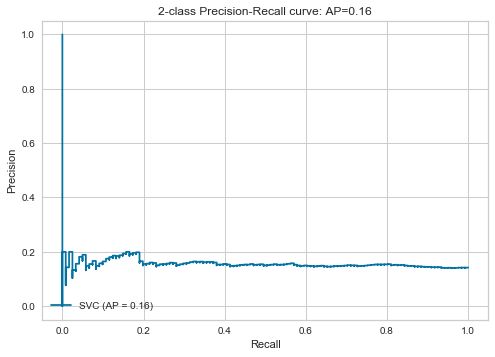

In [119]:
y_score = svmNS2.decision_function(X_test)
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

disp = plot_precision_recall_curve(svmNS2, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

In [111]:
RNDNS = ExtraTreesClassifier(max_leaf_nodes = 64, n_estimators =1000)
RNDNS.fit(X_train_res,y_train_res)


ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=64, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=1000,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

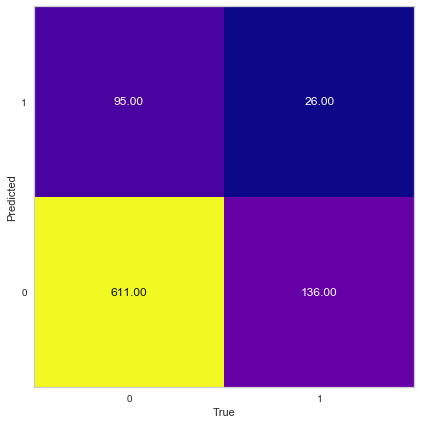

In [112]:

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array =metrics.confusion_matrix(y_test, RNDNS.predict(X_test))

personality_types = np.unique(y_test)

df_cm = pd.DataFrame(array, index = [i for i in personality_types],
                  columns = [i for i in personality_types])

plt.figure(figsize = (7,7))
heatmap(array, xlabel='True', xticklabels=personality_types, ylabel='Predicted', yticklabels=personality_types, cmap="plasma")
plt.show()


In [113]:
print("R^2: {}".format(metrics.precision_score(y_test, RNDNS.predict(X_test),average='macro') ))
print("precision: {}".format(metrics.recall_score(y_test, RNDNS.predict(X_test),average='macro') ))
print("recall_score: {}".format( metrics.recall_score(y_test, RNDNS.predict(X_test),average='macro') ))
print("f1_score: {}".format( metrics.f1_score(y_test, RNDNS.predict(X_test),average='macro') ))
print("accuracy_score: {}".format( metrics.accuracy_score(y_test, RNDNS.predict(X_test)) ))

R^2: 0.5129664603224565
precision: 0.516407226702955
recall_score: 0.516407226702955
f1_score: 0.5123820826412516
accuracy_score: 0.7338709677419355


In [120]:
voting_clf = VotingClassifier(
    estimators=[('lr', svmNS2), ('svc', RNDNS)], voting='soft')
voting_clf.fit(X_train_res, y_train_res)



VotingClassifier(estimators=[('lr',
                              SVC(C=10, break_ties=False, cache_size=200,
                                  class_weight=None, coef0=0.0,
                                  decision_function_shape='ovr', degree=3,
                                  gamma=100, kernel='rbf', max_iter=-1,
                                  probability=True, random_state=None,
                                  shrinking=True, tol=0.001, verbose=False)),
                             ('svc',
                              ExtraTreesClassifier(bootstrap=False,
                                                   ccp_alpha=0.0,
                                                   class_weight=None,
                                                   criterion='gini',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=64,
           

In [121]:
print("R^2: {}".format(metrics.precision_score(y_test, voting_clf.predict(X_test),average='macro') ))
print("precision: {}".format(metrics.recall_score(y_test, voting_clf.predict(X_test),average='macro') ))
print("recall_score: {}".format( metrics.recall_score(y_test, voting_clf.predict(X_test),average='macro') ))
print("f1_score: {}".format( metrics.f1_score(y_test, voting_clf.predict(X_test),average='macro') ))
print("accuracy_score: {}".format( metrics.accuracy_score(y_test, voting_clf.predict(X_test)) ))

R^2: 0.5214081690945445
precision: 0.5165842433093255
recall_score: 0.5165842433093255
f1_score: 0.517140859296092
accuracy_score: 0.793778801843318


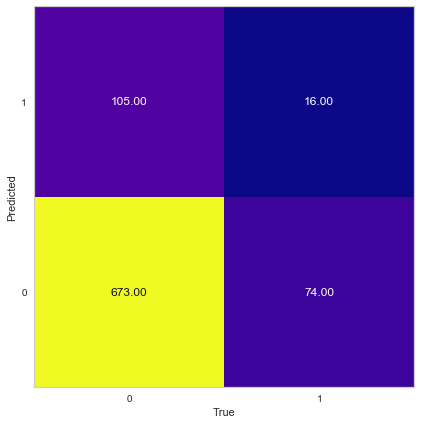

In [122]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array =metrics.confusion_matrix(y_test, voting_clf.predict(X_test))

personality_types = np.unique(y_test)

df_cm = pd.DataFrame(array, index = [i for i in personality_types],
                  columns = [i for i in personality_types])

plt.figure(figsize = (7,7))
heatmap(array, xlabel='True', xticklabels=personality_types, ylabel='Predicted', yticklabels=personality_types, cmap="plasma")
plt.show() 

In [ ]:
#Best Clssificators:

Classif_res_NS = "Some Classificator Here"
Classif_res_NS.fit(X_train_res, y_train_res)

from sklearn import metrics

print("R^2: {}".format(metrics.precision_score(y_test, Classif_res_NS.predict(X_test),average='micro') ))
print("recall_score: {}".format( metrics.recall_score(y_test, Classif_res_NS.predict(X_test),average='micro') ))
print("f1_score: {}".format( metrics.f1_score(y_test, Classif_res_NS.predict(X_test),average='micro') ))
print("accuracy_score: {}".format( metrics.accuracy_score(y_test, Classif_res_NS.predict(X_test)) ))

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array =metrics.confusion_matrix(y_test, Classif_res_NS.predict(X_test))

personality_types = np.unique(y_test)

df_cm = pd.DataFrame(array, index = [i for i in personality_types],
                  columns = [i for i in personality_types])

plt.figure(figsize = (15,15))
heatmap(array, xlabel='True', xticklabels=personality_types, ylabel='Predicted', yticklabels=personality_types, cmap="plasma")
plt.show() 

### Klasyfikacja T-F z Resamplingiem

In [124]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2


XX = df.drop(['type','posts','I-E','N-S','T-F','J-P','clean_posts'], axis=1).values
yy = df['T-F'].values

from sklearn.model_selection import train_test_split
X_train,X_test_norm,y_train,y_test_norm=train_test_split(XX,yy,test_size = 0.1, random_state=42)

sm = SMOTE()
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

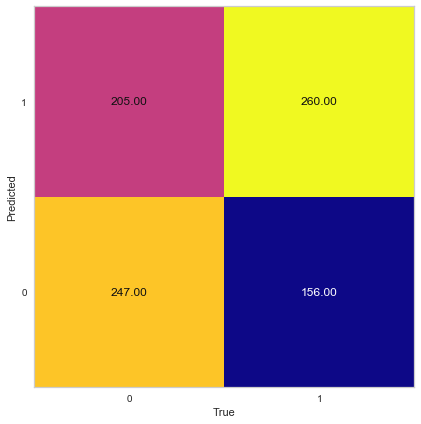

In [125]:
LogRegTF2 = LogisticRegression(penalty = 'l2', C =100)
LogRegTF2.fit(X_train_res,y_train_res)

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array =metrics.confusion_matrix(y_test_norm, LogRegTF2.predict(X_test_norm))

personality_types = np.unique(y_test_norm)

df_cm = pd.DataFrame(array, index = [i for i in personality_types],
                  columns = [i for i in personality_types])

plt.figure(figsize = (7,7))
heatmap(array, xlabel='True', xticklabels=personality_types, ylabel='Predicted', yticklabels=personality_types, cmap="plasma")
plt.show()


In [126]:
print("R^2: {}".format(metrics.precision_score(y_test_norm, LogRegTF2.predict(X_test_norm),average='macro') ))
print("precision: {}".format(metrics.recall_score(y_test_norm, LogRegTF2.predict(X_test_norm),average='macro') ))
print("recall_score: {}".format( metrics.recall_score(y_test_norm, LogRegTF2.predict(X_test_norm),average='macro') ))
print("f1_score: {}".format( metrics.f1_score(y_test_norm, LogRegTF2.predict(X_test_norm),average='macro') ))
print("accuracy_score: {}".format( metrics.accuracy_score(y_test_norm, LogRegTF2.predict(X_test_norm)) ))

R^2: 0.5857300884955752
precision: 0.586021505376344
recall_score: 0.586021505376344
f1_score: 0.5840080716357674
accuracy_score: 0.5841013824884793


0.6013824884792627


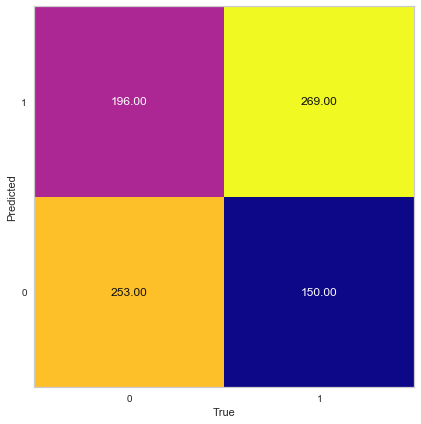

In [127]:
svmTF = SVC(kernel = 'rbf', C =1000, gamma = 0.1,probability = True)
svmTF.fit(X_train_res,y_train_res)

print(metrics.accuracy_score(y_test_norm,svmTF.predict(X_test_norm)))

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array =metrics.confusion_matrix(y_test_norm, svmTF.predict(X_test_norm))

personality_types = np.unique(y_test_norm)

df_cm = pd.DataFrame(array, index = [i for i in personality_types],
                  columns = [i for i in personality_types])

plt.figure(figsize = (7,7))
heatmap(array, xlabel='True', xticklabels=personality_types, ylabel='Predicted', yticklabels=personality_types, cmap="plasma")
plt.show()

In [128]:
print("R^2: {}".format(metrics.precision_score(y_test_norm, svmTF.predict(X_test_norm),average='macro') ))
print("precision: {}".format(metrics.recall_score(y_test_norm, svmTF.predict(X_test_norm),average='macro') ))
print("recall_score: {}".format( metrics.recall_score(y_test_norm, svmTF.predict(X_test_norm),average='macro') ))
print("f1_score: {}".format( metrics.f1_score(y_test_norm, svmTF.predict(X_test_norm),average='macro') ))
print("accuracy_score: {}".format( metrics.accuracy_score(y_test_norm, svmTF.predict(X_test_norm)) ))

R^2: 0.6027395803987647
precision: 0.6031430934656741
recall_score: 0.6031430934656741
f1_score: 0.6012469993414484
accuracy_score: 0.6013824884792627


In [129]:
voting_clf_TF = VotingClassifier(
    estimators=[('lr', svmTF), ('svc', LogRegTF2)], voting='soft')
voting_clf_TF.fit(X_train_res, y_train_res)



VotingClassifier(estimators=[('lr',
                              SVC(C=1000, break_ties=False, cache_size=200,
                                  class_weight=None, coef0=0.0,
                                  decision_function_shape='ovr', degree=3,
                                  gamma=0.1, kernel='rbf', max_iter=-1,
                                  probability=True, random_state=None,
                                  shrinking=True, tol=0.001, verbose=False)),
                             ('svc',
                              LogisticRegression(C=100, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                          

In [130]:
print("R^2: {}".format(metrics.precision_score(y_test_norm, voting_clf_TF.predict(X_test_norm),average='macro') ))
print("precision: {}".format(metrics.recall_score(y_test_norm, voting_clf_TF.predict(X_test_norm),average='macro') ))
print("recall_score: {}".format( metrics.recall_score(y_test_norm, voting_clf_TF.predict(X_test_norm),average='macro') ))
print("f1_score: {}".format( metrics.f1_score(y_test_norm, voting_clf_TF.predict(X_test_norm),average='macro') ))
print("accuracy_score: {}".format( metrics.accuracy_score(y_test_norm, voting_clf_TF.predict(X_test_norm)) ))

R^2: 0.6079716893276215
precision: 0.6082712985938792
recall_score: 0.6082712985938792
f1_score: 0.6059384806537427
accuracy_score: 0.6059907834101382


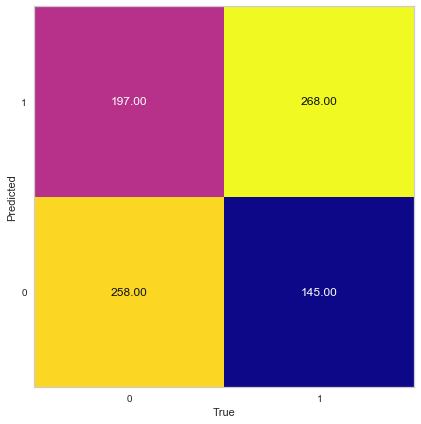

In [131]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array =metrics.confusion_matrix(y_test_norm, voting_clf_TF.predict(X_test))

personality_types = np.unique(y_test_norm)

df_cm = pd.DataFrame(array, index = [i for i in personality_types],
                  columns = [i for i in personality_types])

plt.figure(figsize = (7,7))
heatmap(array, xlabel='True', xticklabels=personality_types, ylabel='Predicted', yticklabels=personality_types, cmap="plasma")
plt.show() 

In [ ]:
#Best Clssificators:

Classif_res_TF = "Some Classificator Here"
Classif_res_TF.fit(X_train_res, y_train_res)

from sklearn import metrics

print("R^2: {}".format(metrics.precision_score(y_test, Classif_res_TF.predict(X_test),average='micro') ))
print("recall_score: {}".format( metrics.recall_score(y_test, Classif_res_TF.predict(X_test),average='micro') ))
print("f1_score: {}".format( metrics.f1_score(y_test, Classif_res_TF.predict(X_test),average='micro') ))
print("accuracy_score: {}".format( metrics.accuracy_score(y_test, Classif_res_TF.predict(X_test)) ))

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array =metrics.confusion_matrix(y_test, Classif_res_TF.predict(X_test))

personality_types = np.unique(y_test)

df_cm = pd.DataFrame(array, index = [i for i in personality_types],
                  columns = [i for i in personality_types])

plt.figure(figsize = (15,15))
heatmap(array, xlabel='True', xticklabels=personality_types, ylabel='Predicted', yticklabels=personality_types, cmap="plasma")
plt.show() 

### Klasyfikacja J-P z Resamplingiem

In [92]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2


XX = df.drop(['type','posts','I-E','N-S','T-F','J-P','clean_posts'], axis=1).values
yy = df['J-P'].values

from sklearn.model_selection import train_test_split
X_train,X_test_norm,y_train,y_test_norm=train_test_split(XX,yy,test_size = 0.1, random_state=42)

sm = SMOTE()
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

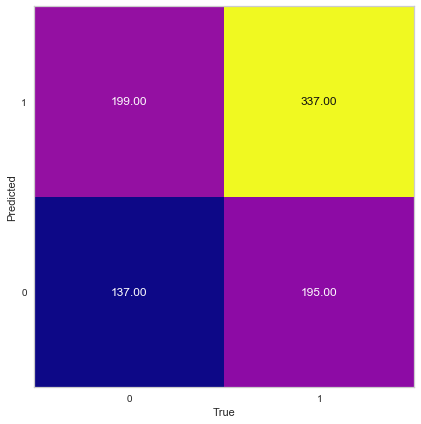

In [93]:
RNDJP = ExtraTreesClassifier(max_leaf_nodes = 128, n_estimators =1000)
RNDJP.fit(X_train_res,y_train_res)

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array =metrics.confusion_matrix(y_test_norm, RNDJP.predict(X_test_norm))

personality_types = np.unique(y_test_norm)

df_cm = pd.DataFrame(array, index = [i for i in personality_types],
                  columns = [i for i in personality_types])

plt.figure(figsize = (7,7))
heatmap(array, xlabel='True', xticklabels=personality_types, ylabel='Predicted', yticklabels=personality_types, cmap="plasma")
plt.show()


In [94]:
print("R^2: {}".format(metrics.precision_score(y_test_norm, RNDJP.predict(X_test_norm),average='macro') ))
print("precision: {}".format(metrics.recall_score(y_test_norm, RNDJP.predict(X_test_norm),average='macro') ))
print("recall_score: {}".format( metrics.recall_score(y_test_norm, RNDJP.predict(X_test_norm),average='macro') ))
print("f1_score: {}".format( metrics.f1_score(y_test_norm, RNDJP.predict(X_test_norm),average='macro') ))
print("accuracy_score: {}".format( metrics.accuracy_score(y_test_norm, RNDJP.predict(X_test_norm)) ))

R^2: 0.5205983709273183
precision: 0.5206909728466103
recall_score: 0.5206909728466103
f1_score: 0.5206328915203301
accuracy_score: 0.5460829493087558


0.5207373271889401


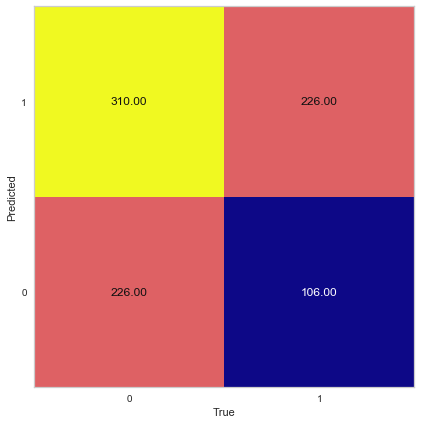

0.6807228915662651
0.4216417910447761
0.5207373271889401
0.5207373271889401


In [95]:
LogRegJP = LogisticRegression(penalty = 'l2', C =100)
LogRegJP.fit(X_train_res,y_train_res)
print(metrics.accuracy_score(y_test_norm,LogRegJP.predict(X_test_norm)))

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array =metrics.confusion_matrix(y_test_norm, LogRegJP.predict(X_test_norm))

personality_types = np.unique(y_test_norm)

df_cm = pd.DataFrame(array, index = [i for i in personality_types],
                  columns = [i for i in personality_types])

plt.figure(figsize = (7,7))
heatmap(array, xlabel='True', xticklabels=personality_types, ylabel='Predicted', yticklabels=personality_types, cmap="plasma")
plt.show()

print(metrics.precision_score(y_test_norm,LogRegJP.predict(X_test_norm)))
print(metrics.recall_score(y_test_norm,LogRegJP.predict(X_test_norm)))
print(metrics.accuracy_score(y_test_norm,LogRegJP.predict(X_test_norm)))
print(metrics.f1_score(y_test_norm,LogRegJP.predict(X_test_norm),average='macro'))


In [96]:
print("R^2: {}".format(metrics.precision_score(y_test_norm, LogRegJP.predict(X_test_norm),average='macro') ))
print("precision: {}".format(metrics.recall_score(y_test_norm, LogRegJP.predict(X_test_norm),average='macro') ))
print("recall_score: {}".format( metrics.recall_score(y_test_norm, LogRegJP.predict(X_test_norm),average='macro') ))
print("f1_score: {}".format( metrics.f1_score(y_test_norm, LogRegJP.predict(X_test_norm),average='macro') ))
print("accuracy_score: {}".format( metrics.accuracy_score(y_test_norm, LogRegJP.predict(X_test_norm)) ))

R^2: 0.5511823413055206
precision: 0.5511823413055206
recall_score: 0.5511823413055206
f1_score: 0.5207373271889401
accuracy_score: 0.5207373271889401


0.5668202764976958


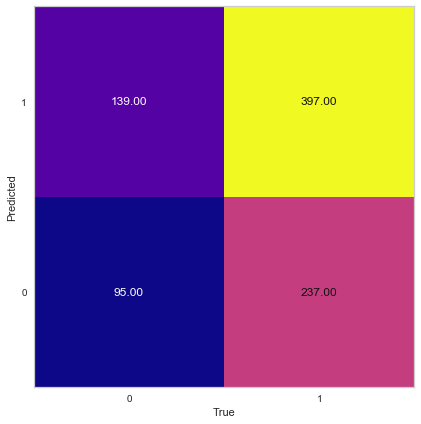

In [97]:
        
svmJP = SVC(kernel = 'rbf', C =1, gamma =100,probability = True)
svmJP.fit(X_train_res,y_train_res)

print(metrics.accuracy_score(y_test_norm,svmJP.predict(X_test_norm)))

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array =metrics.confusion_matrix(y_test_norm, svmJP.predict(X_test_norm))

personality_types = np.unique(y_test_norm)

df_cm = pd.DataFrame(array, index = [i for i in personality_types],
                  columns = [i for i in personality_types])

plt.figure(figsize = (7,7))
heatmap(array, xlabel='True', xticklabels=personality_types, ylabel='Predicted', yticklabels=personality_types, cmap="plasma")
plt.show()

In [98]:
print("R^2: {}".format(metrics.precision_score(y_test_norm, svmJP.predict(X_test_norm),average='macro') ))
print("precision: {}".format(metrics.recall_score(y_test_norm, svmJP.predict(X_test_norm),average='macro') ))
print("recall_score: {}".format( metrics.recall_score(y_test_norm, svmJP.predict(X_test_norm),average='macro') ))
print("f1_score: {}".format( metrics.f1_score(y_test_norm, svmJP.predict(X_test_norm),average='macro') ))
print("accuracy_score: {}".format( metrics.accuracy_score(y_test_norm, svmJP.predict(X_test_norm)) ))

R^2: 0.5160829356412953
precision: 0.5134081100521488
recall_score: 0.5134081100521488
f1_score: 0.5071607622844372
accuracy_score: 0.5668202764976958


Average precision-recall score: 0.59


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.59')

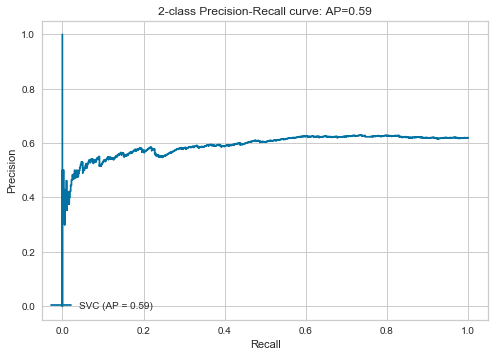

In [99]:
y_score = svmJP.decision_function(X_test_norm)
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test_norm, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

disp = plot_precision_recall_curve(svmJP, X_test_norm, y_test_norm)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

In [100]:
voting_clf_JP = VotingClassifier(
    estimators=[('lr', svmJP), ('svc', LogRegJP),('rnd', RNDJP)], voting='soft')
voting_clf_JP.fit(X_train_res, y_train_res)



VotingClassifier(estimators=[('lr',
                              SVC(C=1, break_ties=False, cache_size=200,
                                  class_weight=None, coef0=0.0,
                                  decision_function_shape='ovr', degree=3,
                                  gamma=100, kernel='rbf', max_iter=-1,
                                  probability=True, random_state=None,
                                  shrinking=True, tol=0.001, verbose=False)),
                             ('svc',
                              LogisticRegression(C=100, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling...
                                                   criterion='gini',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_

In [101]:
print("R^2: {}".format(metrics.precision_score(y_test_norm, voting_clf_JP.predict(X_test_norm),average='macro') ))
print("precision: {}".format(metrics.recall_score(y_test_norm, voting_clf_JP.predict(X_test_norm),average='macro') ))
print("recall_score: {}".format( metrics.recall_score(y_test_norm, voting_clf_JP.predict(X_test_norm),average='macro') ))
print("f1_score: {}".format( metrics.f1_score(y_test_norm, voting_clf_JP.predict(X_test_norm),average='macro') ))
print("accuracy_score: {}".format( metrics.accuracy_score(y_test_norm, voting_clf_JP.predict(X_test_norm)) ))

R^2: 0.5088709677419354
precision: 0.5076649883114548
recall_score: 0.5076649883114548
f1_score: 0.5028755518434556
accuracy_score: 0.5576036866359447


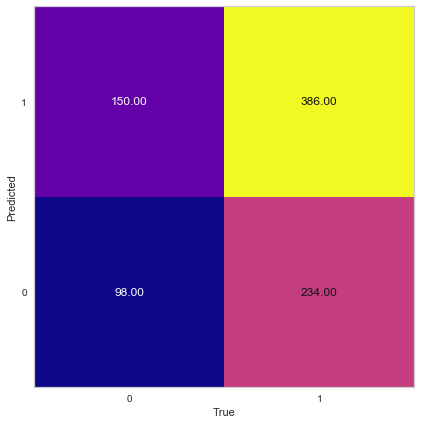

In [102]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array =metrics.confusion_matrix(y_test_norm, voting_clf_JP.predict(X_test_norm))

personality_types = np.unique(y_test_norm)

df_cm = pd.DataFrame(array, index = [i for i in personality_types],
                  columns = [i for i in personality_types])

plt.figure(figsize = (7,7))
heatmap(array, xlabel='True', xticklabels=personality_types, ylabel='Predicted', yticklabels=personality_types, cmap="plasma")
plt.show()

In [137]:
#Best Clssificators:

Classif_res_JP = "Some Classificator Here"
Classif_res_JP.fit(X_train_res, y_train_res)

from sklearn import metrics

print("R^2: {}".format(metrics.precision_score(y_test, Classif_res_JP.predict(X_test),average='micro') ))
print("recall_score: {}".format( metrics.recall_score(y_test, Classif_res_JP.predict(X_test),average='micro') ))
print("f1_score: {}".format( metrics.f1_score(y_test, Classif_res_JP.predict(X_test),average='micro') ))
print("accuracy_score: {}".format( metrics.accuracy_score(y_test, Classif_res_JP.predict(X_test)) ))

AttributeError: 'str' object has no attribute 'fit'

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array =metrics.confusion_matrix(y_test, Classif_res_JP.predict(X_test))

personality_types = np.unique(y_test)

df_cm = pd.DataFrame(array, index = [i for i in personality_types],
                  columns = [i for i in personality_types])

plt.figure(figsize = (15,15))
heatmap(array, xlabel='True', xticklabels=personality_types, ylabel='Predicted', yticklabels=personality_types, cmap="plasma")
plt.show() 

# Automatyczna Ekstrakcja Cech

(8675,)
(8675,)


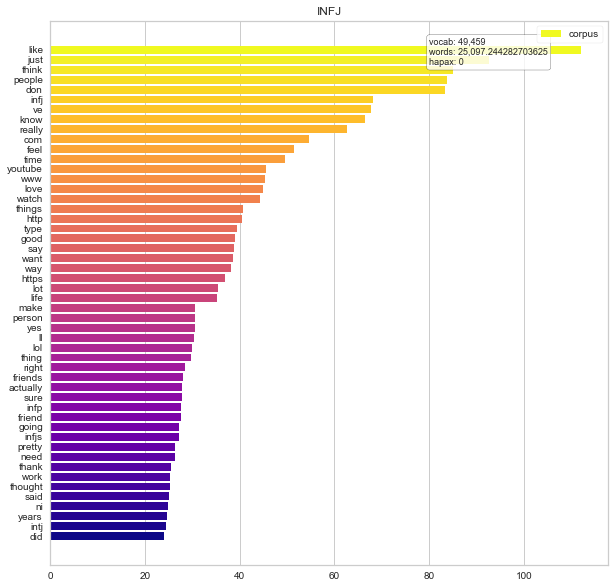

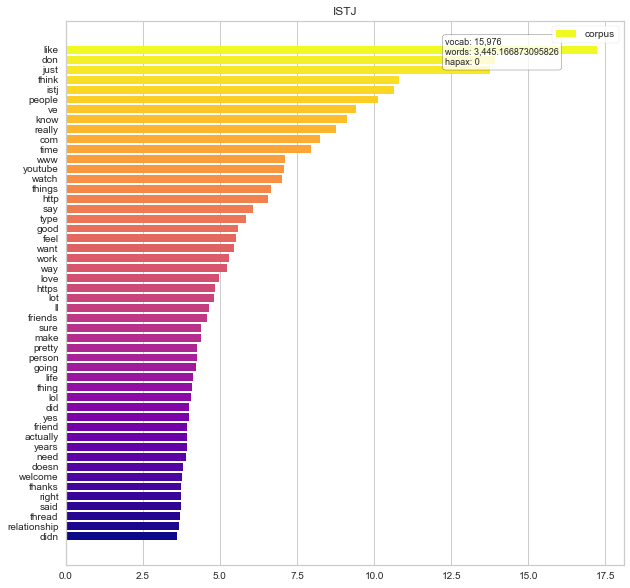

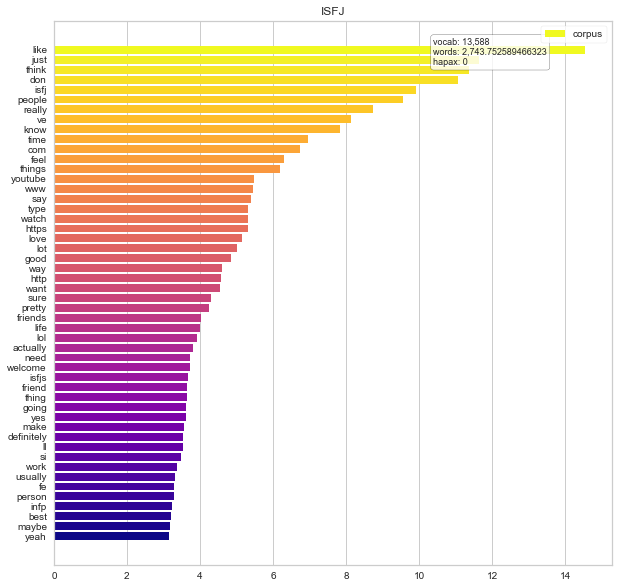

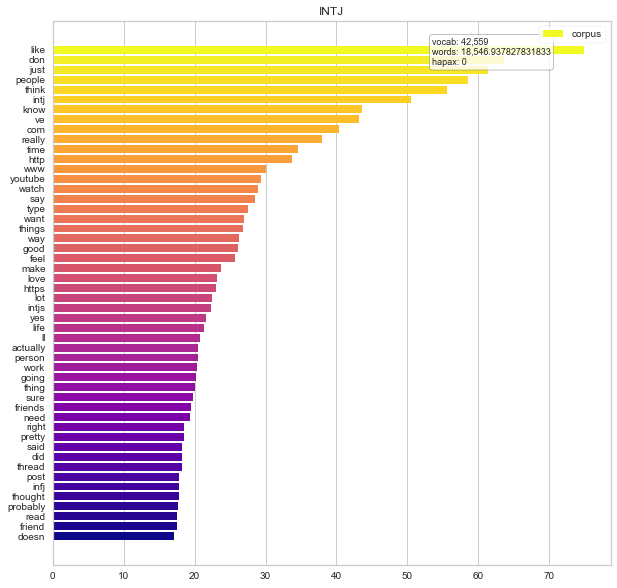

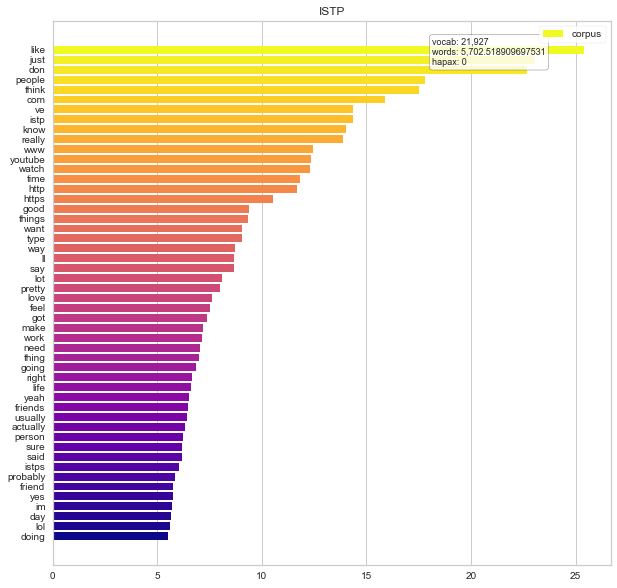

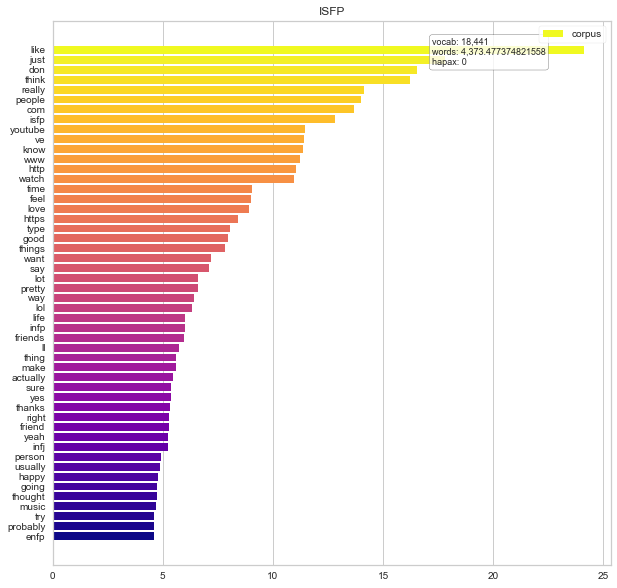

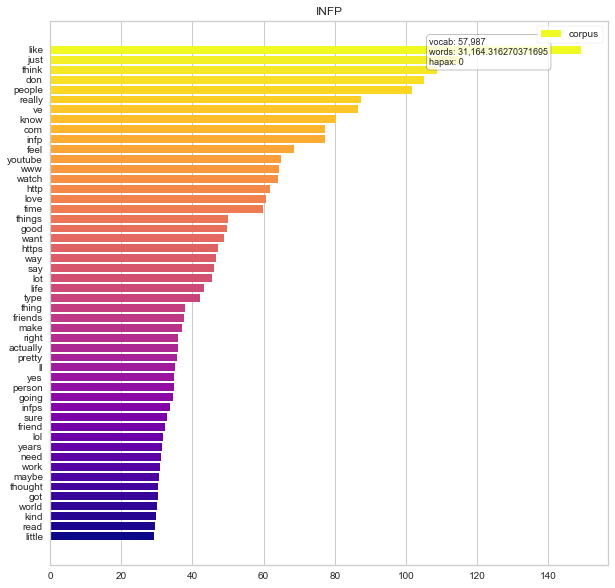

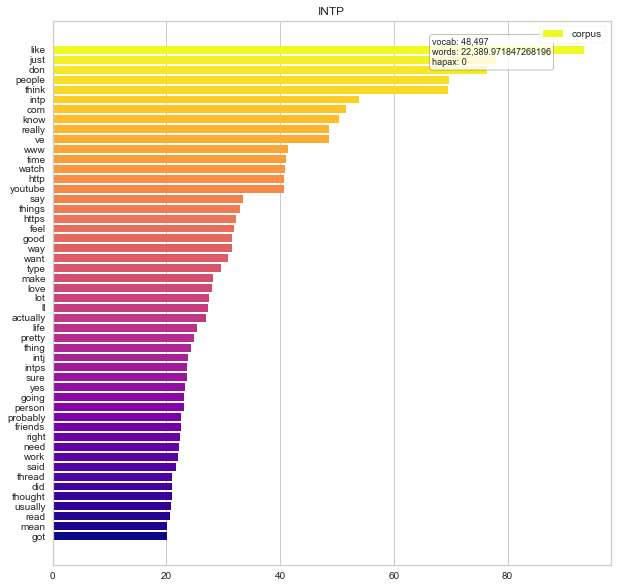

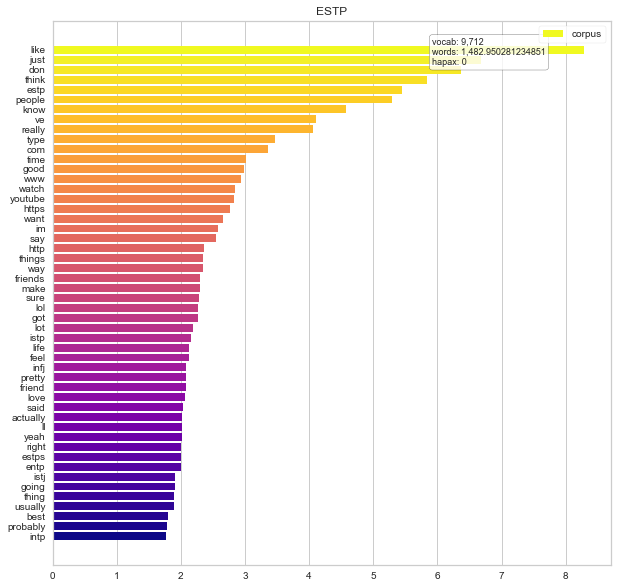

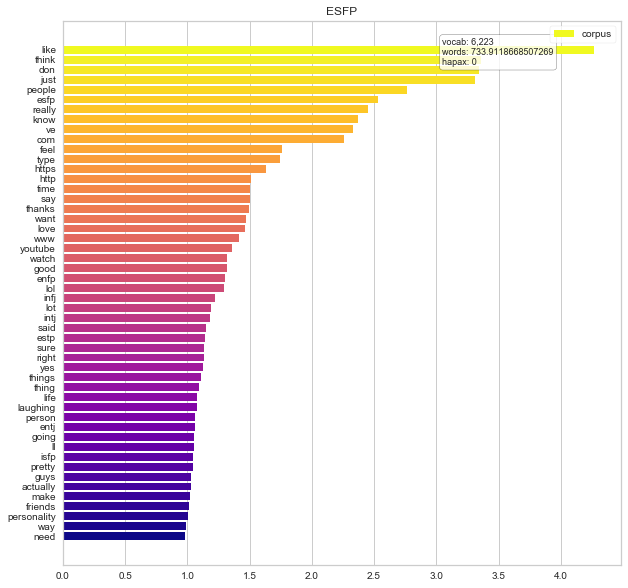

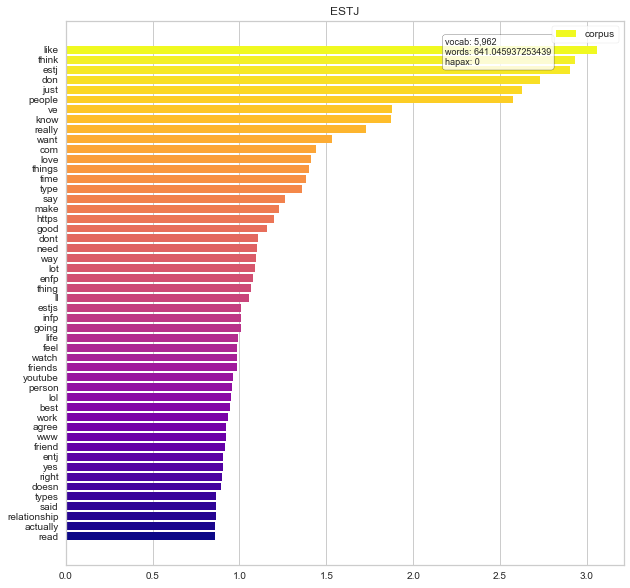

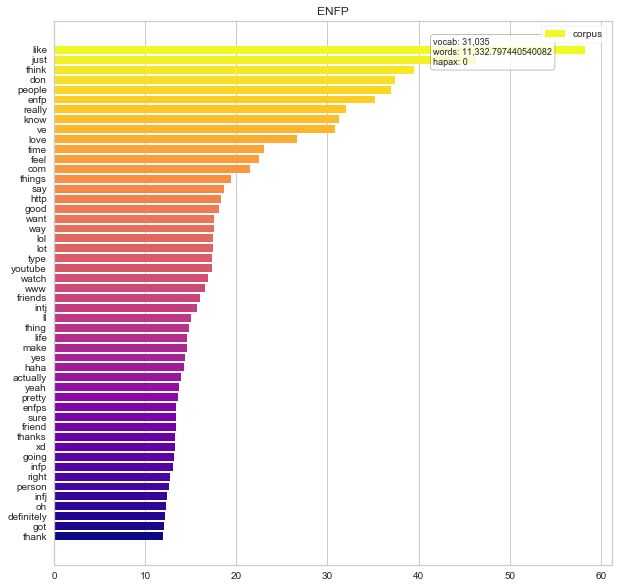

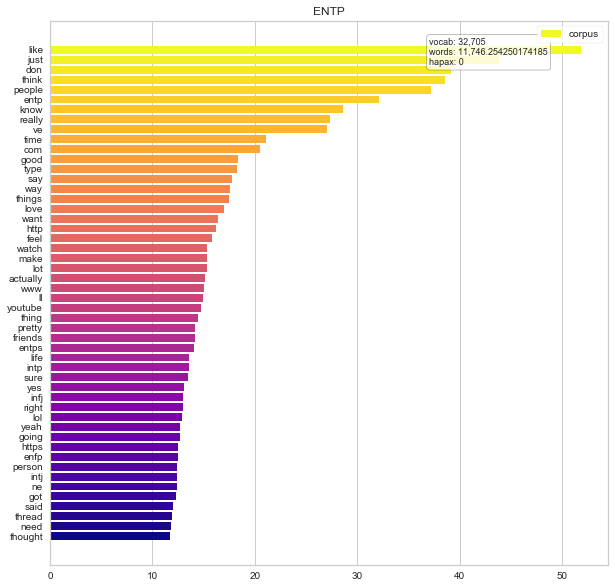

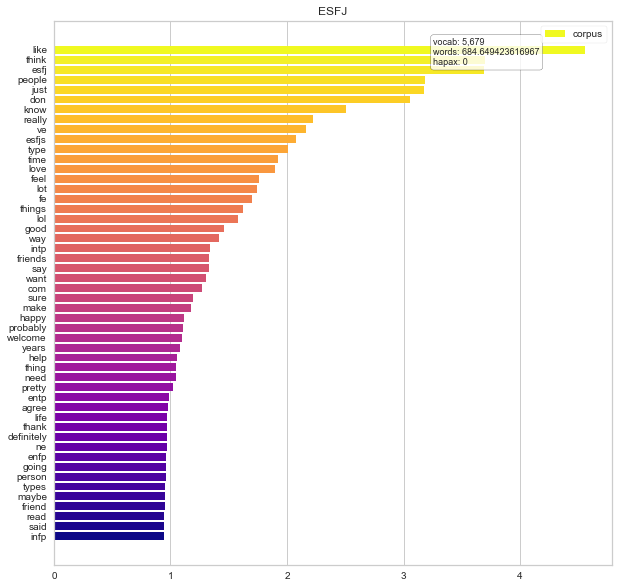

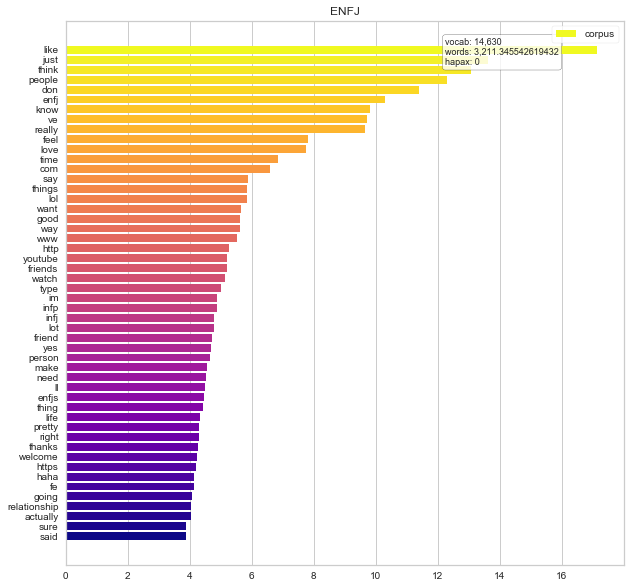

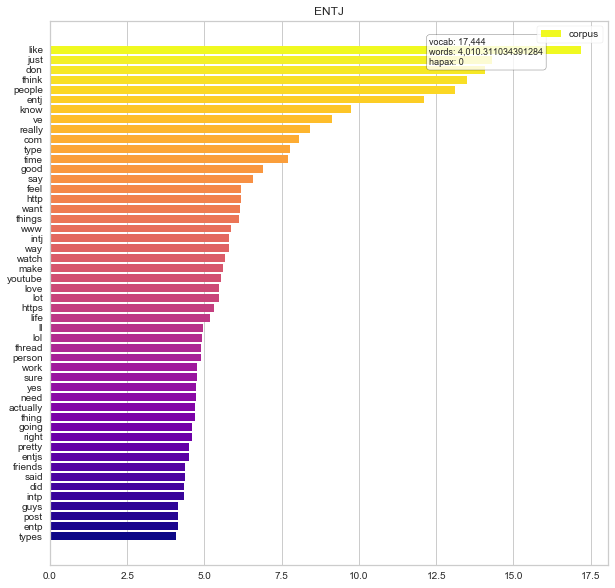

In [30]:
from sklearn.feature_extraction.text import CountVectorizer
from yellowbrick.text import FreqDistVisualizer

def Most_frequent_words_in_Group(types):
    XXX = df['posts'].loc[df["type"] == types].values
    
    from matplotlib import cm

    cnt_srs = df['type'].value_counts()
    viridis = cm.get_cmap('plasma', 50)
    colors = viridis(np.flip(np.linspace(0, 1, 50)))
    
    TfidVect  = tfidf.fit_transform(XXX)
    svd_model = tsvd
    data_revitalised = svd_model.fit_transform(TfidVect)
    plt.figure(figsize = (10,10))
    visualizer = FreqDistVisualizer(features=tfidf.get_feature_names(), orient='h',title =types, color = colors)
    visualizer.fit(TfidVect)
    #visualizer.title(types)
    visualizer.show()
    
    
    
Most_frequent_words_in_Group('INFJ')
Most_frequent_words_in_Group('ISTJ')
Most_frequent_words_in_Group('ISFJ')
Most_frequent_words_in_Group('INTJ')
Most_frequent_words_in_Group('ISTP')
Most_frequent_words_in_Group('ISFP')
Most_frequent_words_in_Group('INFP')
Most_frequent_words_in_Group('INTP')
Most_frequent_words_in_Group('ESTP')
Most_frequent_words_in_Group('ESFP')
Most_frequent_words_in_Group('ESTJ')
Most_frequent_words_in_Group('ENFP')
Most_frequent_words_in_Group('ENTP')
Most_frequent_words_in_Group('ESFJ')
Most_frequent_words_in_Group('ENFJ')
Most_frequent_words_in_Group('ENTJ')




### Automatyczna dla całości 

In [ ]:
XX = df['clean_posts'].values
yy = df['type'].values

print(XX.shape)
print(yy.shape)

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(XX,yy,test_size = 0.1, random_state=42)

tfidf = TfidfVectorizer(ngram_range=(1, 1), stop_words='english')
tsvd = TruncatedSVD(n_components=10)

#Przeprowadzamy Text Mining oraz Skalowanie danych i redukcje wymiarów

TfidVect  = tfidf.fit_transform(X_train)
svd_model = tsvd
data_revitalised_train = svd_model.fit_transform(TfidVect)

TfidVect_test  = tfidf.fit_transform(X_test)
svd_model_test = tsvd
data_revitalised_test = svd_model_test.fit_transform(TfidVect_test)

sm = SMOTE()
X_train_res, y_train_res = sm.fit_sample(data_revitalised, y_train)


In [ ]:
#Best Clssificators:

Classif_res_Automatic = "Some Classificator Here"
Classif_res_Automatic.fit(X_train_res, y_train_res)

from sklearn import metrics

print("R^2: {}".format(metrics.precision_score(y_test, Classif_res_Automatic.predict(X_test),average='micro') ))
print("recall_score: {}".format( metrics.recall_score(y_test, Classif_res_Automatic.predict(X_test),average='micro') ))
print("f1_score: {}".format( metrics.f1_score(y_test, Classif_res_Automatic.predict(X_test),average='micro') ))
print("accuracy_score: {}".format( metrics.accuracy_score(y_test, Classif_res_Automatic.predict(X_test)) ))

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array =metrics.confusion_matrix(y_test, Classif_res_Automatic.predict(X_test))

personality_types = np.unique(y_test)

df_cm = pd.DataFrame(array, index = [i for i in personality_types],
                  columns = [i for i in personality_types])

plt.figure(figsize = (15,15))
heatmap(array, xlabel='True', xticklabels=personality_types, ylabel='Predicted', yticklabels=personality_types, cmap="plasma")
plt.show() 

### Automatyczna dla I-E 

In [ ]:
XX = df['clean_posts'].values
yy = df['I-E'].values

print(XX.shape)
print(yy.shape)

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(XX,yy,test_size = 0.1, random_state=42)

tfidf = TfidfVectorizer(ngram_range=(1, 1), stop_words='english')
tsvd = TruncatedSVD(n_components=10)

#Przeprowadzamy Text Mining oraz Skalowanie danych i redukcje wymiarów

TfidVect  = tfidf.fit_transform(X_train)
svd_model = tsvd
data_revitalised_train = svd_model.fit_transform(TfidVect)

TfidVect_test  = tfidf.fit_transform(X_test)
svd_model_test = tsvd
data_revitalised_test = svd_model_test.fit_transform(TfidVect_test)

sm = SMOTE()
X_train_res, y_train_res = sm.fit_sample(data_revitalised, y_train)


In [ ]:
#Best Clssificators:

Classif_res_Automatic_IE = "Some Classificator Here"
Classif_res_Automatic_IE.fit(X_train_res, y_train_res)

from sklearn import metrics

print("R^2: {}".format(metrics.precision_score(y_test, Classif_res_Automatic_IE.predict(X_test),average='micro') ))
print("recall_score: {}".format( metrics.recall_score(y_test, Classif_res_Automatic_IE.predict(X_test),average='micro') ))
print("f1_score: {}".format( metrics.f1_score(y_test, Classif_res_Automatic_IE.predict(X_test),average='micro') ))
print("accuracy_score: {}".format( metrics.accuracy_score(y_test, Classif_res_Automatic_IE.predict(X_test)) ))

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array =metrics.confusion_matrix(y_test, Classif_res_Automatic_IE.predict(X_test))

personality_types = np.unique(y_test)

df_cm = pd.DataFrame(array, index = [i for i in personality_types],
                  columns = [i for i in personality_types])

plt.figure(figsize = (15,15))
heatmap(array, xlabel='True', xticklabels=personality_types, ylabel='Predicted', yticklabels=personality_types, cmap="plasma")
plt.show() 

### Automatyczna dla N-S

In [ ]:
XX = df['clean_posts'].values
yy = df['N-S'].values

print(XX.shape)
print(yy.shape)

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(XX,yy,test_size = 0.1, random_state=42)

tfidf = TfidfVectorizer(ngram_range=(1, 1), stop_words='english')
tsvd = TruncatedSVD(n_components=10)

#Przeprowadzamy Text Mining oraz Skalowanie danych i redukcje wymiarów

TfidVect  = tfidf.fit_transform(X_train)
svd_model = tsvd
data_revitalised_train = svd_model.fit_transform(TfidVect)

TfidVect_test  = tfidf.fit_transform(X_test)
svd_model_test = tsvd
data_revitalised_test = svd_model_test.fit_transform(TfidVect_test)

sm = SMOTE()
X_train_res, y_train_res = sm.fit_sample(data_revitalised, y_train)


In [ ]:
#Best Clssificators:

Classif_res_Automatic_NS = "Some Classificator Here"
Classif_res_Automatic_NS.fit(X_train_res, y_train_res)

from sklearn import metrics

print("R^2: {}".format(metrics.precision_score(y_test, Classif_res_Automatic_NS.predict(X_test),average='micro') ))
print("recall_score: {}".format( metrics.recall_score(y_test, Classif_res_Automatic_NS.predict(X_test),average='micro') ))
print("f1_score: {}".format( metrics.f1_score(y_test, Classif_res_Automatic_NS.predict(X_test),average='micro') ))
print("accuracy_score: {}".format( metrics.accuracy_score(y_test, Classif_res_Automatic_NS.predict(X_test)) ))

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array =metrics.confusion_matrix(y_test, Classif_res_Automatic_NS.predict(X_test))

personality_types = np.unique(y_test)

df_cm = pd.DataFrame(array, index = [i for i in personality_types],
                  columns = [i for i in personality_types])

plt.figure(figsize = (15,15))
heatmap(array, xlabel='True', xticklabels=personality_types, ylabel='Predicted', yticklabels=personality_types, cmap="plasma")
plt.show() 

### Automatyczna dla T-F 

In [ ]:
XX = df['clean_posts'].values
yy = df['T-F'].values

print(XX.shape)
print(yy.shape)

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(XX,yy,test_size = 0.1, random_state=42)

tfidf = TfidfVectorizer(ngram_range=(1, 1), stop_words='english')
tsvd = TruncatedSVD(n_components=10)

#Przeprowadzamy Text Mining oraz Skalowanie danych i redukcje wymiarów

TfidVect  = tfidf.fit_transform(X_train)
svd_model = tsvd
data_revitalised_train = svd_model.fit_transform(TfidVect)

TfidVect_test  = tfidf.fit_transform(X_test)
svd_model_test = tsvd
data_revitalised_test = svd_model_test.fit_transform(TfidVect_test)

sm = SMOTE()
X_train_res, y_train_res = sm.fit_sample(data_revitalised, y_train)


In [ ]:
#Best Clssificators:

Classif_res_Automatic_TF = "Some Classificator Here"
Classif_res_Automatic_TF.fit(X_train_res, y_train_res)

from sklearn import metrics

print("R^2: {}".format(metrics.precision_score(y_test, Classif_res_Automatic_TF.predict(X_test),average='micro') ))
print("recall_score: {}".format( metrics.recall_score(y_test, Classif_res_Automatic_TF.predict(X_test),average='micro') ))
print("f1_score: {}".format( metrics.f1_score(y_test, Classif_res_Automatic_TF.predict(X_test),average='micro') ))
print("accuracy_score: {}".format( metrics.accuracy_score(y_test, Classif_res_Automatic_TF.predict(X_test)) ))

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array =metrics.confusion_matrix(y_test, Classif_res_Automatic_TF.predict(X_test))

personality_types = np.unique(y_test)

df_cm = pd.DataFrame(array, index = [i for i in personality_types],
                  columns = [i for i in personality_types])

plt.figure(figsize = (15,15))
heatmap(array, xlabel='True', xticklabels=personality_types, ylabel='Predicted', yticklabels=personality_types, cmap="plasma")
plt.show() 

### Automatyczna dla J-P

In [ ]:
XX = df['clean_posts'].values
yy = df['J-P'].values

print(XX.shape)
print(yy.shape)

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(XX,yy,test_size = 0.1, random_state=42)

tfidf = TfidfVectorizer(ngram_range=(1, 1), stop_words='english')
tsvd = TruncatedSVD(n_components=10)

#Przeprowadzamy Text Mining oraz Skalowanie danych i redukcje wymiarów

TfidVect  = tfidf.fit_transform(X_train)
svd_model = tsvd
data_revitalised_train = svd_model.fit_transform(TfidVect)

TfidVect_test  = tfidf.fit_transform(X_test)
svd_model_test = tsvd
data_revitalised_test = svd_model_test.fit_transform(TfidVect_test)

sm = SMOTE()
X_train_res, y_train_res = sm.fit_sample(data_revitalised, y_train)


In [ ]:
#Best Clssificators:

Classif_res_Automatic_JP = "Some Classificator Here"
Classif_res_Automatic_JP.fit(X_train_res, y_train_res)

from sklearn import metrics

print("R^2: {}".format(metrics.precision_score(y_test, Classif_res_Automatic_JP.predict(X_test),average='micro') ))
print("recall_score: {}".format( metrics.recall_score(y_test, Classif_res_Automatic_JP.predict(X_test),average='micro') ))
print("f1_score: {}".format( metrics.f1_score(y_test, Classif_res_Automatic_JP.predict(X_test),average='micro') ))
print("accuracy_score: {}".format( metrics.accuracy_score(y_test, Classif_res_Automatic_JP.predict(X_test)) ))

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array =metrics.confusion_matrix(y_test, Classif_res_Automatic_JP.predict(X_test))

personality_types = np.unique(y_test)

df_cm = pd.DataFrame(array, index = [i for i in personality_types],
                  columns = [i for i in personality_types])

plt.figure(figsize = (15,15))
heatmap(array, xlabel='True', xticklabels=personality_types, ylabel='Predicted', yticklabels=personality_types, cmap="plasma")
plt.show() 